Sodelujoči

    Tomaž Štrus
    Anže Košir
    Jan Harej

O projektu: Iz platforme Steam, namenjenu predvsem za distrubicijo video iger, bomo zbrali podatke igrah več ljudi, ter analizirali stvari kot so npr. koliko iger, ki jih kupijo dejansko preigrajo, kolika časa bo nekdo zapravil za neko igro, kakšno igro bo kupil naslednjo, glede na svoje igre ipd.

Podatki: Uporabili bomo API, ki ga ponuja Steam: https://developer.valvesoftware.com/wiki/Steam_Web_API#JSON Tu lahko dobimo podatko o čisto vsemu kar potrebujemo npr. o uporabniku, njegove igre, prijatelji, koliko ur je igral neko igro, ... Dobili bomo podatke za npr. 100.000+ uporabnikov (prijatelji naših prijateljev, in njihov prijateljev itd.)

## Vprašanja za raziskavo
1. Povprečno dokončanje igre
2. Število in vrsta Bannov v povezavi z javnimi/privatnimi profili
3. Najmanjkrat odklenjeni dosežki za igrane igre
4. Število prijateljev glede na "starost" računa

In [1]:
#install libraries on windows
"""
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install requests
"""

'\n!python -m pip install numpy\n!python -m pip install matplotlib\n!python -m pip install requests\n'

In [2]:
import requests
import json
import numpy
import datetime
import matplotlib.pyplot as plt
import os
import collections
from inspect import getouterframes, currentframe

In [3]:
api_key = "5F5DD2FA8A6C8646FCFE265C07BB90E5"
global_player_ids = set()
players_summaries = dict()
player_friends = dict()
player_games = dict()
player_games = dict()
player_achievements = dict()
my_id="76561198101569818"

In [4]:
def get_player_summary (id):
    try:
        data = requests.get( "http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key="+api_key+"&steamids="+id).json()
    except:
        return None
    return data["response"]["players"][0]
    
def get_multiple_player_summary (ids):
    request_str = "http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key="+api_key+"&steamids="
    request_str += ",".join(ids)

    try:
        data = requests.get(request_str).json()
    except:
        return None
    return data["response"]["players"]
    

In [5]:
def get_player_friends(id):
    try:
        data = requests.get( "http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key=" + api_key + "&steamid=" + str(id) + "&relationship=friend").json()["friendslist"]["friends"]
    except KeyError:
        return []
    return data

In [6]:
def get_owned_games(id):
    try:
        data = requests.get( "http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=" + api_key + "&steamid=" + str(id)).json()["response"]
    except KeyError:
        return []
    return data

In [7]:
print(get_player_summary("76561198024756463"))

{'steamid': '76561198024756463', 'communityvisibilitystate': 3, 'profilestate': 1, 'personaname': 'Pwnisher', 'lastlogoff': 1396960546, 'profileurl': 'https://steamcommunity.com/profiles/76561198024756463/', 'avatar': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/95/95e60b4ec1a85412b433238966e93cc184cc9ec7.jpg', 'avatarmedium': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/95/95e60b4ec1a85412b433238966e93cc184cc9ec7_medium.jpg', 'avatarfull': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/95/95e60b4ec1a85412b433238966e93cc184cc9ec7_full.jpg', 'personastate': 0, 'realname': 'Lan Rahne', 'primaryclanid': '103582791432130426', 'timecreated': 1273330464, 'personastateflags': 0, 'loccountrycode': 'SI'}


In [8]:
def get_achievements_for_player_game(id, appid):
    data = requests.get( "http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?appid=" + str(appid) + "&key=" + api_key + "&steamid=" + str(id)).json()
    return data

In [22]:
##get_achievements_for_player_game(my_id, 620)

{'playerstats': {'achievements': [{'achieved': 1,
    'apiname': 'ACH.SURVIVE_CONTAINER_RIDE',
    'unlocktime': 1389732971},
   {'achieved': 1, 'apiname': 'ACH.WAKE_UP', 'unlocktime': 1389737075},
   {'achieved': 1, 'apiname': 'ACH.LASER', 'unlocktime': 1389737312},
   {'achieved': 1, 'apiname': 'ACH.BRIDGE', 'unlocktime': 1389739035},
   {'achieved': 1, 'apiname': 'ACH.BREAK_OUT', 'unlocktime': 1389740798},
   {'achieved': 1,
    'apiname': 'ACH.STALEMATE_ASSOCIATE',
    'unlocktime': 1389742183},
   {'achieved': 1,
    'apiname': 'ACH.ADDICTED_TO_SPUDS',
    'unlocktime': 1389748133},
   {'achieved': 1, 'apiname': 'ACH.BLUE_GEL', 'unlocktime': 1389743997},
   {'achieved': 1, 'apiname': 'ACH.ORANGE_GEL', 'unlocktime': 1389748133},
   {'achieved': 1, 'apiname': 'ACH.WHITE_GEL', 'unlocktime': 1389748133},
   {'achieved': 1, 'apiname': 'ACH.TRACTOR_BEAM', 'unlocktime': 1389753271},
   {'achieved': 1, 'apiname': 'ACH.TRIVIAL_TEST', 'unlocktime': 1389748397},
   {'achieved': 1,
    'apina

In [10]:
def fill_player_ids_rec(id, num = 1000, already_called = set()):
    global global_player_ids
    already_called.add(id)
    print("recursive call of id: " + id + "  len: " + str(len(global_player_ids)))
    try:
        if get_player_summary(id)["profilestate"] != 1:
            #print("not public")
            return None
    except KeyError:
        #print("not public key error")
        return None
    data = get_player_friends(id)
    tmp_id = set()
    for friend in data:
        if len(global_player_ids) >= num:
            print("enough friends")
            break
        tmp_id.add(friend["steamid"])
        global_player_ids.add(friend["steamid"])
        #print("len: "+ str(len(global_player_ids)))
        
    print("added my friends" + "  len: " + str(len(global_player_ids)))
    
    for playerid in tmp_id:
        if len(global_player_ids) >= num:
            break
        data = get_player_friends(playerid)
        for fof in data:
            if len(global_player_ids) >= num:
                print("enough friends")
                break
            global_player_ids.add(fof["steamid"])
        #print("added friends of friend")
            
    print("added friends of friends" + "  len: " + str(len(global_player_ids)))
    
    for playerid in tmp_id:
        if len(global_player_ids) >= num:
            print("enough friends")
            break
        if playerid not in already_called:
            fill_player_ids_rec(playerid, num, already_called)
    
    

In [11]:
def fill_players_summaries():
    global global_player_ids
    global players_summaries
    
    player_ids = list(global_player_ids)
    for i in range(0, len(player_ids)+1, 100):
        tmp_summaries = get_multiple_player_summary(player_ids[i-100:i])
        for summary in tmp_summaries:
            #summary["friends"] = get_player_friends(summary["steamid"])
            players_summaries[summary["steamid"]] = summary
        

In [12]:
def fill_players_friends():
    global player_friends
    global players_summaries
    for player in players_summaries.keys():
        player_friends[player] = get_player_friends(player)
        print(len(player_friends))
    print("done")

In [13]:
def fill_players_games():
    global player_games
    for player_id in global_player_ids:
        player_games[player_id] = get_owned_games(player_id)
        
    

In [25]:
def fill_players_achievements():
    global player_achievements
    for player_id in global_player_ids:
        if len(player_games[player_id]) == 0:
            player_achievements[player_id] = set()
        else:
            for game in player_games[player_id]['games']:
                gameid = game["appid"]
                gamedata = get_achievements_for_player_game(player_id, gameid)
                if player_id in player_achievements:
                    player_achievements[player_id]
                else:
                    player_achievements[player_id] = dict()
                    player_achievements[player_id][gameid] = gamedata
                print(gamedata)
                print(game)
                print("\n")
            

In [ ]:
fill_players_achievements()

{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 211500, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 230410, 'playtime_forever': 84}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 44350, 'playtime_forever': 4297}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 249130, 'playtime_forever': 4618}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 256370, 'playtime_forever': 772}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 267530, 'playtime_forever': 3899}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 291210, 'playtime_forever': 1772}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 304930, 'playtime_2weeks': 9, 'playtime_forever': 1503}


{'playerstats': {'error': 'Profile is not public', 'succe

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Day of Defeat: Source', 'achievements': [{'apiname': 'DOD_THROW_BACK_GREN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_CONSECUTIVE_HEADSHOTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_MG_POSITION_STREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_WIN_KNIFE_FIGHT', 'achieved': 1, 'unlocktime': 1381856172}, {'apiname': 'DOD_PLAY_CUSTOM_MAPS', 'achieved': 1, 'unlocktime': 1381856232}, {'apiname': 'DOD_KILLS_WITH_GRENADE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_LONG_RANGE_ROCKET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_END_ROUND_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_CAP_LAST_FLAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_USE_ENEMY_WEAPONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_KILL_DOMINATING_MG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_COLMAR_DEFENSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOD_BLOCK_CAPTURES', 'achieved': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 10190, 'playtime_forever': 25533}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Left 4 Dead 2', 'achievements': [{'apiname': 'ACH_HONK_A_CLOWNS_NOSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_INCENDIARY_CLOWN_POSSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MELEE_A_CHARGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_SPITTER_FAST', 'achieved': 1, 'unlocktime': 1388326316}, {'apiname': 'ACH_FINISH_CAMPAIGN_MELEE_ONLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_EVERY_UNCOMMON_INFECTED', 'achieved': 1, 'unlocktime': 1388350198}, {'apiname': 'ACH_SAVE_PLAYER_FROM_JOCKEY_FAST', 'achieved': 1, 'unlocktime': 1388265067}, {'apiname': 'ACH_CUT_OFF_HEADS_MELEE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VS_LEAVE_SAFE_ROOM_DEFIB_TEAMMATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAT_CAMPAIGNS_EXPERT_MODE', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Super Meat Boy', 'achievements': [{'apiname': 'ACH_IRONMAN_FOREST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_HOSPITAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_SALTFACTORY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_HELL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_RAPTURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_THEEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN_COTTONALLEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARP_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARP_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARP_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARP_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THEEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THEREALEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100%', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33440, 'playtime_forever': 174}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Rising Storm/Red Orchestra 2 Multiplayer', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Red Orchestra 2: Heroes of Stalingrad - Single Player', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'The Elder Scrolls V: Skyrim', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 1, 'unlocktime': 1403391252}, {'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 1, 'unlocktime': 1403400632}, {'apiname': 'NEW_ACHIEVEMENT_3_0', 'achieved': 1, 'unlocktime': 1403409258}, {'apiname': 'NEW_ACHIEVEMENT_4_0', 'achieved': 1, 'unlocktime': 1411910798}, {'apiname': 'NEW_ACHIEVEMENT_5_0', 'achieved': 1, 'unlocktime': 1411918304}, {'apiname': 'NEW_ACHIEVEMENT_6_0', 'achieved': 1, 'unlocktime': 1411929705}, {'apiname': 'NEW_ACHIEVEMENT_7_0', 'achieved': 1, 'unlocktime': 1411989304}, {'apiname': 'NEW_ACHIEVEMENT_8_0', 'achieved': 1, 'unlocktime': 1411993228}, {'apiname': 'NEW_ACHIEVEMENT_9_0', 'achieved': 1, 'unlocktime': 1412060151}, {'apiname': 'NEW_ACHIEVEMENT_10_0', 'achieved': 1, 'unlocktime': 1412070502}, {'apiname': 'NEW_ACHIEVEMENT_11_0', 'achieved': 1, 'unlocktime': 1412170472}, {'apiname': 'NEW_ACHIEVEMENT_12_0', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 212630, 'playtime_forever': 218}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Counter-Strike: Global Offensive', 'achievements': [{'apiname': 'WIN_BOMB_PLANT', 'achieved': 1, 'unlocktime': 1395239574}, {'apiname': 'BOMB_PLANT_LOW', 'achieved': 1, 'unlocktime': 1408294507}, {'apiname': 'BOMB_DEFUSE_LOW', 'achieved': 1, 'unlocktime': 1417810189}, {'apiname': 'KILL_ENEMY_LOW', 'achieved': 1, 'unlocktime': 1394962137}, {'apiname': 'KILL_ENEMY_MED', 'achieved': 1, 'unlocktime': 1395252648}, {'apiname': 'KILL_ENEMY_HIGH', 'achieved': 1, 'unlocktime': 1417259963}, {'apiname': 'BOMB_DEFUSE_CLOSE_CALL', 'achieved': 1, 'unlocktime': 1395408147}, {'apiname': 'KILL_BOMB_DEFUSER', 'achieved': 1, 'unlocktime': 1395337804}, {'apiname': 'WIN_BOMB_DEFUSE', 'achieved': 1, 'unlocktime': 1395233815}, {'apiname': 'BOMB_PLANT_IN_25_SECONDS', 'achieved': 1, 'unlocktime': 1396459512}, {'apiname': 'WIN_ROUND

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Awesomenauts', 'achievements': [{'apiname': 'AT_01', 'achieved': 1, 'unlocktime': 1445697744}, {'apiname': 'AT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_05', 'achieved': 1, 'unlocktime': 1489168249}, {'apiname': 'AT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_09', 'achieved': 1, 'unlocktime': 1445697744}, {'apiname': 'ATBOUNTYHUNTER1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBAREHANDED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS4', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Borderlands 2', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 1, 'unlocktime': 1404147861}, {'apiname': 'Achievement_2', 'achieved': 1, 'unlocktime': 1404153613}, {'apiname': 'Achievement_3', 'achieved': 1, 'unlocktime': 1404155290}, {'apiname': 'Achievement_4', 'achieved': 1, 'unlocktime': 1404155896}, {'apiname': 'Achievement_5', 'achieved': 1, 'unlocktime': 1404192121}, {'apiname': 'Achievement_6', 'achieved': 1, 'unlocktime': 1404198868}, {'apiname': 'Achievement_7', 'achieved': 1, 'unlocktime': 1404219476}, {'apiname': 'Achievement_8', 'achieved': 1, 'unlocktime': 1404219909}, {'apiname': 'Achievement_9', 'achieved': 1, 'unlocktime': 1404294790}, {'apiname': 'Achievement_10', 'achieved': 1, 'unlocktime': 1404300200}, {'apiname': 'Achievement_11', 'achieved': 1, 'unlocktime': 1404303017}, {'apiname': 'Achievement_12', 'achieved': 1, 'unlocktime': 1404306686}, {'apiname': 'Achievement_13', 'achieved': 1, 'unlo

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Dota 2 Test', 'success': True}}
{'appid': 205790, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Tropico 4', 'achievements': [{'apiname': 'Survive a Coup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Survive an uprising', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Construct 1337 buildings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Money in Swiss account', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Roads and garages', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Population over 300 and no shacks', 'achieved': 0, 'unlocktime': 0}, {'apiname': '200 buildings on one island', 'achieved': 0, 'unlocktime': 0}, {'apiname': '20 soldiers and generals', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Earn 1 000 000 from tourism', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Export 1 000 000 from industry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Finish a game high happiness', '

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Realm of the Mad God', 'achievements': [{'apiname': 'UnlockedRogue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedArcher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedPriest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedWarrior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedKnight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedPaladin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedAssassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedNecromancer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedHuntress', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedMystic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedTrickster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedSorcerer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ReachedLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ReachedLevel20', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 218230, 'playtime_forever': 1090}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Warframe', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 1, 'unlocktime': 1472474431}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 1, 'unlocktime': 1472484766}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 1, 'unlocktime': 1472477233}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 1, 'unlocktime': 1472489301}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apin

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'War Thunder', 'achievements': [{'apiname': 'steam_trophy_sink_carriers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_carrier_landings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_fighter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_tank_best_antiAircraft', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_bomber', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_tankman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_mission_maker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_global_shadow_assassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_5_targets_1_second', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_open_10_chests', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_shoot_down_a_plane_with_tank_cannon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_troph

{'playerstats': {'steamID': '76561198079297838', 'gameName': "Tom Clancy's Ghost Recon Phantoms - EU", 'achievements': [{'apiname': '32', 'achieved': 0, 'unlocktime': 0}, {'apiname': '33', 'achieved': 0, 'unlocktime': 0}, {'apiname': '34', 'achieved': 0, 'unlocktime': 0}, {'apiname': '35', 'achieved': 0, 'unlocktime': 0}, {'apiname': '36', 'achieved': 0, 'unlocktime': 0}, {'apiname': '37', 'achieved': 0, 'unlocktime': 0}, {'apiname': '38', 'achieved': 0, 'unlocktime': 0}, {'apiname': '39', 'achieved': 0, 'unlocktime': 0}, {'apiname': '40', 'achieved': 0, 'unlocktime': 0}, {'apiname': '41', 'achieved': 0, 'unlocktime': 0}, {'apiname': '42', 'achieved': 0, 'unlocktime': 0}, {'apiname': '43', 'achieved': 0, 'unlocktime': 0}, {'apiname': '44', 'achieved': 0, 'unlocktime': 0}, {'apiname': '45', 'achieved': 0, 'unlocktime': 0}, {'apiname': '46', 'achieved': 0, 'unlocktime': 0}, {'apiname': '47', 'achieved': 0, 'unlocktime': 0}, {'apiname': '48', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Sniper Ghost Warrior 2', 'achievements': [{'apiname': 'eA_OperationQuarterback', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_OperationArchangel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_Duckhunt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_MyRifleIsMyBestFriend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_HarvesterOfSorrow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_CrocodileHunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_KeepsakesOfWar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_BetterThanDrake', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_HazardousMaterials', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_DeathsScythe', 'achieved': 1, 'unlocktime': 1500292121}, {'apiname': 'eA_NervesOfSteel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_BallsOfSteel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_DirtyHarry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_Ps

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Monaco', 'achievements': [{'apiname': 'ACH_HIDE_FROM_ATTACKING_GUARD_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_EVERYONE_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FINISH_BANK_UNSEEN_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FINISH_WITH_WRENCH_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GIB_3_GUARDS_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_MEDALS_ALL_LEVELS_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAT_CAMPAIGN_SINGLE_PLAYER_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAT_BOTH_CAMPAIGNS_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_REZ_ONLINE_TEAMMATE_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PLAY_IT_AGAIN_SAM_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_PVP_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNSCATHED_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ZOMBIE_12', 'achie

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Spelunky', 'achievements': [{'apiname': 'ACH_SO_IT_BEGINS', 'achieved': 1, 'unlocktime': 1443877290}, {'apiname': 'ACH_MINES_SHAFTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_JUNGLE_JAMMED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ICE_CREAMED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MADE_IT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIG_MONEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CITY_OF_GOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ETERNAL_LIFE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRONMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPEEDLUNKY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ADDICTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TO_HELL_AND_BACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SEEN_A_LOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SEEN_IT_ALL', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Batman™: Arkham Origins', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 1, 'unlocktime': 1403836049}, {'apiname': 'Achievement_2', 'achieved': 1, 'unlocktime': 1403845587}, {'apiname': 'Achievement_3', 'achieved': 1, 'unlocktime': 1403846644}, {'apiname': 'Achievement_4', 'achieved': 1, 'unlocktime': 1403875835}, {'apiname': 'Achievement_5', 'achieved': 1, 'unlocktime': 1403883993}, {'apiname': 'Achievement_6', 'achieved': 1, 'unlocktime': 1403921566}, {'apiname': 'Achievement_7', 'achieved': 1, 'unlocktime': 1405879037}, {'apiname': 'Achievement_8', 'achieved': 1, 'unlocktime': 1409449441}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 1, 'unlocktime': 1403971785}, {'apiname': 'Achievement_12', 'achieved': 1, 'unlocktime': 1405880920}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Urban Trial Freestyle', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 1, 'unlocktime': 1403641546}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 1, 'unlocktime': 1408282514}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 1, 'unlocktime': 1403704237}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 1, 'unlocktime': 1405596524}], 'success': True}}
{'appid': 243450, 'playtime_forever': 194}


{'playerstats': {'steamID': '76561198079297838', 'g

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Goat Simulator', 'achievements': [{'apiname': 'ACH_BOULDER_OF_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WALKER_S1', 'achieved': 1, 'unlocktime': 1465060170}, {'apiname': 'ACH_WALKER_S2', 'achieved': 1, 'unlocktime': 1457181803}, {'apiname': 'ACH_FINALLY', 'achieved': 1, 'unlocktime': 1457181755}, {'apiname': 'ACH_GOAT_OF_THE_HILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOATHENGE', 'achieved': 1, 'unlocktime': 1465060798}, {'apiname': 'ACH_DEVILGOAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ANGELGOAT', 'achieved': 1, 'unlocktime': 1457192052}, {'apiname': 'ACH_ALLTRAMPOLINES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SANCTUMSACRIFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRASH', 'achieved': 1, 'unlocktime': 1469802173}, {'apiname': 'ACH_FLAPPY_GOAT_TEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEN_FLIPS', 'achieved': 1, 'unlocktime': 1469877403}, {'apiname

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'LYNE', 'achievements': [{'apiname': 'all_sets_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tryte_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_1', 'achieved': 1, 'unlocktime': 1445681070}, {'apiname': 'daily_complete_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'swap_palette', 'achieved': 1, 'unlocktime': 1445680567}, {'apiname': 'set_complete_0', 'achieved': 1, 'unlocktime': 1445638505}, {'apiname': 'set_complete_1', 'achieved': 1, 'unlocktime': 1445639421}, {'apiname': 'set_complete_2', 'achieved': 1, 'unlocktime': 1445679601}, {'apiname': 'set_complete_3', 'achieved': 1, 'unlocktime': 1445680538}, {'apiname': 'set_complete_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_6', 'achiev

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 289650, 'playtime_forever': 3392}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Just Survive', 'success': True}}
{'appid': 295110, 'playtime_forever': 1783}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362300, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 433850, 'playtime_forever': 1632}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 439700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Trove', 'achievements': [{'apiname': 'UnleashTheHydrakken', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VanqishTheHydrakken', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BurninateTheHydrakken', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheDoctorIsIn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThePrescripti

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 224600, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Warface', 'achievements': [{'apiname': 'ACH_STRAIGHT_AIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HIGH_ROLLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRE_IN_THE_HOLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEADLY_DEFIB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SILENT_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUMILIATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_IN_THE_GRASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURE_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEAM_PLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARHEAD_CHASER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FATHER_OF_ALL_BOMBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTRUCTION_MARATHON', 'achieved': 0, 'unl

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Dirty Bomb', 'achievements': [{'apiname': 'ACH_AUTOMATIC_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1525089903}, {'apiname': 'ACH_SEMIAUTO_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1525040526}, {'apiname': 'ACH_BURSTFIRE_WEAPON_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MELEE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SHOTGUN_KILL', 'achieved': 1, 'unlocktime': 1525040119}, {'apiname': 'ACH_SNIPER_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEADSHOT', 'achieved': 1, 'unlocktime': 1525040457}, {'apiname': 'ACH_COMPLETE_SECONDARY_OBJECTIVE', 'achieved': 1, 'unlocktime': 1525129298}, {'apiname': 'ACH_DELIVER_AMMO_PACK', 'achieved': 1, 'unlocktime': 1525090365}, {'apiname': 'ACH_DELIVER_HEALTH_PACK', 'achieved': 1, 'unlocktime': 1525040342}, {'apiname': 'ACH_REVIVE', 'achieved': 1, 'unlocktime': 1525091527}, {'apiname': 'ACH_WIN_MULTIPLAYER_MATCH', 'achieved': 1, 'unlocktime': 1525040531

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'The Binding of Isaac: Rebirth', 'achievements': [{'apiname': '1', 'achieved': 1, 'unlocktime': 1421782045}, {'apiname': '2', 'achieved': 1, 'unlocktime': 1428143130}, {'apiname': '3', 'achieved': 1, 'unlocktime': 1428187759}, {'apiname': '4', 'achieved': 1, 'unlocktime': 1421782852}, {'apiname': '5', 'achieved': 1, 'unlocktime': 1421782852}, {'apiname': '6', 'achieved': 1, 'unlocktime': 1421782852}, {'apiname': '7', 'achieved': 1, 'unlocktime': 1428081610}, {'apiname': '8', 'achieved': 1, 'unlocktime': 1428187425}, {'apiname': '9', 'achieved': 1, 'unlocktime': 1428311342}, {'apiname': '10', 'achieved': 1, 'unlocktime': 1428404682}, {'apiname': '11', 'achieved': 1, 'unlocktime': 1428419704}, {'apiname': '12', 'achieved': 1, 'unlocktime': 1429280763}, {'apiname': '13', 'achieved': 1, 'unlocktime': 1421778591}, {'apiname': '14', 'achieved': 1, 'unlocktime': 1421781859}, {'apiname': '15', 'achieved': 1, 'unlocktime': 1428153719}

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Nuclear Throne', 'achievements': [{'apiname': 'a0', 'achieved': 1, 'unlocktime': 1461939788}, {'apiname': 'a1', 'achieved': 1, 'unlocktime': 1461939661}, {'apiname': 'a2', 'achieved': 1, 'unlocktime': 1461939766}, {'apiname': 'a3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a4', 'achieved': 1, 'unlocktime': 1462103670}, {'apiname': 'a5', 'achieved': 1, 'unlocktime': 1461945735}, {'apiname': 'a6', 'achieved': 1, 'unlocktime': 1461947392}, {'apiname': 'a7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a13', 'achieved': 1, 'unlocktime': 1462116622}, {'apiname': 'a14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a16', 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 232150, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Clicker Heroes', 'achievements': [{'apiname': 'HIGHEST_ZONE_10', 'achieved': 1, 'unlocktime': 1514720424}, {'apiname': 'HIGHEST_ZONE_20', 'achieved': 1, 'unlocktime': 1514754326}, {'apiname': 'HIGHEST_ZONE_50', 'achieved': 1, 'unlocktime': 1514909959}, {'apiname': 'HIGHEST_ZONE_100', 'achieved': 1, 'unlocktime': 1516374894}, {'apiname': 'HIGHEST_ZONE_120', 'achieved': 1, 'unlocktime': 1517092832}, {'apiname': 'HIGHEST_ZONE_140', 'achieved': 1, 'unlocktime': 1517140152}, {'apiname': 'HIGHEST_ZONE_160', 'achieved': 1, 'unlocktime': 1517312450}, {'apiname': 'HIGHEST_ZONE_OMEET', 'achieved': 1, 'unlocktime': 1516374894}, {'apiname': 'HIGHEST_ZONE_200', 'achieved': 1, 'unlocktime': 1522554660}, {'apiname': 'HIGHEST_ZONE_300', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HIGHEST_ZONE_400', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Magicka 2: Spell Balance Beta', 'achievements': [{'apiname': 'achievement_kill_lootgoblin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_old_knowledge', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_tilling_the_soil', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_humble_beginnings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_serious_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_terrible_terrible_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_medic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_healer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_miracle_worker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_i_might_need_help', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_did_i_do_that', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_just_another_wizard_day', 'achieved': 0

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Dead by Daylight', 'achievements': [{'apiname': 'ACH_SACRIFICE_4_SURVIVORS_IAM', 'achieved': 1, 'unlocktime': 1469636267}, {'apiname': 'ACH_SACRIFICE_100_CAMPERS', 'achieved': 1, 'unlocktime': 1471010464}, {'apiname': 'ACH_SACRIFICE_1000_CAMPERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_1_CAMPER', 'achieved': 1, 'unlocktime': 1466796133}, {'apiname': 'ACH_KILL_4_CAMPERS_IAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_25_CAMPERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_PICKUP_TRAPPED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_CHASE_INVISIBLE', 'achieved': 1, 'unlocktime': 1466741253}, {'apiname': 'ACH_100_CHAINSAW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOOKED_ESCAPE', 'achieved': 1, 'unlocktime': 1466599027}, {'apiname': 'ACH_50_ESCAPES', 'achieved': 1, 'unlocktime': 1469535829}, {'apiname': 'ACH_ESCAPE_KO', 'achieved': 1, 'unlocktime': 1471247518}, {'apinam

{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Brawlhalla', 'achievements': [{'apiname': 'ACH_1_GoldEarnedBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2_GoldEarnedSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_GoldEarnedGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4_AccountLevelBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5_AccountLevelBronze2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6_AccountLevelSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_7_AccountLevelGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8_HammerHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9_SwordHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10_PistolHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11_LanceHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12_SpearHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13_KatarsHeroLevel10', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 596350, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 453480, 'playtime_forever': 214}


{'playerstats': {'steamID': '76561198079297838', 'gameName': 'Black Squad', 'achievements': [{'apiname': 'A001_NewBeginning', 'achieved': 1, 'unlocktime': 1514727620}, {'apiname': 'A002_SeniorSoldier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A003_Officer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A004_SeniorOfficer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A005_HigherOfficer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A006_FieldOfficer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A007_ShiningStar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A008_BlackSquad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A009_BestSniper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A010_SeniorSniper', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 738060, 'playtime_forever': 20}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 504370, 'playtime_2weeks': 41, 'playtime_forever': 41}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 544920, 'playtime_2weeks': 5, 'playtime_forever': 5}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 10, 'playtime_forever': 3681}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 30, 'playtime_forever': 267}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 40, 'playtime_forever': 26}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 60, 'playtime_forever': 38}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 80, 'playtime_forever': 1681}


{'playerstats': {'e

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Half-Life 2: Episode Two', 'achievements': [{'apiname': 'EP2_KILL_POISONANTLION', 'achieved': 1, 'unlocktime': 1498248976}, {'apiname': 'EP2_KILL_ALLGRUBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP2_BREAK_ALLWEBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP2_BEAT_ANTLIONINVASION', 'achieved': 1, 'unlocktime': 1498250453}, {'apiname': 'EP2_BEAT_ANTLIONGUARDS', 'achieved': 1, 'unlocktime': 1498400099}, {'apiname': 'EP2_KILL_ENEMIES_WITHCAR', 'achieved': 1, 'unlocktime': 1498470442}, {'apiname': 'EP2_BEAT_HUNTERAMBUSH', 'achieved': 1, 'unlocktime': 1498408361}, {'apiname': 'EP2_KILL_CHOPPER_NOMISSES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP2_KILL_COMBINECANNON', 'achieved': 1, 'unlocktime': 1498470135}, {'apiname': 'EP2_FIND_ALLRADARCACHES', 'achieved': 1, 'unlocktime': 1498471510}, {'apiname': 'EP2_BEAT_RACEWITHDOG', 'achieved': 1, 'unlocktime': 1498471764}, {'apiname': 'EP2_BEAT_ROCKETCACHEPUZZLE', 'ach

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Portal', 'achievements': [{'apiname': 'PORTAL_GET_PORTALGUNS', 'achieved': 1, 'unlocktime': 1282990412}, {'apiname': 'PORTAL_KILL_COMPANIONCUBE', 'achieved': 1, 'unlocktime': 1346080381}, {'apiname': 'PORTAL_ESCAPE_TESTCHAMBERS', 'achieved': 1, 'unlocktime': 1283084033}, {'apiname': 'PORTAL_BEAT_GAME', 'achieved': 1, 'unlocktime': 1283090538}, {'apiname': 'PORTAL_INFINITEFALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_LONGJUMP', 'achieved': 1, 'unlocktime': 1283089672}, {'apiname': 'PORTAL_BEAT_2ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_4ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_6ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLBRONZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLSILVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLGOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_DETA

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 40300, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Call of Duty: Black Ops', 'achievements': [{'apiname': 'SP_LVL_CUBA_CASTRO_ONESHOT', 'achieved': 1, 'unlocktime': 1462199817}, {'apiname': 'SP_WIN_CUBA', 'achieved': 1, 'unlocktime': 1462201726}, {'apiname': 'SP_LVL_VORKUTA_VEHICULAR', 'achieved': 1, 'unlocktime': 1462214966}, {'apiname': 'SP_WIN_VORKUTA', 'achieved': 1, 'unlocktime': 1462215001}, {'apiname': 'SP_LVL_VORKUTA_SLINGSHOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_WIN_PENTAGON', 'achieved': 1, 'unlocktime': 1462215353}, {'apiname': 'SP_WIN_FLASHPOINT', 'achieved': 1, 'unlocktime': 1462216995}, {'apiname': 'SP_LVL_KHESANH_MISSILES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_WIN_KHE_SANH', 'achieved': 1, 'unlocktime': 1462369474}, {'apiname': 'SP_WIN_HUE_CITY', 'achieved': 1, 'unlocktime': 1462458877}, {'apiname': 'SP_LVL_HUECITY_AIRS

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12210, 'playtime_forever': 569}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12220, 'playtime_forever': 45}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'RUSH', 'achievements': [{'apiname': 'EndlessLoopArrows', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndlessLoopConveyor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndlessLoopWarp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndlessLoopEasy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndlessLoopMedium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndlessLoopHard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedSignsRemaining', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteAllTutorial', 'achieved': 1, 'unlocktime': 1411752603}, {'apiname': 'CompleteAllEasy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteAllMedium', 'achieved': 0, 'unlocktime': 0}, {'apin

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Spec Ops: The Line', 'achievements': [{'apiname': 'Achievement_YEA_STORY_01', 'achieved': 1, 'unlocktime': 1522419969}, {'apiname': 'Achievement_YEA_STORY_02', 'achieved': 1, 'unlocktime': 1522420549}, {'apiname': 'Achievement_YEA_STORY_03', 'achieved': 1, 'unlocktime': 1522421126}, {'apiname': 'Achievement_YEA_STORY_04', 'achieved': 1, 'unlocktime': 1522516998}, {'apiname': 'Achievement_YEA_STORY_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_YEA_STORY_12', 'achieved': 0, 'unloc

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dino D-Day', 'achievements': [{'apiname': 'BITE_THE_HAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HELMET_TRICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_RAPTURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OUT_BUT_NOT_DOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PAINT_THE_TOWN_RED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REICH_ROLLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNEAKY_SNACKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAR_SPANGLED_HAMMER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DINE_IN_HELL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEVER_GIRL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GRIEFOSAURUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHILLES_MEAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GRIEFOSAURUS_REX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WHAT_HAPPEN_GOAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THROWNAGE', '

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Terraria', 'achievements': [{'apiname': 'TIMBER', 'achieved': 1, 'unlocktime': 1435685671}, {'apiname': 'NO_HOBO', 'achieved': 1, 'unlocktime': 1435696252}, {'apiname': 'OBTAIN_HAMMER', 'achieved': 1, 'unlocktime': 1435862969}, {'apiname': 'OOO_SHINY', 'achieved': 1, 'unlocktime': 1435749142}, {'apiname': 'HEART_BREAKER', 'achieved': 1, 'unlocktime': 1435749206}, {'apiname': 'HEAVY_METAL', 'achieved': 1, 'unlocktime': 1435686192}, {'apiname': 'I_AM_LOOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAR_POWER', 'achieved': 1, 'unlocktime': 1435684947}, {'apiname': 'HOLD_ON_TIGHT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EYE_ON_YOU', 'achieved': 1, 'unlocktime': 1435857849}, {'apiname': 'SMASHING_POPPET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WORM_FODDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTERMIND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WHERES_MY_HONEY', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dead Island', 'achievements': [{'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6', 'achieved': 1, 'unlocktime': 1462454707}, {'apiname': 'ACH_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_17', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_18', 'achi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 201480, 'playtime_forever': 16}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'The Elder Scrolls V: Skyrim', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 1, 'unlocktime': 1434882415}, {'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 1, 'unlocktime': 1434906030}, {'apiname': 'NEW_ACHIEVEMENT_3_0', 'achieved': 1, 'unlocktime': 1434971203}, {'apiname': 'NEW_ACHIEVEMENT_4_0', 'achieved': 1, 'unlocktime': 1435067564}, {'apiname': 'NEW_ACHIEVEMENT_5_0', 'achieved': 1, 'unlocktime': 1435149848}, {'apiname': 'NEW_ACHIEVEMENT_6_0', 'achieved': 1, 'unlocktime': 1512425859}, {'apiname': 'NEW_ACHIEVEMENT_7_0', 'achieved': 1, 'unlocktime': 1512483024}, {'apiname': 'NEW_ACHIEVEMENT_8_0', 'achieved': 1, 'unlocktime': 1512665357}, {'apiname': 'NEW_ACHIEVEMENT_9_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_10_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_AC

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'ORION: Prelude', 'achievements': [{'apiname': 'SGSAchievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_5', 'achieved': 1, 'unlocktime': 1417022010}, {'apiname': 'SGSAchievement_6', 'achieved': 1, 'unlocktime': 1417019635}, {'apiname': 'SGSAchievement_7', 'achieved': 1, 'unlocktime': 1417020497}, {'apiname': 'SGSAchievement_8', 'achieved': 1, 'unlocktime': 1417021494}, {'apiname': 'SGSAchievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 23700, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 108800, 'playtime_forever': 713}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12750, 'playtime_forever': 10}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Sleeping Dogs™', 'achievements': [{'apiname': 'ACHIEVEMENT_01', 'achieved': 1, 'unlocktime': 1403979711}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 1, 'unlocktime': 1404049708}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 1, 'unlocktime': 1404135393}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 1, 'unlocktime': 1404147450}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 1, 'unlocktime': 1404050170}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46290, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 220860, 'playtime_forever': 21}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Call of Duty: Black Ops II', 'achievements': [{'apiname': 'SP_COMPLETE_ANGOLA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_MONSOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_AFGHANISTAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_NICARAGUA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_PAKISTAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_KARMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_PANAMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_YEMEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_BLACKOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_LA', 'achieved': 

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dota 2 Test', 'success': True}}
{'appid': 205790, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Chivalry: Medieval Warfare', 'achievements': [{'apiname': 'CMW_VULTURESCHEF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_VETERANVANGUARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_VETERANKNIGHT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_VETERANMAA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_VETERANARCHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_XBOWS', 'achieved': 1, 'unlocktime': 1448729814}, {'apiname': 'CMW_WEAPONSLOT_XBOWS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_SPEARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_SPEARS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_1HSPARP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_1HSPARP2', 'achieved': 0, 'unlocktime':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11020, 'playtime_forever': 293}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Fallen Earth', 'achievements': [{'apiname': 'ACHIEVEMENT_84', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_90', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_92', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_94', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_95', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_101', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_102', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_104', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_105', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_106', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_107', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Realm of the Mad God', 'achievements': [{'apiname': 'UnlockedRogue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedArcher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedPriest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedWarrior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedKnight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedPaladin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedAssassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedNecromancer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedHuntress', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedMystic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedTrickster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockedSorcerer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ReachedLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ReachedLevel20', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'War Thunder', 'achievements': [{'apiname': 'steam_trophy_sink_carriers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_carrier_landings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_fighter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_tank_best_antiAircraft', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_bomber', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_tankman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_mission_maker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_global_shadow_assassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_5_targets_1_second', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_open_10_chests', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_shoot_down_a_plane_with_tank_cannon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_troph

{'playerstats': {'steamID': '76561197998493459', 'gameName': "Tom Clancy's Ghost Recon Phantoms - EU", 'achievements': [{'apiname': '32', 'achieved': 1, 'unlocktime': 1416702051}, {'apiname': '33', 'achieved': 0, 'unlocktime': 0}, {'apiname': '34', 'achieved': 0, 'unlocktime': 0}, {'apiname': '35', 'achieved': 0, 'unlocktime': 0}, {'apiname': '36', 'achieved': 0, 'unlocktime': 0}, {'apiname': '37', 'achieved': 0, 'unlocktime': 0}, {'apiname': '38', 'achieved': 0, 'unlocktime': 0}, {'apiname': '39', 'achieved': 0, 'unlocktime': 0}, {'apiname': '40', 'achieved': 0, 'unlocktime': 0}, {'apiname': '41', 'achieved': 0, 'unlocktime': 0}, {'apiname': '42', 'achieved': 0, 'unlocktime': 0}, {'apiname': '43', 'achieved': 0, 'unlocktime': 0}, {'apiname': '44', 'achieved': 0, 'unlocktime': 0}, {'apiname': '45', 'achieved': 0, 'unlocktime': 0}, {'apiname': '46', 'achieved': 0, 'unlocktime': 0}, {'apiname': '47', 'achieved': 0, 'unlocktime': 0}, {'apiname': '48', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 224580, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Ace of Spades', 'achievements': [{'apiname': 'zombie_survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'zombie_kills_humans', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'zombie_mvp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'zombie_fall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'vip_mvp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'vip_pacifist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'diamond_hotfoot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'diamond_collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'diamond_thief', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'diamond_interceptor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hill_greedy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hill_strike_survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hill_strike_stay_

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Alien Rage - Unlimited', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 1, 'unlocktime': 1404764269}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Afterfall InSanity Extended Edition', 'achievements': [{'apiname': 'ERSA_LongDistanceRunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Headhunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_HackMaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Jackpot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_GoodListener', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_DoctorNosy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Headshots', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_PowerHammer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Pacifier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Finishers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Sickle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Axe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Syringe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_RagingBull', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Gun Monkeys', 'achievements': [{'apiname': 'ACHIEVEMENT_STILLALIVE_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_WINNINGSTREAK_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PRIMEMATE_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHEEKYMONKEY_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_COCKTAIL_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASOCHIST_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_JETPACK_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FEVER_1_7', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 239450, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Edge of Space', 'achievements': [{'apiname': 'firstTimeRun', 'achieved': 1, 'unlocktime': 1416916327}, {'apiname': 'joinServer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'creatureFeature

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dead Rising 2', 'achievements': [{'apiname': 'ACHIEVEMENT_1_ZOMBIE_SLAUGHTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_ZOMBIE_DESTRUCTION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3_ZOMBIE_GENOCIDER_2_GENOCIDE_HARDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4_ZOMBIE_GENOCIDE_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5_VIGILANTE_JUSTICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6_JUDGE_JURY_EXECUTIONER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7_ZOMBIE_FU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8_WRONG_KIND_OF_CHOPPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9_HE_HASNT_COVERED_WARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10_HEAD_TRAUMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11_DEATH_FROM_AFAR', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Blockland', 'achievements': [{'apiname': 'ACH_EDUCATED', 'achieved': 1, 'unlocktime': 1403805623}, {'apiname': 'ACH_FULL_HOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GAY_PIRATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HACKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HELP', 'achieved': 1, 'unlocktime': 1403805145}, {'apiname': 'ACH_HIGH_SCORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOST_SERVER', 'achieved': 1, 'unlocktime': 1403805118}, {'apiname': 'ACH_NAME_CHANGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SCORE', 'achieved': 1, 'unlocktime': 1403809987}, {'apiname': 'ACH_SPEEDKART_PROBABLY_CHEATED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPEEDKART_WIN', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 250340, 'playtime_forever': 292}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Rust', 'achievements': [{'apiname': 'PLACE_CAMPFIR

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'CastleMiner Z', 'achievements': [{'apiname': 'ACH_TOTAL_KILLS_1', 'achieved': 1, 'unlocktime': 1402067096}, {'apiname': 'ACH_TOTAL_KILLS_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIME_PLAYED_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIME_PLAYED_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIME_PLAYED_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_50', 'achieved': 1, 'unlocktime': 1402067065}, {'apiname': 'ACH_DISTANCE_200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_2300', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_3000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_3600', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DISTANCE_5000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEPTH_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEPTH_40', 'ach

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Viscera Cleanup Detail: Shadow Warrior', 'achievements': [{'apiname': 'EVCSW_CompleteCleanup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSW_2Million', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 255520, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Killer is Dead', 'achievements': [{'apiname': 'ToasttoForerunner', 'achieved': 1, 'unlocktime': 1511361615}, {'apiname': 'KidnapperExecuted', 'achieved': 1, 'unlocktime': 1511361005}, {'apiname': 'AliceinDeadLand', 'achieved': 1, 'unlocktime': 1511363228}, {'apiname': '9to1onGoliath', 'achieved': 1, 'unlocktime': 1511443292}, {'apiname': 'HadaBadDream', 'achieved': 1, 'unlocktime': 1511444226}, {'apiname': 'NoMoreSpoils', 'achieved': 1, 'unlocktime': 1511447022}, {'apiname': 'ScratchOneSamurai', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'InYourDreams', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BroughtDowntoSi

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Lords Of The Fallen', 'achievements': [{'apiname': 'ID_ACHIEV_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_13', 'achieved': 1, 'unlocktime': 1462304175}, {'apiname': 'ID_ACHIEV_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_ACHIEV_15', 'achieved': 1, 'unlocktime': 1462047250}, {'apiname': 'ID_ACHIEV_16',

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Thief', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEME

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 291210, 'playtime_forever': 25}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 293180, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Just Survive', 'success': True}}
{'appid': 295110, 'playtime_forever': 287}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362300, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 433850, 'playtime_forever': 66}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 439700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dead Island: Epidemic', 'achievements': [{'apiname': 'PlayerKillsInGame10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PrologueCompleted', 'achieved': 1, 'unlocktime': 1398282486}, {'apiname': 'FirstScav

{'playerstats': {'steamID': '76561197998493459', 'gameName': "Q.U.B.E: Director's Cut", 'achievements': [{'apiname': 'QUBEAch1', 'achieved': 1, 'unlocktime': 1498236098}, {'apiname': 'QUBEAch2', 'achieved': 1, 'unlocktime': 1498236192}, {'apiname': 'QUBEAch3', 'achieved': 1, 'unlocktime': 1498236466}, {'apiname': 'QUBEAch4', 'achieved': 1, 'unlocktime': 1498237298}, {'apiname': 'QUBEAch5', 'achieved': 1, 'unlocktime': 1498238696}, {'apiname': 'QUBEAch6', 'achieved': 1, 'unlocktime': 1498418780}, {'apiname': 'QUBEAch7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch9', 'achieved': 1, 'unlocktime': 1498418471}, {'apiname': 'QUBEAch10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch18', 'ach

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Battle Islands', 'achievements': [{'apiname': 'DRSBITUTORIAL1ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBITUTORIAL2ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBITUTORIAL3ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITLAND1ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITLAND2ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITLAND3ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITAIR1ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITAIR2ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITAIR3ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITSEA1ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITSEA2ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRSBIUNLOCKUNITSEA3ACHIEVEMENT', '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8600, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8660, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 211500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 224600, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302380, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Firefall', 'achievements': [{'apiname': '175', 'achieved': 0, 'unlocktime': 0}, {'apiname': '240', 'achieved': 0, 'unlocktime': 0}, {'apiname': '178', 'achieved': 0, 'unlocktime': 0}, {'apiname': '185', 'achieved': 0, 'unlocktime': 0}, {'apiname': '187', 'achieved': 0, 'unlocktime': 0}, {'apiname': '192', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Warface', 'achievements': [{'apiname': 'ACH_STRAIGHT_AIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HIGH_ROLLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRE_IN_THE_HOLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEADLY_DEFIB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SILENT_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUMILIATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_IN_THE_GRASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURE_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEAM_PLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARHEAD_CHASER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FATHER_OF_ALL_BOMBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTRUCTION_MARATHON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MULTIFRAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_OFFICE_RAT', 'achieved': 

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Call of Duty: Advanced Warfare - Multiplayer', 'achievements': [{'apiname': 'COOP_VETERAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COOP_UNDEAD_SURVIVOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COOP_WARFARE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COOP_EXO_SURVIVOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COOP_FLIP_FLOP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_ROUND10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_ROUND30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_2020', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_MONEYBAGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_CHEAPSKATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_BURGLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_GAMEOVERMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DLC1_ZOMBIE_COMEONANDSLAM', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 369200, 'playtime_forever': 32}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Sacred 3', 'achievements': [{'apiname': 'ACHI_001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_014', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_015', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Brawlhalla', 'achievements': [{'apiname': 'ACH_1_GoldEarnedBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2_GoldEarnedSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_GoldEarnedGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4_AccountLevelBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5_AccountLevelBronze2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6_AccountLevelSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_7_AccountLevelGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8_HammerHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9_SwordHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10_PistolHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11_LanceHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12_SpearHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13_KatarsHeroLevel10', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 363890, 'playtime_forever': 1751}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dungeon Defenders II', 'achievements': [{'apiname': 'Defender Initiate', 'achieved': 1, 'unlocktime': 1450373117}, {'apiname': 'Defense Prodigy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Veteran Defender', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Talon Guard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Shoots Da Fire 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Clever Girl 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Zapper 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Buster Cannon 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bomb Squad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dig Dugged', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Forgot to Heal', 'achieved': 1, 'unlocktime': 1450374203}, {'apiname': 'Triggered My Trap Cart', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 455130, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'Dying Light', 'achievements': [{'apiname': 'ACH_1', 'achieved': 1, 'unlocktime': 1518459601}, {'apiname': 'ACH_2', 'achieved': 1, 'unlocktime': 1518468066}, {'apiname': 'ACH_3', 'achieved': 1, 'unlocktime': 1518543097}, {'apiname': 'ACH_4', 'achieved': 1, 'unlocktime': 1518556357}, {'apiname': 'ACH_5', 'achieved': 1, 'unlocktime': 1518621053}, {'apiname': 'ACH_6', 'achieved': 1, 'unlocktime': 1518624940}, {'apiname': 'ACH_7', 'achieved': 1, 'unlocktime': 1518629307}, {'apiname': 'ACH_8', 'achieved': 1, 'unlocktime': 1518628747}, {'apiname': 'ACH_9', 'achieved': 1, 'unlocktime': 1518632749}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11', 'achieved': 1, 'unlocktime': 1518622601}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 454910, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561197998493459', 'gameName': 'DOOM', 'achievements': [{'apiname': 'ach_1', 'achieved': 1, 'unlocktime': 1519670676}, {'apiname': 'ach_2', 'achieved': 1, 'unlocktime': 1519928967}, {'apiname': 'ach_3', 'achieved': 1, 'unlocktime': 1519933364}, {'apiname': 'ach_4', 'achieved': 1, 'unlocktime': 1518714217}, {'apiname': 'ach_5', 'achieved': 1, 'unlocktime': 1518788244}, {'apiname': 'ach_6', 'achieved': 1, 'unlocktime': 1519933362}, {'apiname': 'ach_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_8', 'achieved': 1, 'unlocktime': 1519932720}, {'apiname': 'ach_9', 'achieved': 1, 'unlocktime': 1519571774}, {'apiname': 'ach_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_1

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8500, 'playtime_forever': 71}


{'playerstats': {'steamID': '76561197998493459', 'gameName': "Hunter's Grimm", 'achievements': [{'apiname': 'ACH_EMOJI_1', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_2', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_3', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_4', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_5', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_6', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_7', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_8', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_9', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_10', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_11', 'achieved': 1, 'unlocktime': 1518732064}, {'apiname': 'ACH_EMOJI_12'

{'playerstats': {'steamID': '76561197998493459', 'gameName': "PLAYERUNKNOWN'S BATTLEGROUNDS", 'achievements': [{'apiname': 'ACHIVE000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE014', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIVE

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Mare Nostrum', 'achievements': [{'apiname': 'WinAllMapsAxis', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinAllMapsAllied', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill10MovingMotorbikes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BoysOuting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BoysAdventure', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WellTravelled', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WaltzingMatilda', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QueenOfDesert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RatOfTobruk', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Suntan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ReconRampage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VickersVictimization', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StukaSaviour', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Heartbreaker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VictoriaCross', 'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 15000, 'playtime_forever': 40}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 20900, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Audiosurf', 'achievements': [{'apiname': 'ACH_GOLD_NO_OVERFILL', 'achieved': 1, 'unlocktime': 1413573217}, {'apiname': 'ACH_STEALTH_SHORT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STEALTH_MED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STEALTH_LONG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MULTICLEAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PPM_LOW', 'achieved': 1, 'unlocktime': 1413573217}, {'apiname': 'ACH_PPM_HIGH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RAINBOW_MATCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WHITE_HORDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BLUE_ONLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Empire: Total War', 'achievements': [{'apiname': 'ACHIEVEMENT_TREASON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_THREATEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ASSASSINATIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TECH_THEFT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DUELS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALL_TECHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_KILL_100K', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_KILL_500K', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_KILL_1M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REGION_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REGION_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REGION_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MISSIONS', 'achieved': 0, 'unlocktime':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 24800, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Serious Sam HD: The First Encounter', 'achievements': [{'apiname': 'SeriousBeginner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GameMaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousSam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CannonExpert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LookItsASecret', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MetropolisKing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IAmInvincible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CoopBeginner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CoopHippie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousCoop', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RocketJumper', 'achieve

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 223530, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 22370, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Zero Gear', 'achievements': [{'apiname': 'AVMT_GENTLEMANS_WAGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_COMPLETE_SHUTOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_500_MILES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_500_MORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_INDIE_GAMER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_NAIL_BITER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_FROZEN_FINISH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_FLOAT_BUTTERFLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_STING_BEE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_CLIMATE_CHANGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7850, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Lead and Gold - Gangs of the Wild West', 'achievements': [{'apiname': '200', 'achieved': 0, 'unlocktime': 0}, {'apiname': '201', 'achieved': 0, 'unlocktime': 0}, {'apiname': '202', 'achieved': 0, 'unlocktime': 0}, {'apiname': '203', 'achieved': 0, 'unlocktime': 0}, {'apiname': '204', 'achieved': 0, 'unlocktime': 0}, {'apiname': '205', 'achieved': 0, 'unlocktime': 0}, {'apiname': '206', 'achieved': 0, 'unlocktime': 0}, {'apiname': '207', 'achieved': 0, 'unlocktime': 0}, {'apiname': '208', 'achieved': 0, 'unlocktime': 0}, {'apiname': '209', 'achieved': 0, 'unlocktime': 0}, {'apiname': '210', 'achieved': 0, 'unlocktime': 0}, {'apiname': '211', 'achieved': 0, 'unlocktime': 0}, {'apiname': '212', 'achieved': 0, 'unlocktime': 0}, {'apiname': '213', 'achieved': 0, 'unlocktime': 0}, {'apiname': '214', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Wonderful End of the World', 'achievements': [{'apiname': 'trophy_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_bronto', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_2500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_grandmaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_librarian', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_10000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_ship_shape', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_end', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_donut', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_bladder', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 15500, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Portal', 'achievements': [{'apiname': 'PORTAL_GET_PORTALGUNS', 'achieved': 0, 'unlock

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Faerie Solitaire Remastered', 'achievements': [{'apiname': 'ach_fsr_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fsr_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 47870, 'playtime_forever': 46}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Alien Breed: Impact', 'achievements': [{'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 22610, 'playtime_forever': 0}


{'pla

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Post Apocalyptic Mayhem', 'achievements': [{'apiname': 'Cold Blooded', 'achieved': 1, 'unlocktime': 1376758652}, {'apiname': 'Eat My Dust', 'achieved': 1, 'unlocktime': 1376758840}, {'apiname': 'Kamikaze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dominance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top Dog', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Apocalyptic Killer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Blood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Two Birds With One Stone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hero With Many Faces', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Vendetta', 'achieved': 0, 'unlocktime': 0}, {'apiname': "I'm the Man!", 'achieved': 0, 'unlocktime': 0}, {'apiname': "Champion's Tournament", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A Dusting of Awesome', 'achieved': 1, 'unlocktime': 1376758840}, {'apiname': 'Top 3 is Good Enough for Me', 'achiev

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Magicka', 'achievements': [{'apiname': 'cookingbythebook', 'achieved': 1, 'unlocktime': 1517850253}, {'apiname': 'aneyeforaneye', 'achieved': 1, 'unlocktime': 1517850181}, {'apiname': 'nomoretrolling', 'achieved': 1, 'unlocktime': 1517850790}, {'apiname': 'solidsnake', 'achieved': 1, 'unlocktime': 1517852415}, {'apiname': 'thereisnogoatlevel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'savedbytheking', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'khaaaaaaaan', 'achieved': 0, 'unlocktime': 0}, {'apiname': '88mph', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'morelikethearistocat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'playitagainvlad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dontfearthereaper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dragonslayer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ithinkmagickaisapret', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'basicelement', 'achieved': 1, 'unlocktim

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Monday Night Combat', 'achievements': [{'apiname': 'ACH_EXHIBITOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SACKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLSTREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALLSTAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RINGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GRAPPLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PANCAKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MVP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ELUSIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NAPPIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRIPLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HL_GROUNDZERO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HL_ALLTIMEGREAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HL_UBERSTREAK', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Mount & Blade: With Fire and Sword', 'achievements': [{'apiname': 'FIRST_STEPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRESS_UP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LETS_TAKE_THIS_OUTSIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NA_ZDOROVIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HUNKER_DOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WHEELER_DEALER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GREAT_TRADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VELVET_COMMANDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUMMER_FEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KNOCK_KNOCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CITY_PLANNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DONT_DIE_OF_DYSENTERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BLACK_MACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POLISH_DR

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Anomaly Warzone Earth', 'achievements': [{'apiname': 'TowersDestroyed1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnitsHealed1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ResTowersDestroyed1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AbilitiesPickedUp1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DecoySmokeScreenCombo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EveryAbilityUsed1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EveryTowerDestroyed1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnitsUpgraded1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EveryUnitUpgraded1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ResGained1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MegaHeal1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MegaAirstrike1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MissionsCompleted1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MissionsCompleted2', 'achieved': 0, 'unlo

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Witcher 2: Assassins of Kings Enhanced Edition', 'achievements': [{'apiname': 'ACH_PROLOG_FINISHED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT1_FINISHED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT2_FINISHED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_INSANITY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TO_BE_CONTINUED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TENDRAKE_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DRAUG_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DRAGON_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DRAGON_ALIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TENTAKILLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_35', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALCHEMY_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAGIC_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SWORD_MAN', '

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'World of Goo', 'achievements': [{'apiname': 'ACH_FINISHED_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FOUND_SECRET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD_CH1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD_CH2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD_CH3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD_CH4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD_CH5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOT_ALL_OCD', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 22000, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'War of the Roses', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Runespell: Overture', 'achievements': [{'apiname': 'ACHIEVEMENT_STREAK1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_STREAK2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_STREAK3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DAMAGE1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DAMAGE2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DAMAGE3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_POWER1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_POWER2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_POWER3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DISCOVERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LOOT1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LOOT2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LOOT3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEME

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Mafia II', 'achievements': [{'apiname': 'MDL_HOME_SWEET_HOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_BACK_IN_BUSSINESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_BIG_BROTHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_A_REAL_GENTLEMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_THE_PRICE_OF_OIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_THE_PROFESSIONAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_MAIL_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_NIGHT_SHIFT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_GOOD_SPIRITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_TIME_WELL_SPENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_LAST_RESPECTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_THE_WILD_ONES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_MAN_OF_HONOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MDL_CHECKING_OUT', 'achieved': 0,

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Rising Storm/Red Orchestra 2 Multiplayer', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apin

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Red Orchestra 2: Heroes of Stalingrad - Single Player', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Nuclear Dawn', 'achievements': [{'apiname': 'BLOODLUST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANGEL_OF_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RUNNING_UP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHARGING_IN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLOAK_ON_CLOAK_ACTION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_DONT_LIKE_BUNNIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNIPING_WITH_LOVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_WAY_YOU_HOLD_THEM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BIG_GAME_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COME_OUT_AND_PLAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIFE_INTERRUPTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_MOISTURIZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_AM_JUST_SHY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TOOL_BACK_IN_YOUR_PANTS', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Sniper: Ghost Warrior', 'achievements': [{'apiname': 'achiev_act1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_rookie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_captain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_general', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_seeker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_you_have_to_focus', 'achieved': 1, 'unlocktime': 1369507932}, {'apiname': 'achiev_through_the_wall', 'achieved': 1, 'unlocktime': 1369507838}, {'apiname': 'achiev_flying_knives', 'achieved': 1, 'unlocktime': 1369506908}, {'apiname': 'achiev_heavy_fire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_one_p_two_r', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_one_s_two_k',

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Worms Crazy Golf', 'achievements': [{'apiname': 'RETAIL_THERAPY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FIRST_ROUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PURE_SKILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SOCIAL_GOLFER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SHOW_ME_THE_MONEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LETS_SEE_THE_GOODS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TWEET_TWEET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WHERES_THE_PREY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THATS_A_WING_SPAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLUKE_OR_SKILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GETTING_THE_HANGOFIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YOU_SHOOT_YOU_SCORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NO_TASK_TO_GREAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GENTLY_STROKES', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 41050, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 41060, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Serious Sam 3: BFE', 'achievements': [{'apiname': 'SeriousBeginner', 'achieved': 1, 'unlocktime': 1370639916}, {'apiname': 'SeriousSam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AreYouSerious', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ophthalmologist', 'achieved': 1, 'unlocktime': 1370638631}, {'apiname': 'CardiacSurgeon', 'achieved': 1, 'unlocktime': 1370639042}, {'apiname': 'Chiropractor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KleerWrestler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BugHunt', 'achieved': 1, 'unlocktime': 1393691710}, {'apiname': 'Arachnophobia', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Scorp

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Crusader Kings II', 'achievements': [{'apiname': 'THE_MARRIAGE_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_POPE_OF_MY_OWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_THREE_POPES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXALTED_AMONG_MEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEATH_DO_US_PART', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALWAYS_BET_ON_DUKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FULL_HOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRUSADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PARAGON_OF_VIRTUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNITED_THE_KINGDOMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_NORMAN_YOKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOOD_TO_BE_KING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BETTER_BE_EMPEROR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVOR', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6100, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 203810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dear Esther: Landmark Edition', 'achievements': [{'apiname': 'Achievement000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement009', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 204340, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dustforce', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 65300, 'playtime_forever': 196}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Snuggle Truck', 'achievements': [{'apiname': 'fuzzyCatchAchievement10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fuzzyCatchAchievement50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fuzzyCatchAchievement200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'flipAchievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'longWheelieAchievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'highFlier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'massacreAchievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fuzzyRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medals50Achieveme

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 207570, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Loadout', 'achievements': [{'apiname': 'achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_12', 'achieved': 0, 'u

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6220, 'playtime_forever': 30}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6920, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Sniper Elite V2', 'achievements': [{'apiname': 'ACHIEVEMENT_HEADSHOT_DIST', 'achieved': 1, 'unlocktime': 1374756266}, {'apiname': 'ACHIEVEMENT_TRIPMINE', 'achieved': 1, 'unlocktime': 1374756417}, {'apiname': 'ACHIEVEMENT_MASKED', 'achieved': 1, 'unlocktime': 1374758943}, {'apiname': 'ACHIEVEMENT_SNIPE_KILL_TANK', 'achieved': 1, 'unlocktime': 1374758097}, {'apiname': 'ACHIEVEMENT_STEALTH_KILLS', 'achieved': 1, 'unlocktime': 1374761269}, {'apiname': 'ACHIEVEMENT_EYE_SHOT', 'achieved': 1, 'unlocktime': 1374759135}, {'apiname': 'ACHIEVEMENT_MARATHON_BULLET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BREATH_HOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_EXPLODE_KILLS'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Superbrothers: Sword & Sworcery EP', 'achievements': [{'apiname': 'ACHIEVEMENT_GET_MEGATOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GET_SPACEBABY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FIRST_TRIGON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BLUE_TRIGON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALL_TRIGONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_NO_CHEATING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BUNNY_KILLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BOOR_BATTLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_USE_MUSHROOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHEATING_CHEATER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHOP_THE_DEER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MOON_GROTTO', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 205350, 'playtime_forever': 79}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'ORION: Prelude', 'achievements': [{'apiname': 'SGSAchievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SGSAchievement_11', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198021259953', 'gameName': "Kung Fu Strike: The Warrior's Rise", 'achievements': [{'apiname': 'a_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a_12', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 212030, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7670, 'playtime_forever': 43}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'BioShock Remaste

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'BioShock 2 Remastered', 'achievements': [{'apiname': 'ACHIEVEMENT_141', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_142', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_143', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_144', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_145', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_146', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_147', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_148', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_149', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_150', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_151', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_152', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_154', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_155', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 94303, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': "Alan Wake's American Nightmare", 'achievements': [{'apiname': '1', 'achieved': 1, 'unlocktime': 1369321160}, {'apiname': '2', 'achieved': 1, 'unlocktime': 1369322490}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 202750, 'playtime_forever': 36}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Waveform', 'achievements'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 108800, 'playtime_forever': 66}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Oil Rush', 'achievements': [{'apiname': 'nuke_master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'defence_engineer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'this_is_sparta', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oil_tycoon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'good_friend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'drill_baby_drill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'crowd_lord', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'agression', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'pwned', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'non_stop_fun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission_20_clean_hands', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission_20_fallout', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission_20_the_last_drop', 'achieved

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Half Minute Hero: Super Mega Neo Climax Ultimate Boy', 'achievements': [{'apiname': 'ACHIEVEMENT_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'A Valley Without Wind 2', 'achievements': [{'apiname': 'AchievementType_DefeatFanzara', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatElder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatLilith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatVorgga', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatWordrak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillFanzara', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillLilith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillVorgga', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillWordrak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillOverlordOnAtLeastActionDifficulty1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillOverlordOnAtLeastActionDifficulty2', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Deponia', 'achievements': [{'apiname': 'dep_achiev_1', 'achieved': 1, 'unlocktime': 1405618717}, {'apiname': 'dep_achiev_2', 'achieved': 1, 'unlocktime': 1405620095}, {'apiname': 'dep_achiev_3', 'achieved': 1, 'unlocktime': 1405620745}, {'apiname': 'dep_achiev_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dep_achiev_1

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Awesomenauts', 'achievements': [{'apiname': 'AT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBAREHANDED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATMIRRORMATCH'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Sleeping Dogs™', 'achievements': [{'apiname': 'ACHIEVEMENT_01', 'achieved': 1, 'unlocktime': 1383478807}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 1, 'unlocktime': 1384795622}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 1, 'unlocktime': 1384792013}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 1, 'unlocktime': 1384793804}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 1, 'unl

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Home', 'achievements': [{'apiname': 'ach_cause_and_effect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_stolen_identity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_escape_route', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_terrible_tragedy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_secret_documents', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_close_call', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_remember_my_own_way', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_grim_discovery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_eraser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_a_warm_place', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_slipping_away', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_never_happened', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 215670, 'playtime_forever': 171}


{'playerstats': {'steamID': '76561198021259953', 'g

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Lucius', 'achievements': [{'apiname': 'ACH_KILL_1', 'achieved': 1, 'unlocktime': 1370088958}, {'apiname': 'ACH_KILL_2', 'achieved': 1, 'unlocktime': 1501196132}, {'apiname': 'ACH_KILL_3', 'achieved': 1, 'unlocktime': 1501197763}, {'apiname': 'ACH_KILL_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_6', 'achieved': 1, 'unlocktime': 1507469929}, {'apiname': 'ACH_KILL_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_15', 'achieved': 0, 'un

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Call of Duty: Black Ops II', 'achievements': [{'apiname': 'SP_COMPLETE_ANGOLA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_MONSOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_AFGHANISTAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_NICARAGUA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_PAKISTAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_KARMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_PANAMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_YEMEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_BLACKOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_LA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMPLETE_HAITI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_VETERAN_PAST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_VETERAN_FUTURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_ALL

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dishonored', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 1, 'unlocktime': 1388078671}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Mark of the Ninja', 'achievements': [{'apiname': 'hisomus_heir', 'achieved': 1, 'unlocktime': 1371642935}, {'apiname': 'awakened', 'achieved': 1, 'unlocktime': 1371643803}, {'apiname': 'the_mercenary', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kill_karajan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'escape', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'true_ninja', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'descendent', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfection', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'haiku', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'marked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mercy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'masterful', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ghost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ofthemind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oni', 'ach

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Deadlight', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_16', 'achi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 220240, 'playtime_2weeks': 750, 'playtime_forever': 1910}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 4500, 'playtime_forever': 51}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6850, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Blade Symphony', 'achievements': [{'apiname': 'TUTORIAL_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INITIATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ORDERAMONGCHAOS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LOWBLOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TAKEITTOTHESTREETS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANTIBOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALLME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WINTERISCOMING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THISISSPARTA', 'achieved': 0, 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Red Faction: Armageddon', 'achievements': [{'apiname': 'Story 2 - Light Walker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 3 - Seal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 4 - Back to Civilization', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 6 - Finished Convoy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 9 - Destroy Filter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 10 - To Surface', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 11 - Punch Colonel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 12 - Destroy Jammers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 14 - Kill Hale', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 15 - Marauder Area', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 16 - Escort Winters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 17 - Locate Hive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 18 - Destro

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'SEGA Bass Fishing', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 71240, 'playtime_forever': 0}


{'playerstats': {'stea

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Duke Nukem 3D: Megaton Edition', 'achievements': [{'apiname': 'ACHIEVEMENT_PIECE_OF_CAKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LETS_ROCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_COME_GET_SOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DAMN_IM_GOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_THE_MIGHTY_FOOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SHIT_HAPPENS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SHAKE_IT_BABY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_OOMP_UUGH_WHERE_IS_IT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_THOSE_ALIEN_BASTARDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PATRIOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BALLS_OF_SNOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LIMBO', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'BIT.TRIP Presents... Runner2: Future Legend of Rhythm Alien', 'achievements': [{'apiname': 'firstSteps', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'onYourWay', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'joggingAlong', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'goingSomewhere', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sirTrotsALot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'runningSteady', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'goodStride', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sprint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'youAreAwesome', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cloudKing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'waterStrider', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'superTreeHugger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'feelTheBurn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'futureLegend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mu

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'War Thunder', 'achievements': [{'apiname': 'steam_trophy_sink_carriers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_carrier_landings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_fighter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_tank_best_antiAircraft', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_bomber', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_tankman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_mission_maker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_global_shadow_assassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_5_targets_1_second', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_open_10_chests', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_shoot_down_a_plane_with_tank_cannon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_troph

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Cry of Fear', 'success': True}}
{'appid': 223710, 'playtime_forever': 12}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Fistful of Frags', 'achievements': [{'apiname': 'ACHIEVEMENT_FRAG_ROBBER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ROBIN_HOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HURT_PRIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DUTCH_COURAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DEFUSER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TRAITOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DEAD_THAN_ALIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHAIN_REACTION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_UNFORGIVEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DETONATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_OVERWEIGHTED', 'achieve

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Haunted Memories', 'achievements': [{'apiname': 'a01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a16', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 241640, 'playtime_forever': 0}


{'player

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 263540, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Resident Evil 6 / Biohazard 6', 'achievements': [{'apiname': 'ACH01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Brütal Legend', 'achievements': [{'apiname': 'Prog_P1_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P1_030', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P1_050', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P1_070', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P1_090', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P1_110', 'achieved': 1, 'unlocktime': 1377629624}, {'apiname': 'Prog_P1_120', 'achieved': 1, 'unlocktime': 1377630913}, {'apiname': 'Prog_P2_030', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prog_P2_040', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_Hunt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_Race', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_AmbushEscort', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_100Percent', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_40Pots', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Col_80Pots', 'achieved': 0, 'unlo

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Papo & Yo', 'achievements': [{'apiname': 'ACH_MENUSPLAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ARCHITECT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DOUBLEJUMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PLAYINGTAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SHARPSPLATTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CALMAFTERSTORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LULAREVIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CONCLUSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHINTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MADHATTER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 227080, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'DLC Quest', 'achievements': [{'apiname': 'ACH_DLCQ_STANDARD', 'achieved': 1, 'unlocktime': 1404318899}, {'apiname': 'ACH_DLCQ_ALLDLC', 'achieved': 1, 'unl

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Killing Floor Mod: Defence Alliance 2', 'achievements': [{'apiname': 'Obliterate15ZedsWithPlasmabomb', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IncendiaryBullets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AdvancedGunnerRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AlliangeCaptainRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SupremeCommanderRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sniper1Upgrade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sniper2Upgrade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NuclearRockets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NuclearGrenades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AmmoUpdate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PatriarchKilled', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SurvivedSuicidal', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10000DamageInflicted', 'achieved': 0, 'unlocktime': 0}, {'apiname': '40000Dama

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3910, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 227260, 'playtime_forever': 30}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'FEZ', 'achievements': [{'apiname': 'Achievement_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlo

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 94600, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 94610, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 94620, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 238210, 'playtime_forever': 91}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dust: An Elysian Tail', 'achievements': [{'apiname': 'ACH_DefeatFuse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DefeatLady', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DefeatKane', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DefeatGaius', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CompleteQuestsFive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CompleteQuestsTen', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CompleteQuestsTw

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Afterfall InSanity Extended Edition', 'achievements': [{'apiname': 'ERSA_LongDistanceRunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Headhunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_HackMaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Jackpot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_GoodListener', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_DoctorNosy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Headshots', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_PowerHammer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Pacifier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Finishers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Sickle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Axe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_Syringe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERSA_RagingBull', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Risen 2 - Dark Waters', 'achievements': [{'apiname': 'SAVEPATTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAHLBARTFOUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PIRATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VOODOOPIRATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MUSKETPIRATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIBERATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HARPOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAPTAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOOKWORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RIGHTHAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DETECTIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GODSHAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PURSER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GNOMEFRIEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BATHTUBCAPTAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DAGGER',

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Brothers - A Tale of Two Sons', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 225080, 'playtime_forever': 35}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Epigenesis', 'ach

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Depth Hunter 2: Deep Dive', 'achievements': [{'apiname': 'biart.dh2.LOC_01_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.LOC_02_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.LOC_03_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.50_SNAPSHOTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.200_SNAPSHOTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.5_FISH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.30_FISH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.100_FISH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.50_TREASURES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.100_COINS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.24_HRS_UNDERWATER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.10_KM_SWIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'biart.dh2.100_KM_SWIM', 'achieved

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 47790, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 47830, 'playtime_forever': 36}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Blackguards', 'achievements': [{'apiname': 'achievment_story_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_28', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_29', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievment_story_30', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Outlast', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 1, 'unlocktime': 1470522655}, {'apiname': 'Achievement_1', 'achieved': 1, 'unlocktime': 1470528314}, {'apiname': 'Achievement_2', 'achieved': 1, 'unlocktime': 1471120365}, {'apiname': 'Achievement_3', 'achieved': 1, 'unlocktime': 1471124045}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 1, 'unlocktime': 1471128402}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dead Island: Epidemic', 'achievements': [{'apiname': 'PlayerKillsInGame10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PrologueCompleted', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstScavengerMode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstHordeMode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FriendlyParty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Deliver150', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WalkerKillsInGame100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CapPoints5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstHoarder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstDoubleKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstTrippleKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstQuadKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QuickScavenger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ImmortalScavenger', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 253900, 'playtime_forever': 56}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 253980, 'playtime_forever': 51}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254000, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254020, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254040, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254060, 'playtime_forever': 122}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Urban Trial Freestyle', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'KickBeat Steam Edition', 'achievements': [{'apiname': 'ACHIEVEMENT_001', 'achieved': 1, 'unlocktime': 1417033765}, {'apiname': 'ACHIEVEMENT_002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_014', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Sine Mora EX', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 606730, 'playtime_forever': 647}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Shadow Warrior', 'achievements': [

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 257890, 'playtime_forever': 80}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Loren The Amazon Princess', 'achievements': [{'apiname': 'ac01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac15', 'achieved': 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dementium II HD', 'achievements': [{'apiname': 'DII_FIRST_BLOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_BREAK_AND_ENTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_BRAIN_BITER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_SKULL_CRUSHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_HOME_RUN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_PRISON_BREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_SLASHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_BLOODY_MURDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_BLOOD_GUTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_PINUPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_NAILED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_DEATH_MINER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_FIRING_SQUAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DII_MASS_SHOOTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'D

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Vanguard Princess', 'success': True}}
{'appid': 262150, 'playtime_forever': 91}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 281050, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Little Racers STREET', 'achievements': [{'apiname': 'record_time_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'record_time_b', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'record_time_c', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'record_time_d', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'record_time_e', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cars_garage_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_a_b_race_unscathed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'drive_500_kilometers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'race_online', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'race_online_win', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Pixel Piracy', 'achievements': [{'apiname': 'Achievement_FirstSailing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_VisitTavern', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_VisitWildIsland', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_EncounterLegendary', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_DefeatLegendary', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_Kaboom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_HoboKiller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_CapturePet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_PoopDeck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_Noob', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_PlunderShip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_Booty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_CaptureShip', 'achieved'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Euro Truck Simulator 2', 'achievements': [{'apiname': 'map_discover_60', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'map_discover_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'use_train', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'use_boat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discover_all_agencies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'use_all_ports', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'buy_truck_online', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'metallic_multi_color_paint', 'achieved': 0, 'unlocktime': 0}, {'apiname': '999_km_with_each_brand', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'job_urgent', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'job_2000_km', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'job_15_companies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'job_no_ferry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'job_all_trailer_types', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Imagine Me', 'achievements': [{'apiname': 'Pick_Lock_Pro', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Falling_Is_Fun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trampolines_Forever', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gen_Dungeon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tysjacha', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Remain_Strong', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Conquer_the_Nightmare', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Peace_at_Last', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Halfway_There', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Full_Tank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Check_the_Memory_Book', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Nice_Game_Developers', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 265670, 'playtime_forever': 71}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'LYNE', 'achievements': [{'apiname': 'all_sets_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tryte_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'swap_palette', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_0', 'achieved': 1, 'unlocktime': 1498781058}, {'apiname': 'set_complete_1', 'achieved': 1, 'unlocktime': 1498781793}, {'apiname': 'set_complete_2', 'achieved': 1, 'unlocktime': 1498782421}, {'apiname': 'set_complete_3', 'achieved': 1, 'unlocktime': 1499264789}, {'apiname': 'set_complete_4', 'achieved': 1, 'unlocktime': 1499265468}, {'apiname': 'set_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_6', 'achieved': 0, '

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Beware Planet Earth', 'achievements': [{'apiname': 'WelcomeOnBoard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZapperUnlock', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishSpring', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishSummer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishFall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishWinter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectSpring', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectSummer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectFall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectWinter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectStory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectVeteranStory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectChallenges', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectVeteranChallenges', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Perfec

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Yet Another Zombie Defense', 'achievements': [{'apiname': 'no_buying', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'no_barricades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sniper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'rocket', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'shotgun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'turrets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'score1', 'achieved': 1, 'unlocktime': 1406983902}, {'apiname': 'score2', 'achieved': 1, 'unlocktime': 1406984034}, {'apiname': 'score3', 'achieved': 1, 'unlocktime': 1406984138}, {'apiname': 'score4', 'achieved': 1, 'unlocktime': 1406984301}, {'apiname': 'score5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'score6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'score7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'en

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Light', 'achievements': [{'apiname': 'LEVEL_COMPLETED_NEW_BEGINNINGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_THE_TARGET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_FOOD_HALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_CONFRONT_PASCAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_LOBBY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_AFTER_HOURS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_SERVER_DOWNTIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_AIRPORT_CARPARK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_CHECK_IN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_DEPARTURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_STUDIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_COMPLETED_CAPTURED', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'OlliOlli', 'achievements': [{'apiname': 'ACHIEVEMENT_TOTAL_RADICAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PROFESSIONALISM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HIT_THE_SPOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SO_MANY_POINTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HALF_WAY_THERE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TECHNICAL_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_EXPLORER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LOCKED_ON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MAKE_YOUR_MARK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_COMBODODRAGON', 'achieved': 1, 'unlocktime': 1420204676}, {'apiname': 'ACHIEVEMENT_DIZZY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LAND_LOVER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Canyon Capers', 'achievements': [{'apiname': 'STEAM_ACHIEVEMENT_VIEWCREDITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_UXB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_FIRSTLEVEL', 'achieved': 1, 'unlocktime': 1411676432}, {'apiname': 'STEAM_ACHIEVEMENT_EASYPEASY', 'achieved': 1, 'unlocktime': 1411676354}, {'apiname': 'STEAM_ACHIEVEMENT_50BOUNCES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_5XMONSTERBOUNCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_FOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_TREASURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_COINS', 'achieved': 1, 'unlocktime': 1411676488}, {'apiname': 'STEAM_ACHIEVEMENT_EVERYTHING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_GEMS', 'achieved': 1, 'unlocktime': 1411676408}, {'apiname': 'STEAM_ACHIEVEMENT_CABLECAR', 'a

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Gigantic Army', 'achievements': [{'apiname': 'EASYCLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NORMALCLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NORMAL1CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE11CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE21CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE31CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE41CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE51CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAGE61CC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EASYNODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NORMALNODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HARDNODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INSANENODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCKHARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HARDTLB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOC

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Strider', 'achievements': [{'apiname': 'OpenFirstChargeGate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CollectAllEnergyUpgrades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CollectAllFallenStriders', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CollectAllHealthUpgrades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CollectAllKunaiUpgrades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CollectAllLargeCanisters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteBalrogNoFalling', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteGameUnderXTime', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteGameOnHard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteGameOnNormal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillEnemiesWithPanther', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillEnemiesNoHit', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DefeatFirstSolo', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'DeadCore', 'achievements': [{'apiname': 'ACHIEVEMENT_SUICIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MAESTRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HUGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SUMMIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BBQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HATTRICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ECO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FREEFALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BLINDFOOL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FLASHG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_NORESPAWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MACHINESFRIEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dead Effect', 'achievements': [{'apiname': 'AW00_01_MF_B', 'achieved': 1, 'unlocktime': 1411679765}, {'apiname': 'AW00_03_MF_H', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW00_02_MF_PA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW01_01_MF_B', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW01_03_MF_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW01_02_MF_HB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW02_01_MF_B', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW02_03_MF_K', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AW02_02_MF_WH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUR07_01_MF_T', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUR00_01_MF_T', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUR09_01_MF_T', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BH00_01_MF_W', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BH01_01_MF_W', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BH05_01_MF_W', 'achieved'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Ionball 2 : Ionstorm', 'achievements': [{'apiname': 'powercut', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'seriouscommitment', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'almostadeathstar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'amazeballs!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cha-ching!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'paintrain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'doyafeellucky,punk?', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'noob', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ionball', 'achieved': 0, 'unlocktime': 0}, {'apiname': "feelin'hot,hot,hot!", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'thejuggler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'rocketman', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10\\10wouldwreckagain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'notthemessiah', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'riposte!', 'achieved': 0, 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Deus Ex: The Fall', 'achievements': [{'apiname': 'SmashingEntrance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DoubleTrouble', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Unstoppable', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Scavenger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Smackdown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HackThePlanet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OneShotOneKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BombSquad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HumanAfterAll', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CrunchTime', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'InfinitePower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ItsOver9000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StoppingPower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BigBrother', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IComeInPeace', 'achieved': 0, 'unlockt

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'My Lands', 'achievements': [{'apiname': 'CITYHALL_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_XX_RUIN_ANY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_DESTROY_RUIN_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MONSTER_RATING_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TITLE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TITLE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TITLE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TITLE_5', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292380, 'playtime_forever': 85}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292390, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292410, 'playtime_forever': 56}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292630, 'playtime_forever': 77}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 261510, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 293180, 'playtime_forever': 1277}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dark Raid', 'success': True}}
{'appid': 293720, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Wolfenstein: The New Order', 'achievements': [{'apiname': 'ach_1', 'achieved': 0, 'unlock

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Overruled!', 'achievements': [{'apiname': 'Play150OverruledCards', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collect1000Coins', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMargin500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AloneInTheHill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Land500MeleeHits', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MatchWithNoDeaths', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinWithMoreThan20Deaths', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Get3HeadhunterSkulls', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Play3OverruledCardsInMatch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ResetAnothersSwagBag', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Get50WinsOn5Levels', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GetWinStreakOf5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill50SwagCarriersTotal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill3SwagCarriers

{'playerstats': {'steamID': '76561198021259953', 'gameName': "Q.U.B.E: Director's Cut", 'achievements': [{'apiname': 'QUBEAch1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch18', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUBEAch19', 'achieved

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 303390, 'playtime_forever': 220}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'FATE: The Cursed King', 'achievements': [{'apiname': 'ACH_DUNGEON_RAIDERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MASTER_ENCHANTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GEM_GREEDY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIG_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DUNGEON_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOLD_DIGGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_INMORTAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ON_DUTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LONE_WOLF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FRIENDS_LIFE', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 303690, 'playtime_forever': 51}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Trove', 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'I, Zombie', 'achievements': [{'apiname': 'first_zombie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'first_death', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ten_soldiers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'first_zombiedeath', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'game_finished', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_40', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_60', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'speedrunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'winterrunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_90', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'winter_finished', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'social_walker', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 307230, 'playtime_forever': 156}


{'playerstats': {'steamID': '76561198021259953', 'gameName':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 312990, 'playtime_forever': 51}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 268420, 'playtime_forever': 368}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 227940, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Jet Gunner', 'achievements': [{'apiname': 'stage1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stage2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stage3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stage4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stage5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stage6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chal11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chal12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chal13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chal14', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'WAKFU', 'achievements': [{'apiname': 'achievement1366', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1676', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1456', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement396', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1684', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement822', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1272', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1249', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1860', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement1409', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nbFightPvMWon 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nbFightPvMWon 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nbFightPvMWon 3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nbFightPvPWon 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nbFigh

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Double Action: Boogaloo', 'achievements': [{'apiname': 'DIVEPUNCHKILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIVEPUNCHKILL_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIVEAWAYFROMEXPLOSION_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIVEAWAYFROMEXPLOSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BETRAYED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIVEPUNCHKILL_BAJILLION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BACKFLIP_HEADSHOT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DODGETHIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PENGUIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISCOSTU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKYPUNCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOWPRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPECIALDELIVERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POTSHOTTER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Magicka: Wizard Wars', 'success': True}}
{'appid': 202090, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Evil Within', 'achievements': [{'apiname': 'ach_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_13', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Royal Quest', 'achievements': [{'apiname': 'RQ11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ17', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ21', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ22', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ23', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RQ24', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Middle-earth™: Shadow of Mordor™', 'achievements': [{'apiname': 'Amature_Collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Armorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Betrayal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bow_Master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bow_Novice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bring_It_Down', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dagger_Master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dagger_Novice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Didnt_See_It_Coming', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Domination', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Drink_Up', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Explorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Flashback', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Havoc', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Herbalist', 'achieved': 0, 'unlocktim

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 327910, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 327920, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 327950, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Alien: Isolation', 'achievements': [{'apiname': 'CA_PROGRESSION_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PROGRESSION_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_FIRE_CATTLEPROD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_PRO

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Depth', 'achievements': [{'apiname': 'ACH_GOLD_HOARDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEMO_KING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_YOU_ACHIEVED', 'achieved': 1, 'unlocktime': 1506553869}, {'apiname': 'ACH_IMMORTAL_SHARK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_OR_NOTHING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TWO_SHARKS_ONE_SPEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_STAMINA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNEAKY_DIVER', 'achieved': 1, 'unlocktime': 1507763655}, {'apiname': 'ACH_WIN_ALL_MAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_FRIENDS_FOREVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_ARSENAL', 'achieved': 1, 'unlocktime': 1507839462}, {'apiname': 'ACH_BLIND_FIRE', 'achieved': 1, 'unlocktime': 1506550963}, {'apiname': 'ACH_DOMINATING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNET

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Dirty Bomb', 'achievements': [{'apiname': 'ACH_AUTOMATIC_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1472316201}, {'apiname': 'ACH_SEMIAUTO_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1472400809}, {'apiname': 'ACH_BURSTFIRE_WEAPON_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MELEE_KILL', 'achieved': 1, 'unlocktime': 1472317063}, {'apiname': 'ACH_SHOTGUN_KILL', 'achieved': 1, 'unlocktime': 1472319433}, {'apiname': 'ACH_SNIPER_KILL', 'achieved': 1, 'unlocktime': 1472919173}, {'apiname': 'ACH_HEADSHOT', 'achieved': 1, 'unlocktime': 1472316468}, {'apiname': 'ACH_COMPLETE_SECONDARY_OBJECTIVE', 'achieved': 1, 'unlocktime': 1472319777}, {'apiname': 'ACH_DELIVER_AMMO_PACK', 'achieved': 1, 'unlocktime': 1472317084}, {'apiname': 'ACH_DELIVER_HEALTH_PACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_REVIVE', 'achieved': 1, 'unlocktime': 1472319996}, {'apiname': 'ACH_WIN_MULTIPLAYER_MATCH', 'achieved': 1, 'unlocktime': 1

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 342360, 'playtime_forever': 76}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Tacoma', 'achievements': [{'apiname': 'Liberated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ARdcore', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'From_Downtown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Therefore_Art_Thou', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ringbearer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Punch-Out!!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Employee_of_the_Month', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Catsitter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Spellcheck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Codemonkey', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Skeletina', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Casketball', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 343860, 'playtime_forever': 0}


{'play

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 351570, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Resident Evil 5 / Biohazard 5', 'achievements': [{'apiname': 'ACH_CHAPTER11_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER12_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER21_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER22_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER23_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER31_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER32_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER33_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER41_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER42_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER51_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTE

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Survarium', 'achievements': [{'apiname': '201', 'achieved': 0, 'unlocktime': 0}, {'apiname': '202', 'achieved': 0, 'unlocktime': 0}, {'apiname': '203', 'achieved': 0, 'unlocktime': 0}, {'apiname': '204', 'achieved': 0, 'unlocktime': 0}, {'apiname': '205', 'achieved': 0, 'unlocktime': 0}, {'apiname': '206', 'achieved': 0, 'unlocktime': 0}, {'apiname': '207', 'achieved': 0, 'unlocktime': 0}, {'apiname': '208', 'achieved': 0, 'unlocktime': 0}, {'apiname': '209', 'achieved': 0, 'unlocktime': 0}, {'apiname': '210', 'achieved': 0, 'unlocktime': 0}, {'apiname': '211', 'achieved': 0, 'unlocktime': 0}, {'apiname': '212', 'achieved': 0, 'unlocktime': 0}, {'apiname': '213', 'achieved': 0, 'unlocktime': 0}, {'apiname': '214', 'achieved': 0, 'unlocktime': 0}, {'apiname': '215', 'achieved': 0, 'unlocktime': 0}, {'apiname': '216', 'achieved': 0, 'unlocktime': 0}, {'apiname': '217', 'achieved': 0, 'unlocktime': 0}, {'apiname': '218', 'achie

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Borderlands: The Pre-Sequel', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 1, 'unlocktime': 1458159361}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 232150, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Lakeview Cabin Collection', 'achievements': [{'apiname': 'Win3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectWin3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Album', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Zombies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Deadfriends', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BBQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Teddy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Windvane', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Woodchipper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DogAlive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Handicap', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Grind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sewer', 'achieved': 0, 'unlocktime': 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Transmissions: Element 120', 'achievements': [{'apiname': 'E120_REUNITED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_MY_FIRST_GRAVITY_JUMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_CATCH_EM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_SCHOLAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_METROIDVANIA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_SLICER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_CHAPTER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_CHAPTER_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_CHAPTER_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_CHAPTER_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E120_STRIDER_SMASHER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 365300, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Adorables', 'achievements': [{'apiname': 'CgkI8Pqfz-YLEAI

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Magicka 2: Spell Balance Beta', 'achievements': [{'apiname': 'achievement_kill_lootgoblin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_old_knowledge', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_tilling_the_soil', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_humble_beginnings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_serious_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_terrible_terrible_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_medic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_healer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_miracle_worker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_i_might_need_help', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_did_i_do_that', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_just_another_wizard_day', 'achieved': 0

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Journey To The Center Of The Earth', 'success': True}}
{'appid': 382120, 'playtime_forever': 250}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 385400, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'SMITE', 'achievements': [{'apiname': 'GOAL_ID_92', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_94', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_95', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_96', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_97', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_98', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_103', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_108', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_113', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_120', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOAL_ID_128', 'achieved': 

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Brawlhalla', 'achievements': [{'apiname': 'ACH_1_GoldEarnedBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2_GoldEarnedSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_GoldEarnedGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4_AccountLevelBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5_AccountLevelBronze2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6_AccountLevelSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_7_AccountLevelGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8_HammerHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9_SwordHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10_PistolHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11_LanceHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12_SpearHeroLevel10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13_KatarsHeroLevel10', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 399100, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Destiny Warriors', 'achievements': [{'apiname': 'ACH_GOT_THE_BELLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPARK_DAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IKIBO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAT_ZANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PART_TWO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_TRAINING', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 399790, 'playtime_forever': 207}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 400240, 'playtime_forever': 1302}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Nex Machina', 'achievements': [{'apiname': 'Platinum', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Completed_Techno_Forest', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Deed', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEV

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Squirbs', 'achievements': [{'apiname': 'Die Ten Times', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Die One Hundred Times', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Die One Thousand Times', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete Every Forest Level', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete Every Underground Level', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete Every Ice Level', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete Every Castle Level', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete Every Level', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 429700, 'playtime_forever': 132}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 433850, 'playtime_forever': 123}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 439700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Unknown Battle', 'success': True}}
{'appid': 443940, 'playtime_forever': 644}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Paladins', 'achievements': [{'apiname': 'GOAL_ID_1200', 'achieved': 1, 'unlocktime': 1493836893}, {'apiname': 'GOAL_ID_1211', 'achieved': 1, 'unlocktime': 1494696898}, {'apiname': 'GOAL_ID_1212', 'achieved': 1, 'unlocktime': 1517689868}, {'apiname': 'GOAL_ID_1213', 'achieved': 1, 'unlocktime': 1519306261}, {'apiname': 'GOAL_ID_1214', 'achieved': 1, 'unlocktime': 1519306261}, {'apiname': 'GOAL_ID_1201', 'achieved': 1, 'unlocktime': 1493453381}, {'apiname': 'GOAL_ID_1202', 'achieved': 1, 'unlocktime': 1493849659}, {'apiname': 'GOAL_ID_1203', 'achieved': 1, 'unlocktime': 1494703928}, {'apiname': 'GOAL_ID_1204', 'achieved': 1, 'unlocktime': 1494975613}, {'apiname': 'GOAL_ID_1205', 'achieved': 1, 'unlocktime': 1494763524}, {'apiname': 'GOAL_ID_1206', 'achieved': 1, 'unlocktime': 1494975614}

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Big Elk', 'achievements': [{'apiname': 'achivement_zone_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_zone_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_golden_enter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_golden_gamepad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_golden_crown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achivement_gold

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Pristine world', 'achievements': [{'apiname': 'PRESS_X_TO_WIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEGINNER_BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ADVANCE_BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VETERAN_BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_GREATE_BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INCREDIBLE_BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNDEAD_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNDEAD_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNDEAD_DESTROYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNDEAD_SCOURGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RICH_GUY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BUSINESS_ON_UNDEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BONE_TYCOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INGENEERING_EXPERT', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Umbrella Corps™ / Biohazard Umbrella Corps™', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Fairyland: Incursion', 'achievements': [{'apiname': 'Ach_Unlock_F_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_F_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_F_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_Mage_Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_General_Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_King_Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unlock_S', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 493760, 'playtime_forever': 243}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Evolve Stage 2', 'success': True}}
{'appid': 273350, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Life is Strange™', 'achievements': [{'apiname': 'AC_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_3', 'achieved'

{'playerstats': {'steamID': '76561198021259953', 'gameName': "Sid Meier's Civilization VI", 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_12', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Emily is Away Too', 'achievements': [{'apiname': 'CHAPTER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_RICKROLL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_RICKMORTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_VALLHALLA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_HYPNOSPACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_IDUBBBZ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_OVERWATCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_KAPPA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_KINDAFUNNY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_GRIMECRAFT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_NITW', 'achieved': 0, 'unlockt

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Snake Pass', 'achievements': [{'apiname': 'ACH_GATED_PROGRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GATE_CRASHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKESONPLANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BLOWING_BUBBLES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOT_TOPIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EASY_BREEZY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_EYES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_WRANGLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DANGER_MIDDLENAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ARCHAEOLOGIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SWITCHITUP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_SNAKE_SNAKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUETZALCOATL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CANT_YOU_READ', 'achieved': 0, 'unl

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Argo', 'success': True}}
{'appid': 530700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Zup! 3', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieve

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Blackwater Bayou VR', 'achievements': [{'apiname': 'Worker Alien', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Worker Alien 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Worker Alien 3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Worker Alien 4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arachnid Crawler 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arachnid Crawler 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arachnid Crawler 3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arachnid Crawler 4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Shock Trooper 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Shock Trooper 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Shock Trooper 3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Shock Trooper 4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Ripper 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alien Ripper 2', 'achieve

{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Good Archer', 'achievements': [{'apiname': 'level_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'level_16', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 635880, 'playtime_forever': 90}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'Starpoint Gemini 2', 'achievements': [{'apiname': 'Storyteller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tomb_raider', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Icebreaker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Navi_what', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Leviathan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'You_da_boss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bulletproof', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ow_did_I_shoot_you', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Down_to_the_wire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trickshot_Sharpshooter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ballistic_Bastard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Youre_coming_with_me', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sitting_duck_pl

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 679990, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198021259953', 'gameName': 'The Norwood Suite', 'achievements': [{'apiname': 'FIRST_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECOND_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THIRD_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FOURTH_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FIFTH_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SIXTH_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SEVENTH_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EIGHTH_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NINTH_FINAL_TABLEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RESET_ROUTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROOM_204', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SANDWICH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MELODIST', 'achieved': 0, 

{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 37400, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 37420, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 207250, 'playtime_forever': 611}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 205790, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 219640, 'playtime_forever': 223}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 224540, 'playtime_forever': 10}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 218230, 'playtime_forever': 116}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 225260, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 230050, 'pl

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Killing Floor Mod: Defence Alliance 2', 'achievements': [{'apiname': 'Obliterate15ZedsWithPlasmabomb', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'IncendiaryBullets', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'AdvancedGunnerRank', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'AlliangeCaptainRank', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'SupremeCommanderRank', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'Sniper1Upgrade', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'Sniper2Upgrade', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'NuclearRockets', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'NuclearGrenades', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'AmmoUpdate', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'PatriarchKilled', 'achieved': 1, 'unlocktime': 1503567265}, {'apiname': 'SurvivedSuicidal', 'achieved': 1, 'unlocktim

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Terraria', 'achievements': [{'apiname': 'TIMBER', 'achieved': 1, 'unlocktime': 1514045406}, {'apiname': 'NO_HOBO', 'achieved': 1, 'unlocktime': 1514110149}, {'apiname': 'OBTAIN_HAMMER', 'achieved': 1, 'unlocktime': 1514048730}, {'apiname': 'OOO_SHINY', 'achieved': 1, 'unlocktime': 1514048923}, {'apiname': 'HEART_BREAKER', 'achieved': 1, 'unlocktime': 1514216013}, {'apiname': 'HEAVY_METAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_AM_LOOT', 'achieved': 1, 'unlocktime': 1514204957}, {'apiname': 'STAR_POWER', 'achieved': 1, 'unlocktime': 1514124320}, {'apiname': 'HOLD_ON_TIGHT', 'achieved': 1, 'unlocktime': 1514287719}, {'apiname': 'EYE_ON_YOU', 'achieved': 1, 'unlocktime': 1514656184}, {'apiname': 'SMASHING_POPPET', 'achieved': 1, 'unlocktime': 1514740736}, {'apiname': 'WORM_FODDER', 'achieved': 1, 'unlocktime': 1517565874}, {'apiname': 'MASTERMIND', 'achieved': 1, 'unlocktime': 1517247252}, {'apiname': 'WHERES_MY_HONEY

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8650, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'The Walking Dead', 'achievements': [{'apiname': 'com.telltalegames.WalkingDead101.ch.01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.ch.07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead101.episodeComplete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.telltalegames.WalkingDead102.ch.01', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12750, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Ridge Racer™ Unbounded', 'achievements': [{'apiname': 'ACHIEVEMENT_ACHIEVEMENT_TUTORIAL1B', 'achieved': 1, 'unlocktime': 1442156522}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING1B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING2B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING3B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING4B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING5B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING6B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING7B', 'achieved': 1, 'unlocktime': 1503567194}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT_DRIVING8B', '

{'playerstats': {'steamID': '76561198162359515', 'gameName': "Tom Clancy's Ghost Recon Phantoms - EU", 'achievements': [{'apiname': '32', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '33', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '34', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '35', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '36', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '37', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '38', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '39', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '40', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '41', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '42', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '43', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '44', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '45', 'achieved': 1, 'unlocktime': 1503567243}, {'apiname': '46', 'achieved': 1, 'unlock

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'theHunter Classic', 'achievements': [{'apiname': 'ANIMAL_BLACK_BEAR_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_BLACKTAIL_DEER_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_COYOTE_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_ROOSEVELT_ELK_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_FERAL_HOG_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_MULE_DEER_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_MOOSE_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_PHEASANT_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_ROE_DEER_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_TURKEY_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_WHITETAIL_DEER_250', 'achieved': 1, 'unlocktime': 1503567215}, {'apiname': 'ANIMAL_WILD_BOAR_250', 'ach

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Sniper Ghost Warrior 2', 'achievements': [{'apiname': 'eA_OperationQuarterback', 'achieved': 1, 'unlocktime': 1525615005}, {'apiname': 'eA_OperationArchangel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_Duckhunt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_MyRifleIsMyBestFriend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_HarvesterOfSorrow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_CrocodileHunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_KeepsakesOfWar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_BetterThanDrake', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_HazardousMaterials', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_DeathsScythe', 'achieved': 1, 'unlocktime': 1509370357}, {'apiname': 'eA_NervesOfSteel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eA_BallsOfSteel', 'achieved': 1, 'unlocktime': 1509448232}, {'apiname': 'eA_DirtyHarry', 'achieved': 1, 'unlocktime': 1509

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3910, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'The Bureau: XCOM Declassified', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Rust', 'achievements': [{'apiname': 'PLACE_CAMPFIRE', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'CRAFT_CAMPFIRE', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'COLLECT_100_WOOD', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'CRAFT_STONE_HATCHET', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'COLLECT_200_STONE', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'CRAFT_STONE_PICKAXE', 'achieved': 1, 'unlocktime': 1503566101}, {'apiname': 'PLACE_SLEEPINGBAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COLLECT_700_WOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRAFT_SPEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRAFT_SLEEPINGBAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COLLECT_30_CLOTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRAFT_BUILDING_PLAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRAFT_HAMMER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CON

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 253900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 253920, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254000, 'playtime_forever': 2}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 254040, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Shadow Warrior', 'achievements': [{'apiname': 'KILL_COUNT_0', 'achieved': 1, 'unlocktime': 1503567209}, {'apiname': 'KILL_COUNT_1', 'achieved': 1, 'unlocktime': 1503567209}, {'apiname': 'KILL_COUNT_2', 'achieved': 1, 'unlocktime': 1503567209}, {'apiname': 'KILL_BY_ENV_COUNT_0', 'achieved': 1, 'unlocktime': 1503567209}, {'apiname': 'KILL_BY_ENV_COUNT_1', 'achieved': 1, 'unlocktime': 1503567209}, {'apiname': 'KILL_BY_ENV_COUNT_2', 'achieved': 1, 'unlocktime': 1503

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 259280, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Major Mayhem', 'achievements': [{'apiname': 'share', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'game_time', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'repeating_offender', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completionist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'widow_maker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'black_widow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'my_hero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'saviour', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'colonels_bucket', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'high_roller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mad_hatter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mechanic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'reddy_for_action', 'achieved': 0, 'unlocktime': 0}, {'apiname'

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Amnesia: The Dark Descent', 'achievements': [{'apiname': 'Alchemist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EscapeArtist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Descendant', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Pipeworker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Restorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sacrifice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Benefactor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Illuminatus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Quitter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Egotist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Altruist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Vacillator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StillAlive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MasterArchiv

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'FaceRig', 'achievements': [{'apiname': 'ACH_LAUNCH_100_TIMES', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_AVATAR_FIRST_PICK', 'achieved': 1, 'unlocktime': 1493293848}, {'apiname': 'ACH_AVATAR_25_PICKS', 'achieved': 1, 'unlocktime': 1493388805}, {'apiname': 'ACH_AVATAR_50_PICKS', 'achieved': 1, 'unlocktime': 1493477323}, {'apiname': 'ACH_AVATAR_100_PICKS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_BACKGROUND_10_PICKS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_FELINE_AVATARS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_CANIDAE_AVATARS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_FLUFFY_AVATARS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_TF2_AVATARS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_SCARY_AVATARS', 'achieved': 1, 'unlocktime': 1503566082}, {'apiname': 'ACH_2D_AVATARS', 'achieved': 1, 'unlocktime': 15035

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'You Must Build A Boat', 'achievements': [{'apiname': 'CgkItcWK948REAIQAQ', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQAg', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQAw', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQBA', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQBQ', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQBg', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQBw', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQCA', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQCQ', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQCg', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQCw', 'achieved': 1, 'unlocktime': 1503567226}, {'apiname': 'CgkItcWK948REAIQDA', 'achieved': 1, 'unlocktime'

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Orbital Gear', 'achievements': [{'apiname': 'ACH_\tDESTROYED_BUILDINGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTROYED_MECHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTROYED_PROJECTILES', 'achieved': 1, 'unlocktime': 1516370419}, {'apiname': 'ACH_KILLS_WEAPON_MINES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SHIELD_BLOCKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLER', 'achieved': 1, 'unlocktime': 1516372312}, {'apiname': 'ACH_SUPPORT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VOLT_BRINGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUANTUM_PUSHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EUTHANASIA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VENDETTA', 'achieved': 1, 'unlocktime': 1516372312}, {'apiname': 'ACH_DEATH_FROM_ABOVE', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 298520, 'playtime_forever': 52}


{'playerstats': {'s

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Farming Simulator 15', 'achievements': [{'apiname': '1', 'achieved': 1, 'unlocktime': 1515088506}, {'apiname': '2', 'achieved': 1, 'unlocktime': 1515088506}, {'apiname': '3', 'achieved': 1, 'unlocktime': 1515088506}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 313160, 'playtime_forever': 79}


{

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'SUPERHOT', 'achievements': [{'apiname': 'ACH_KILL_KATANA_100', 'achieved': 1, 'unlocktime': 1489506190}, {'apiname': 'ACH_THROW_KATANA_2', 'achieved': 1, 'unlocktime': 1489413555}, {'apiname': 'ACH_KILL_PISTOL_100', 'achieved': 1, 'unlocktime': 1489413074}, {'apiname': 'ACH_KILL_SHOTGUN_100', 'achieved': 1, 'unlocktime': 1503566156}, {'apiname': 'ACH_KILL_RIFLE_100', 'achieved': 1, 'unlocktime': 1496583614}, {'apiname': 'ACH_KILL_MELEE_100', 'achieved': 1, 'unlocktime': 1489413541}, {'apiname': 'ACH_HEADSHOTS_100', 'achieved': 1, 'unlocktime': 1489498838}, {'apiname': 'ACH_KILL_ENDLESS_1001', 'achieved': 1, 'unlocktime': 1503566156}, {'apiname': 'ACH_SHOTGUN_SHOT_3', 'achieved': 1, 'unlocktime': 1503566156}, {'apiname': 'ACH_BULLET_SHOT', 'achieved': 1, 'unlocktime': 1489333196}, {'apiname': 'ACH_BULLET_CUT', 'achieved': 1, 'unlocktime': 1503566156}, {'apiname': 'ACH_RIFLE_SHOOT_3', 'achieved': 1, 'unlocktime': 1489333766}, 

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Counter-Strike: Global Offensive', 'achievements': [{'apiname': 'WIN_BOMB_PLANT', 'achieved': 1, 'unlocktime': 1441380548}, {'apiname': 'BOMB_PLANT_LOW', 'achieved': 1, 'unlocktime': 1483715648}, {'apiname': 'BOMB_DEFUSE_LOW', 'achieved': 1, 'unlocktime': 1503566046}, {'apiname': 'KILL_ENEMY_LOW', 'achieved': 1, 'unlocktime': 1439825897}, {'apiname': 'KILL_ENEMY_MED', 'achieved': 1, 'unlocktime': 1442393245}, {'apiname': 'KILL_ENEMY_HIGH', 'achieved': 1, 'unlocktime': 1466923255}, {'apiname': 'BOMB_DEFUSE_CLOSE_CALL', 'achieved': 1, 'unlocktime': 1447765048}, {'apiname': 'KILL_BOMB_DEFUSER', 'achieved': 1, 'unlocktime': 1452013772}, {'apiname': 'WIN_BOMB_DEFUSE', 'achieved': 1, 'unlocktime': 1438153857}, {'apiname': 'BOMB_PLANT_IN_25_SECONDS', 'achieved': 1, 'unlocktime': 1447943424}, {'apiname': 'WIN_ROUNDS_LOW', 'achieved': 1, 'unlocktime': 1437296444}, {'apiname': 'WIN_ROUNDS_MED', 'achieved': 1, 'unlocktime': 1444804343}

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'School of Dragons: How to Train Your Dragon', 'achievements': [{'apiname': '1025', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1026', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1027', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1010', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1011', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1012', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1013', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1014', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1015', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1016', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1021', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1022', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1023', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1024', 'achieved': 0, 'unlocktime': 0}, {'apiname': '979', 'achieved': 0, 'unlocktime': 0}, {'apiname': '980', 'achieved': 0, 'unlocktime': 0}, {'apiname': '981', 'achieved'

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Dirty Bomb', 'achievements': [{'apiname': 'ACH_AUTOMATIC_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1490627255}, {'apiname': 'ACH_SEMIAUTO_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1490627008}, {'apiname': 'ACH_BURSTFIRE_WEAPON_KILL', 'achieved': 1, 'unlocktime': 1503566185}, {'apiname': 'ACH_MELEE_KILL', 'achieved': 1, 'unlocktime': 1490627087}, {'apiname': 'ACH_SHOTGUN_KILL', 'achieved': 1, 'unlocktime': 1503312416}, {'apiname': 'ACH_SNIPER_KILL', 'achieved': 1, 'unlocktime': 1490627008}, {'apiname': 'ACH_HEADSHOT', 'achieved': 1, 'unlocktime': 1490627332}, {'apiname': 'ACH_COMPLETE_SECONDARY_OBJECTIVE', 'achieved': 1, 'unlocktime': 1503566185}, {'apiname': 'ACH_DELIVER_AMMO_PACK', 'achieved': 1, 'unlocktime': 1490627216}, {'apiname': 'ACH_DELIVER_HEALTH_PACK', 'achieved': 1, 'unlocktime': 1503312490}, {'apiname': 'ACH_REVIVE', 'achieved': 1, 'unlocktime': 1503312420}, {'apiname': 'ACH_WIN_MULTIPLAYER_MATCH', 'achieved': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 339470, 'playtime_forever': 59}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 230290, 'playtime_forever': 124}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'ARK: Survival Evolved', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'NEW_ACHIEVEMENT_4', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 1, 'unlocktime': 1468169202}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 1, 'unlocktime': 1502700448}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 1, 'unlocktime': 1503566016}, {'apiname': 'A

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Canabalt', 'achievements': [{'apiname': 'find_mothership', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_darktower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_volcano', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_fortress', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_domecity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'enterhallway', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'walker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'jumpbuilding', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'obstacles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'run_halfmarathon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'run_marathon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'run_halfmarathon_2p', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'run_marathon_2p', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'challenge_windows', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'challenge_windows_2p', 'ac

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 377590, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Dead by Daylight', 'achievements': [{'apiname': 'ACH_SACRIFICE_4_SURVIVORS_IAM', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_SACRIFICE_100_CAMPERS', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_SACRIFICE_1000_CAMPERS', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_KILL_1_CAMPER', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_KILL_4_CAMPERS_IAM', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_KILL_25_CAMPERS', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_100_PICKUP_TRAPPED', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_100_CHASE_INVISIBLE', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_100_CHAINSAW', 'achieved': 1, 'unlocktime': 1503566192}, {'apiname': 'ACH_HOOKED_ESCAPE', 'achieved': 1, 'unlocktime': 1

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Business Tour - Online Multiplayer Board Game', 'achievements': [{'apiname': 'ACH_WON_TRIPLE_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_TRIPLE_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_TRIPLE_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LINE_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LINE_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LINE_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_RESORT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_RESORT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_RESORT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LASTPLAYER_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LASTPLAYER_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON_LASTPLAYER_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRAVELER_01', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 455130, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Block N Load', 'achievements': [{'apiname': 'achievement_down_rabbit_hole', 'achieved': 1, 'unlocktime': 1451399429}, {'apiname': 'achievement_one_block_at_time', 'achieved': 1, 'unlocktime': 1451399401}, {'apiname': 'achievement_crossed_the_line', 'achieved': 1, 'unlocktime': 1451406686}, {'apiname': 'achievement_sweet_taste_of_victory', 'achieved': 1, 'unlocktime': 1451399760}, {'apiname': 'achievement_getting_in_character', 'achieved': 1, 'unlocktime': 1503567285}, {'apiname': 'achievement_henshin', 'achieved': 1, 'unlocktime': 1451406822}, {'apiname': 'achievement_and_so_it_begins', 'achieved': 1, 'unlocktime': 1451399760}, {'apiname': 'achievement_sweettooth', 'achieved': 1, 'unlocktime': 1503567285}, {'apiname': 'achievement_vae_victis', 'achieved': 1, 'unlocktime': 1503567285}, {'apiname': 'achievement

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Emily is Away', 'achievements': [{'apiname': 'CHAPTER1_COMPLETED', 'achieved': 1, 'unlocktime': 1520257757}, {'apiname': 'CHAPTER2_COMPLETED', 'achieved': 1, 'unlocktime': 1520258313}, {'apiname': 'CHAPTER3_COMPLETED', 'achieved': 1, 'unlocktime': 1520258767}, {'apiname': 'CHAPTER4_COMPLETED', 'achieved': 1, 'unlocktime': 1520259219}, {'apiname': 'CHAPTER5_COMPLETED', 'achieved': 1, 'unlocktime': 1520260350}, {'apiname': 'ICON_ELEGY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_HALFLIFE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_STANLEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_ZELDA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_FALLOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_UNDERTALE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_DOGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_KAPPA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICON_ISAAC', 'achieved': 0, 'u

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 438100, 'playtime_forever': 126}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'SNOW', 'achievements': [{'apiname': 'grindTime1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'grindTime2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'grindTime3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfectLanding1', 'achieved': 1, 'unlocktime': 1484297561}, {'apiname': 'perfectLanding2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfectLanding3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'airTime1', 'achieved': 1, 'unlocktime': 1484297571}, {'apiname': 'airTime2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'airTime3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'flip1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'flip2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'flip3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'roll1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'roll2',

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 449140, 'playtime_forever': 63}


{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Death Stair', 'achievements': [{'apiname': 'OVER_ACHIEVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PART_WHY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAIR_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HOUSE_PARTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LONG_DISTANCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SOMEHOW_STILL_CONSCIOUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IM_DONE', 'achieved': 1, 'unlocktime': 1514019628}, {'apiname': 'THERES_TOO_MANY_OF_THEM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONE_OF_EVERYTHING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INVITE_ONLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHARACTER_STUDY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NO_REFUNDS', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid':

{'playerstats': {'steamID': '76561198162359515', 'gameName': "PLAYERUNKNOWN'S BATTLEGROUNDS", 'achievements': [{'apiname': 'ACHIVE000', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE001', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE002', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE003', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE004', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE005', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE006', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE007', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE008', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE009', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE010', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE011', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIVE012', 'achieved': 1, 'unlocktime': 1521631402}, {'apiname': 'ACHIV

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Chivalry: Medieval Warfare', 'achievements': [{'apiname': 'CMW_VULTURESCHEF', 'achieved': 1, 'unlocktime': 1503566035}, {'apiname': 'CMW_VETERANVANGUARD', 'achieved': 1, 'unlocktime': 1503566035}, {'apiname': 'CMW_VETERANKNIGHT', 'achieved': 1, 'unlocktime': 1503566035}, {'apiname': 'CMW_VETERANMAA', 'achieved': 1, 'unlocktime': 1503566035}, {'apiname': 'CMW_VETERANARCHER', 'achieved': 1, 'unlocktime': 1503566035}, {'apiname': 'CMW_WEAPONSLOT_XBOWS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_XBOWS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_SPEARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_SPEARS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_1HSPARP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_1HSPARP2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT_POLES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CMW_WEAPONSLOT

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Fallout 4', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_4_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_5_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_6_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_7_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_8_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_9_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_10_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_11_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_12_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_13_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHI

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Kingdom: Classic', 'achievements': [{'apiname': 'ON_THE_FIRST_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ON_THE_SECOND_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ON_THE_THIRD_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ON_THE_FOURTH_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FOR_FIVE_DAYS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BY_DAY_SIXTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ON_THE_EIGTH_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ON_THE_NINTH_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_TENTH_DAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVED_UNTIL_DAY_5', 'achieved': 1, 'unlocktime': 1525954448}, {'apiname': 'SURVIVED_UNTIL_DAY_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVED_UNTIL_DAY_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVED_UNTIL_DAY_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVED_UNTIL_DAY_25', 

{'playerstats': {'steamID': '76561198162359515', 'gameName': 'Crusader Kings II', 'achievements': [{'apiname': 'THE_MARRIAGE_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_POPE_OF_MY_OWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_THREE_POPES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXALTED_AMONG_MEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEATH_DO_US_PART', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALWAYS_BET_ON_DUKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FULL_HOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRUSADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PARAGON_OF_VIRTUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNITED_THE_KINGDOMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_NORMAN_YOKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOOD_TO_BE_KING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BETTER_BE_EMPEROR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVOR', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 544920, 'playtime_2weeks': 62, 'playtime_forever': 62}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 240, 'playtime_forever': 199}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 4000, 'playtime_forever': 1295}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 6910, 'playtime_forever': 254}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 12120, 'playtime_forever': 1884}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 12250, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 20900, 'playtime_forever': 2596}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 15620, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': Fal

{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 242700, 'playtime_forever': 44}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 262280, 'playtime_forever': 104}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 265300, 'playtime_forever': 149}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 268750, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 550, 'playtime_forever': 345}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 223530, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 222880, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 246620, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 35450, 'play

{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 1500, 'playtime_forever': 1}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 41100, 'playtime_forever': 300}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 23490, 'playtime_forever': 411}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 550, 'playtime_forever': 19286}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 223530, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 1530, 'playtime_forever': 12}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 3130, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 10680, 'playtime_forever': 1445}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 8190, 'playtime_

{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 25890, 'playtime_forever': 0}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 212700, 'playtime_forever': 139}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 4570, 'playtime_forever': 789}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 226700, 'playtime_forever': 74}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 49540, 'playtime_forever': 667}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 223850, 'playtime_forever': 1}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 99900, 'playtime_forever': 1207}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 39000, 'playtime_forever': 409}


{'playerstats': {'error': 'Profile is not public', 'success': False}}
{'appid': 202090, 'p

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2610, 'playtime_forever': 6}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2910, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2920, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3920, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3970, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Garry's Mod", 'achievements': [{'apiname': 'GMA_PLAY_SINGLEPLAYER', 'achieved': 1, 'unlocktime': 1374657823}, {'apiname': 'GMA_PLAY_MULTIPLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GMA_X_STARTUPS', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9180, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2270, 'playtime_forever': 5}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9000, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9010, 'playtime_forever': 6}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2200, 'playtime_forever': 17}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2310, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2320, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2330, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': Fals

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 280, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 320, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 340, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Half-Life 2: Episode One', 'achievements': [{'apiname': 'EP1_BEAT_MAINELEVATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP1_BEAT_CITADELCORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP1_BEAT_CITADELCORE_NOSTALKERKILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP1_KILL_ANTLIONS_WITHCARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP1_BEAT_GARAGEELEVATORSTANDOFF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EP1_KILL_ENEMIES_WITHSNIPERALYX', 'achieved

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7650, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7660, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7730, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7760, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7770, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 19900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 20510, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 17300, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': Fa

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8140, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 23400, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 16730, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 18420, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 17430, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 17480, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 17470, 'playtime_forever': 105}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 17410, 'playtime_forever': 16}


{'playerstats': {'error': 'Requested app has no stats', 'succe

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Killing Floor Mod: Defence Alliance 2', 'achievements': [{'apiname': 'Obliterate15ZedsWithPlasmabomb', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IncendiaryBullets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AdvancedGunnerRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AlliangeCaptainRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SupremeCommanderRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sniper1Upgrade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sniper2Upgrade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NuclearRockets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NuclearGrenades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AmmoUpdate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PatriarchKilled', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SurvivedSuicidal', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10000DamageInflicted', 'achieved': 0, 'unlocktime': 0}, {'apiname': '40000Dama

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 32370, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 35000, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Resident Evil 5 / Biohazard 5', 'achievements': [{'apiname': 'ACH_CHAPTER11_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER12_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER21_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER22_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER23_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER31_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER32_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER33_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER41_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAPTER42_CLEAR', 'achieve

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 27900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 32380, 'playtime_forever': 1}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 32390, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6030, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6020, 'playtime_forever': 30}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'AI War: Fleet Command', 'achievements': [{'apiname': 'Control2Planets_Ingame_Bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstLoss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First10Loss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstVictory_Silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstCoOpGameComplete', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tidalis', 'achievements': [{'apiname': 'Victory_Bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Victory_Silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Victory_Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Loss_Bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Loss_Silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Loss_Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StreamTraveler_Bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StreamTraveler_Silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StreamTraveler_Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlockClear_Bronze_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlockClear_Bronze_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlockClear_Bronze_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlockClear_Silver_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlockClear_Silver_2', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 34810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Torchlight', 'achievements': [{'apiname': 'TORCHLIGHT_ACHIEVEMENT_FIRSTLEVEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BREAKABLES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAST_OF_BURDEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PLAYER_GOLD_COLLECTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PLAYER_GOLD_IN_POCKET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRITICAL_STRIKE_ON_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REACH_LVL_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MAX_DMG_DONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REACH_LVL_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FISH_CAUGHT_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FISH_CAUGHT_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FISH_CAUGHT_1000', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 10190, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Saw', 'achievements': [{'apiname': 'SA_PUZZLES_ITS_A_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_WORLD_PIGHEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_AMANDA_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_JENNINGS_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_MELISSA_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_OSWALD_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_OBI_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZLES_JEFF_NPC_TRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_COMBAT_PIGHEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_WORLD_FREEDOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_WORLD_TRUTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_PUZZL

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Left 4 Dead 2', 'achievements': [{'apiname': 'ACH_HONK_A_CLOWNS_NOSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_INCENDIARY_CLOWN_POSSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MELEE_A_CHARGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_SPITTER_FAST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FINISH_CAMPAIGN_MELEE_ONLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_EVERY_UNCOMMON_INFECTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SAVE_PLAYER_FROM_JOCKEY_FAST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CUT_OFF_HEADS_MELEE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VS_LEAVE_SAFE_ROOM_DEFIB_TEAMMATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAT_CAMPAIGNS_EXPERT_MODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVE_EXPERT_REALISM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VS_FORM_PARTY_AND_WIN_4V4', 'achieved': 0, 'unlockt

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12840, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 32430, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 22370, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 38210, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11140, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33730, 'playtime_forever': 25}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12690, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Zero Gear', 'achievements': [{'apiname': 'AVMT_GENTLEMANS_WAGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AVMT_C

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Warhammer 40,000: Dawn of War II', 'achievements': [{'apiname': 'KillMultipleEnemies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillWithJump', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillRetreating', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillBossWithForceCommander', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillBossInUnder1Minute', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionSEP1And2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionSEP3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionSEP4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteMissionD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteCampaignEasy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompleteCampaignNormal', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3130, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 32450, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33760, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Supreme Commander 2', 'achievements': [{'apiname': 'ACH_AWINNERISYOU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALARMING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ANIMALMAGNETISM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BARGEAHEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BOTLORD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BUGSINTHESYSTEM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAKEWALK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLASSREUNION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMMITTEDRELATIONSHIP

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12430, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 47700, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 24960, 'playtime_forever': 16}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Metro 2033', 'achievements': [{'apiname': 'ach_Air_gunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Boom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Cowboy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Demolitionist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Enlightened', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Fire_in_the_hole', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_first_blood', 'achieved': 1, 'unlocktime': 1365431947}, {'apiname': 'ach_frontline_kill_everyone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_frontline_st

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46410, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ignite', 'achievements': [{'apiname': 'ACH_RACER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RECHARGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IMMORTAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAREERIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PERFECTIONIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRUE_IGNITE_FAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_REVERSI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPIN_ALONG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKIMPY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPENDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ANTISCRATCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FRIENDLY', 'achieved': 0, 'unlock

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33220, 'playtime_forever': 1}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 49800, 'playtime_forever': 14}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46420, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46430, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 37010, 'playtime_forever': 121}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'SEGA Mega Drive & Genesis Classics', 'achievements': [{'apiname': '7¬Achievement¬Columns - High Score 5000 [Easy]', 'achieved': 0, 'unlocktime': 0}, {'apiname': '39¬Achievement¬Sonic 1 - All Chaos Emeralds', 'achieved': 0, 'unlocktime': 0}, {'apiname': '25¬Achievement¬Golden Axe 3 - Get max magic', 'achieved': 0, 'unlocktime': 0}, {'apiname': '51¬A

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 42650, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 21130, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33910, 'playtime_forever': 2}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Arma 2: Operation Arrowhead', 'success': True}}
{'appid': 33930, 'playtime_forever': 9}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 219540, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11450, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12710, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12810, 'playtime_forever': 0}


{'playerstats': {'error': 'R

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'R.U.S.E', 'achievements': [{'apiname': 'ACHIEVEMENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_15',

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 48800, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chime', 'achievements': [{'apiname': 'ACH_FAIRY_GODMOTHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLORER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPOSER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_JUGGLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUICK_OFF_THE_BLOCKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_BEAST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIG_BUCKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_MUSICIAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FAST_MOVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_JUGGLE_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_SNAKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ULTIMATE_CHAMPION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PI

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Faerie Solitaire', 'achievements': [{'apiname': 'ACH_1', 'achieved': 1, 'unlocktime': 1375973732}, {'apiname': 'ACH_2', 'achieved': 1, 'unlocktime': 1376034615}, {'apiname': 'ACH_3', 'achieved': 1, 'unlocktime': 1376046413}, {'apiname': 'ACH_4', 'achieved': 1, 'unlocktime': 1376293925}, {'apiname': 'ACH_5', 'achieved': 1, 'unlocktime': 1381280233}, {'apiname': 'ACH_6', 'achieved': 1, 'unlocktime': 1441425692}, {'apiname': 'ACH_7', 'achieved': 1, 'unlocktime': 1441425692}, {'apiname': 'ACH_8', 'achieved': 1, 'unlocktime': 1441425692}, {'apiname': 'ACH_9', 'achieved': 1, 'unlocktime': 1441425692}, {'apiname': 'ACH_10', 'achieved': 1, 'unlocktime': 1375974201}, {'apiname': 'ACH_11', 'achieved': 1, 'unlocktime': 1375976243}, {'apiname': 'ACH_12', 'achieved': 1, 'unlocktime': 1375973102}, {'apiname': 'ACH_13', 'achieved': 1, 'unlocktime': 1441425692}, {'apiname': 'ACH_14', 'achieved': 1, 'unlocktime': 1376097278}, {'apiname': 'AC

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Darksiders Warmastered Edition', 'achievements': [{'apiname': 'ACHI_001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_014', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_015', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_016', 'achieved

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Call of Duty: Black Ops - Multiplayer', 'achievements': [{'apiname': 'MP_FILM_CREATED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MP_WAGER_MATCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MP_PLAY', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 42710, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Front Mission Evolved', 'achievements': [{'apiname': 'ACH_percival', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_fortmonus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_constantine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_babel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_powerdevice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_powerhuman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_lookingwell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_lookinggreat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_greatshot', 'ach

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 39500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 39510, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 65540, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Grotesque Tactics: Evil Heroes', 'achievements': [{'apiname': 'ACH_KILL1STMUSHROOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HolyAvatar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Chocochick', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Emo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Skipdialogue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Maiden', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Rukel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mother', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Bonusmushroom', 'achieved': 0

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 23600, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Guardians of Graxia', 'achievements': [{'apiname': 'FIVE_GUARDIAN_VICTORIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_DESTROYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_DEFENDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_SURVIVOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STANDARDS_UPHELD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GUARDIAN_OF_THE_LAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUICK_STRIKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ULTIMATE_GUARDIAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GUARDIAN_KILLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTER_OF_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPIC_CREATURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GREAT_SACRIFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 90400, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 40380, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 65720, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33250, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33350, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 47870, 'playtime_forever': 23}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Oddworld: Stranger's Wrath HD", 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'On the Rain-Slick Precipice of Darkness, Episode One', 'achievements': [{'apiname': 'ACHIEVEMENT_ACHIEVEMENT01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACHIEVEMENT12', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Two Worlds II', 'achievements': [{'apiname': '01_THE_GREAT_ESCAPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': '02_ORCS_AND_HUMANS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '03_DEAR_DIARY', 'achieved': 0, 'unlocktime': 0}, {'apiname': '04_MIGHTY_HEART', 'achieved': 0, 'unlocktime': 0}, {'apiname': '05_EVIL_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': '06_END_OF_DAYS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '07_POTION_THE_STORY_OF_AN_ALCHEMIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': '08_CORRECT_SPELLING', 'achieved': 0, 'unlocktime': 0}, {'apiname': '09_HAMMER_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_BIG_BROTHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11_BARD_HERO', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12_ANTALOORIAN_JOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13_THIEF', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14_CHUCK', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 65560, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'NightSky', 'achievements': [{'apiname': 'ACH_LEVEL_prologue_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_harara_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_skymning_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_ranna_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_void_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_aurora_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_nonsense_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_harara', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_skymning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_ruins', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_factory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_ranna', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Post Apocalyptic Mayhem', 'achievements': [{'apiname': 'Cold Blooded', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Eat My Dust', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kamikaze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dominance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top Dog', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Apocalyptic Killer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Blood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Two Birds With One Stone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hero With Many Faces', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Vendetta', 'achieved': 0, 'unlocktime': 0}, {'apiname': "I'm the Man!", 'achieved': 0, 'unlocktime': 0}, {'apiname': "Champion's Tournament", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A Dusting of Awesome', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top 3 is Good Enough for Me', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 44340, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 98100, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 73170, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 58570, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 58560, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sanctum', 'achievements': [{'apiname': 'SHIFTS_OVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BRIDGE_TROLL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAFE_AT_LAST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLAWLESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PERFECTIONIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLOSE_CALL',

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Portal', 'achievements': [{'apiname': 'PORTAL_GET_PORTALGUNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_KILL_COMPANIONCUBE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_ESCAPE_TESTCHAMBERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_INFINITEFALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_LONGJUMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_2ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_4ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_BEAT_6ADVANCEDMAPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLBRONZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLSILVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_GET_ALLGOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_DETACH_ALL_CAMERAS', 'achieved': 0, 'unlocktime':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 105100, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 96200, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Worms Reloaded', 'achievements': [{'apiname': 'ARMAGEDDON_AN_AWARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHEEKY_FLOCKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FAST_PINK_AND_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FIRE_STARTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GET_YOUR_LOB_ON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOING_SOLO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HALLELUJAH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIKES_THE_DRINK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OLDEST_SWINGER_IN_TOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PROD_FOR_VICTORY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RANKED_MASTER',

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Hamilton's Great Adventure", 'achievements': [{'apiname': '100', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12140, 'playtime_forever': 8}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12150, 'playtime_forever': 13}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46510, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 13500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 13530, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 13600, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 19980, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'succes

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7530, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Duke Nukem Forever', 'achievements': [{'apiname': 'ACH_SomeKills', 'achieved': 1, 'unlocktime': 1381141394}, {'apiname': 'ACH_MoreKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ManyKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_StompKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Executions', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TripMineKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FrozenKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MonsterTruckKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ForkliftKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ExplosiveKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PhysicsImpactKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SteroidKills', 'achieved': 0, 'unlocktime'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 19680, 'playtime_forever': 545}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Solar 2', 'achievements': [{'apiname': 'o_entity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_bigCrunch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_elite', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_supremacy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_asteroidNursery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_overCrowding', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_superClock', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_betrayal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_flyingBlind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_speedCycle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_gentle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_ninja', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_iGotThis', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'o_

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 71390, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dwarfs!?', 'achievements': [{'apiname': 'DIGGY_KONG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEARD_FOR_BUSINESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EASY_MODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NORMAL_MODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HARD_MODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TEDIHARD_MODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNTIMELY_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FOR_THE_HOARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WAY_OF_THE_PICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WAY_OF_THE_AXE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAVE_CRASHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PRO_ARCADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IN_THE_BUSINESS', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'EDGE', 'achievements': [{'apiname': 'EdgeTimeShort', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EdgeTimeShortSmall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EdgeTimeMedium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EdgeTimeLong', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedLevelsStep1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedLevelsStep2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedLevelsStep3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedNormalLevels', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedAllOriginalLevels', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishedBonusLevels', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllLevelsARank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllLevelsSPlusRank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllPrisms', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllPrismsOriginalLevels', 'achieved': 0, 'unl

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Warhammer 40,000: Space Marine', 'achievements': [{'apiname': 'SP_COMBAT_VOLUME_KILL_1', 'achieved': 1, 'unlocktime': 1380623432}, {'apiname': 'SP_COMBAT_VOLUME_MELEE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_VOLUME_RANGED_KILL', 'achieved': 1, 'unlocktime': 1408199845}, {'apiname': 'SP_COMBAT_VOLUME_KILL_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_VOLUME_EXOTIC_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_SKILL_MELLE_NOB_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_SKILL_ARD_BOYZ_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_SKILL_CHAOS_SPACE_MARINE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_COMBAT_SKILL_SYNC_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_PROGRESS_CRASHED_ROK', 'achieved': 1, 'unlocktime': 1380630552}, {'apiname': 'SP_COMBAT_SKILL_HEADSHOT_1', 'achieved': 1, 'unlocktime': 1380642754}, {'apiname': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2210, 'playtime_forever': 26}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 65270, 'playtime_forever': 118}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Turba', 'achievements': [{'apiname': 'ACH_MILLION_POINTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNLOCK_ALL_POWERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PRO3_ALL_POWERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BOMBS_AWAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_USE_ALL_SILVERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACTIVATE_SP_4TIMES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PRO3_1POWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_15_BEAT_STREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1500_COMBOS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PLAY_EACH_MODE', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Avadon: The Black Fortress', 'achievements': [{'apiname': 'ACH_YOUR_NEW_EMPLOYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TESTED_BY_FIRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRUE_POWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PERFECTION_ACHIEVED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRRITABLE_REPTILE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PEACE_WITHIN_THE_PACT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIG_BIGGER_AND_BIGGEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BACK_IN_THE_FOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIG_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NATHALIE_WILL_BE_PLEASED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HAND_OF_AVADON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EYE_OF_AVADON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEART_OF_AVADON', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Cursed Crusade', 'achievements': [{'apiname': 'LevelC1M02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LevelC1M05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LevelC2M04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LevelC2M08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LevelC3M09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Constantinople', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LevelC4M09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Combo50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Combo100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Parried', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BreakGuard_Avoided', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Power_Soul_Burn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Power_Roaring_Flames', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Power_Fire_Maelstrom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'One_Hand_Sword', 'achieved': 0, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gatling Gears', 'achievements': [{'apiname': 'ACHIEVEMENT_VETERAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BACK_TO_RETIREMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GREEN_PEACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GLADIATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SECOND_IN_COMMAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SURVIVAL_OF_THE_FITTEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MINE_MINE_MINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_IRON_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_THUNDER_STRUCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TAKE_IT_TO_THE_MAX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_YOU_NEVER_WALK_ALONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CANT_TOUCH_THIS', 'achieved': 0, 'unlocktime': 0}]

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Multiwinia', 'achievements': [{'apiname': 'Dominator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hoarder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HailToTheKing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UncladSkies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AggravatedAssault', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MasterPlayer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MasterOfMultiwinia', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Explorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Carnage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BlitzMaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WrongGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Genocide', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 1530, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Call of Duty: Modern Warfare 3', 'achievements': [{'apiname': 'BACK_

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 44360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'PAYDAY: The Heist', 'achievements': [{'apiname': 'diplomatic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cheney', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'intimidating', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'left_for_dead', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'blood_in_blood_out', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'duck_hunting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dodge_this', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'car_drop', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'last_man_standing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'windowlicker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'civil_disobedience', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'more_than_two', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cant_hide', 'achieved': 0, 'unlock

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9350, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9420, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Binding of Isaac', 'achievements': [{'apiname': 'The_Noose', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Nail', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Quarter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Fetus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Terrible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Wafer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Money_Power', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'It_Lives', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Spider', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Monstros_Tooth', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Spelunker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Lil_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rochard', 'achievements': [{'apiname': 'Ach_Bowling', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Death_from_Above', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Unfriendly_Fire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Kiss_Me_Deadly', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Electrifried', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Pack_Rat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Second_Amendment', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Death_on_Delivery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Little_Friend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Gold_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Gold_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Gold_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Game_Completed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_Speedrun', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 65610, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dungeon Siege III', 'achievements': [{'apiname': 'OEI_ACH_001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OEI_ACH_013', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Lord of the Rings: War in the North', 'achievements': [{'apiname': '1', 'achieved': 1, 'unlocktime': 1384110576}, {'apiname': '2', 'achieved': 1, 'unlocktime': 1384112581}, {'apiname': '3', 'achieved': 1, 'unlocktime': 1383727418}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Unstoppable Gorg', 'achievements': [{'apiname': 'first_victory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'skeet_shooting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'brutal_victory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'the_researcher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'looks_and_brains', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'radiant_sir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'space_age_hero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'one_satellite_man', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mothership_smasher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'spare_no_expense', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mind_the_black_hole', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'no_more_gorg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'gorg_buff', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bring_them', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'arcade

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 61310, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12200, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 2990, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 6220, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Flatout 3', 'achievements': [{'apiname': 'STREETRACER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DETROIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VIENNA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OUTDOOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MINE', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 203810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dear Esther: Landmark Edition', 'achievements': [{'apiname': 'Achievement000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement009', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 520720, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'ap

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dustforce', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_2_0', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 65300, 'playtime_forever': 2}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Choplifter HD', 'achievements': [{'apiname': 'ACH_COMPLETE_GAME_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIVE_STARS_ALL_LEVELS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HARD_LEVEL_NO_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUNDRED_KILLS_ONE_GAME', 'achieved': 1, 'unlocktime': 1482228589}, {'apiname': 'ACH_KILL_ALL_RESCUEES', 'achieved': 1, 'unlocktime': 1482232458}, {'apiname': 'ACH_KILL_TEN_THOUSAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_HARD_LEVEL_RESCUE_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SAVE_SCOOP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIND_ALL_SECRETS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_K

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Storm in a Teacup', 'achievements': [{'apiname': 'ACH_PERFECT_CREDITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_BONUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PERFECT_BONUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHALLENGE_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PERFECT_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVAL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVAL_OF_THE_FITTEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_ALL_LEVELS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10_PERFECT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_20_PERFECT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_30_PERFECT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_PERFECT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_STICKERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_SUGAR', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Snuggle Truck', 'achievements': [{'apiname': 'fuzzyCatchAchievement10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fuzzyCatchAchievement50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fuzzyCatchAchievement200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'flipAchievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'longWheelieAchievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'highFlier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'massacreAchievement', 'achieved': 1, 'unlocktime': 1442711043}, {'apiname': 'fuzzyRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medals50Achievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medals100Achievement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medalsAllAchievement', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 111100, 'playtime_forever': 6}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LIMBO', 'achievements': [{'apin

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fallout: New Vegas', 'achievements': [{'apiname': 'A01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A17', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A18

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 206410, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Vessel', 'achievements': [{'apiname': 'Achievement - 1.3.7 - No redirect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - glow goo dark fluro', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - red blue goo fluro', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - 1.2.6 - keep lamp dry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - all eye types fluro', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - create every fluro type', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - create ten fluro types', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - create five fluro types', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement - global - push fluro into turbine', 'achieved'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Krater', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 'unlocktime': 0}, {'apiname': '18', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'A Virus Named TOM', 'achievements': [{'apiname': 'CompletedAreaOne', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaOneMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaTwoSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaTwoMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaThreeSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaThreeMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaFourSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaFourMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaFiveSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaFiveMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaSixSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedAreaSixMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EarnedAllGoldSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EarnedAllGoldM

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Stacking', 'achievements': [{'apiname': 'STEAMACHIEVEMENT1_STRIKEBREAKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT2_DOLLHOBBYIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT3_SOLUTIONSLEUTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT4_TRAINTRICKSTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT5_SEASONEDSWASHBUCKLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT6_DOLLFANCIER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT7_SHIPSOLVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT8_MARITIMEMERRIMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENT9_AIRSHIPADVENTURER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENTA_DOLLCONNOISSEUR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMACHIEVEMENTB_BLIMPBUSTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAMA

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ys: The Oath in Felghana', 'achievements': [{'apiname': 'Social Butterfly', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Beast Master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'More Like "Adol the Yellow"!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bad At Platformers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hollow Victory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mildly Manly', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gods Beater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hardcore Hero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Genos Who?', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bearer of the Biggest Sword', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'More Like "Subordinate Crawl"!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Harder Than Hardcore', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Adol the All-Crusher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Forever Alone

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'A Valley Without Wind 2', 'achievements': [{'apiname': 'AchievementType_DefeatFanzara', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatElder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatLilith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatVorgga', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_DefeatWordrak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillFanzara', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillLilith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillVorgga', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillWordrak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillOverlordOnAtLeastActionDifficulty1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementType_KillOverlordOnAtLeastActionDifficulty2', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 201870, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Analogue: A Hate Story', 'achievements': [{'apiname': 'hack_the_mugunghwa', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'korean_fusion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'see_you_next_mission', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'friendzone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mai_waifu', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'forever_alone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tsunderai', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2_girls_1_core', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'failure_to_prioritize', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'crossdresser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'maid_her_do_it', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'deep_space_detective', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'abus

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fieldrunners', 'achievements': [{'apiname': 'kAchievement_BootCampJunior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_FieldCorporal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_FieldRunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_GrasslandsBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_GrasslandsSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_GrasslandsGold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_BootCampSenior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_BaseMajor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_BaseRunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_CrossroadsBronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_CrossroadsSilver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kAchievement_CrossroadsGold', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nexuiz Beta', 'achievements': [{'apiname': 'trophy_trained', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_rtfm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_top_dog', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_mutate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_rule_changer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_in_your_face', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_ctf_champion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_dynamic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_mister_melee', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_killfonic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_medal_master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trophy_globe_trotter', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 216370, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'suc

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Legend of Grimrock', 'achievements': [{'apiname': 'complete_game', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_all_secrets', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_all_treasures', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'monster_killer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'marksman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'swordsman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'traveller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'apprentice_alchemist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'master_alchemist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'apprentice_wizard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'master_wizard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'archmage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_game_hard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oldschool', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'secret_spotte

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Botanicula', 'achievements': [{'apiname': 'Ach-01-balonek', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-01-brambora', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-01-bzukavec', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-01-jepice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-01-soukac', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-01-ulita', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-level-1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-brouk', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-dzin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-hopik', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-nosal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-orchestrion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-parazit', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-strasilka', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach-02-tykvovec', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mount & Blade: With Fire and Sword', 'achievements': [{'apiname': 'FIRST_STEPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRESS_UP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LETS_TAKE_THIS_OUTSIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NA_ZDOROVIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HUNKER_DOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WHEELER_DEALER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GREAT_TRADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VELVET_COMMANDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUMMER_FEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KNOCK_KNOCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CITY_PLANNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DONT_DIE_OF_DYSENTERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BLACK_MACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POLISH_DR

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Endless Space', 'achievements': [{'apiname': 'SYSTEM_CAPTURE_GARDEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HERO_CLONE_GALDOS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRADEROUTE_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_AMOEBA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_AUTOMATON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_SWARM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_HISSHO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_HORATIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_RESISTANCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_SOPHON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_SOWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_TERRAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_DIPLO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_WIN_ECO', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 37000, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 211780, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Alan Wake's American Nightmare", 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 202750, 'playtime_for

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 7670, 'playtime_forever': 49}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'BioShock Remastered', 'achievements': [{'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_22', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_55', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_24', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_26', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_28', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_103', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_97', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_111', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_114', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_118', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMEN

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'BioShock 2 Remastered', 'achievements': [{'apiname': 'ACHIEVEMENT_141', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_142', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_143', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_144', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_145', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_146', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_147', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_148', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_149', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_150', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_151', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_152', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_154', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_155', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dead Hungry Diner', 'achievements': [{'apiname': 'waiter_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'waiter_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'waiter_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'no_sale', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'patron', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'super_patron', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'millionaire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stars_1000', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 211800, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gratuitous Tank Battles', 'achievements': [{'apiname': 'ach_1_battle_completed', 'achieved': 1, 'unlocktime': 1451316464}, {'apiname': 'ach_campaig

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Max Payne 3', 'achievements': [{'apiname': 'SP_SERIOUS_PAYNE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_MAXIMUM_PAYNE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_FEEL_THE_PAYNE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_FEELS_NO_PAYNE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_PINEAPPLE_EXPRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_OLD_PAINLESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPMP_DODGE_THIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_ADDICTION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_GUNS_LOTS_OF_GUNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_PART_I_COMPLETE', 'achieved': 1, 'unlocktime': 1383108772}, {'apiname': 'SP_PART_II_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_PART_III_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_ALONG_FOR_THE_RIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SP_OUT_THE_WINDOW', 'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11420, 'playtime_forever': 99}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12790, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12770, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11480, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rune Classic', 'achievements': [{'apiname': 'CompletedGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedGameMedium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CompletedGameHard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BossDealyDangerFish', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BossHel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BossTrialPitBeast', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BossDarkDwarf', 'achieved': 0, 'unlock

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Spec Ops: The Line', 'achievements': [{'apiname': 'Achievement_YEA_STORY_01', 'achieved': 1, 'unlocktime': 1407236109}, {'apiname': 'Achievement_YEA_STORY_02', 'achieved': 1, 'unlocktime': 1407237247}, {'apiname': 'Achievement_YEA_STORY_03', 'achieved': 1, 'unlocktime': 1407237928}, {'apiname': 'Achievement_YEA_STORY_04', 'achieved': 1, 'unlocktime': 1426600764}, {'apiname': 'Achievement_YEA_STORY_05', 'achieved': 1, 'unlocktime': 1426672144}, {'apiname': 'Achievement_YEA_STORY_06', 'achieved': 1, 'unlocktime': 1426776269}, {'apiname': 'Achievement_YEA_STORY_07', 'achieved': 1, 'unlocktime': 1426777406}, {'apiname': 'Achievement_YEA_STORY_08', 'achieved': 1, 'unlocktime': 1426847042}, {'apiname': 'Achievement_YEA_STORY_09', 'achieved': 1, 'unlocktime': 1426676512}, {'apiname': 'Achievement_YEA_STORY_10', 'achieved': 1, 'unlocktime': 1427109656}, {'apiname': 'Achievement_YEA_STORY_11', 'achieved': 1, 'unlocktime': 1427110232}

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Adam's Venture Episode 3: Revelations", 'achievements': [{'apiname': 'EAV3A_StartGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Books', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Globetrotters1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Lightswitch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Luz', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Carfixer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Scarecrow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Windmill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Globetrotters2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Nocookie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Diggingup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Indiana', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Winning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAV3A_Theend', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 1280, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rising Storm/Red Orchestra 2 Multiplayer', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 1, 'unlocktime': 1365433532}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Red Orchestra 2: Heroes of Stalingrad - Single Player', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Wanderlust: Rebirth', 'achievements': [{'apiname': 'COMPLETE_TUTORIAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_CHP1_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_CHP_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_CHP_3_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SOUL_CHARGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_SIDE_QUEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RESPEC_CHARACTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANY_MATERIAL_99', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHANGE_GENDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AUGMENT_ITEM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FEED_BLOOD_SLIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAX_ROLLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_A_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECRET_CHEST', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 216390, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Death Rally', 'achievements': [{'apiname': 'hunt_for_the_submarine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lost_cargo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'far_end_of_the_world', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_adversary', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_schramm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_crecente', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_keighley', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_tex_harris', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_emerson', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_barry_wheeler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_brazilian', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_belgian', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8340, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8350, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8360, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8370, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8380, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 31220, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 31230, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 31240, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': Fa

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tower Wars', 'achievements': [{'apiname': 'Cheevo_DefeatBlea', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_DefeatDev', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_DefeatNate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_TowerBuild', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_UnitSend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_PlayAllSP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_Cheater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_MinstrelWave', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_LavaTower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_MoopsyWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_RageQuit', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_AllUnitWave', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_HarbingerWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheevo_AllTowersAttack', 'achieved': 0, 'un

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 204120, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Home', 'achievements': [{'apiname': 'ach_cause_and_effect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_stolen_identity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_escape_route', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_terrible_tragedy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_secret_documents', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_close_call', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_remember_my_own_way', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_grim_discovery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_eraser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_a_warm_place', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_slipping_away', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_never_happened', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Total War Battles: SHOGUN', 'achievements': [{'apiname': 'A_Promising_Beginning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Crane_And_The_Wolf', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The_Head_Of_Akira_Kinsai', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_New_Shogunate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Uniter_Of_Japan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Stubborn_Pursuer_Of_Victory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Against_All_Odds', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Carve_A_Path', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Forged_In_The_Hottest_Flame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Zen_Like_Dedication', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Head_Hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Living_For_Battle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Agent_Of_The_Stealthy_Blade', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Game of Thrones ', 'achievements': [{'apiname': 'ACH_Finish_Chapter01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Finish_Chapter13', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Awesomenauts', 'achievements': [{'apiname': 'AT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBAREHANDED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATBOUNTYHUNTER3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATVICTORIOUS4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATMIRRORMATCH'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lucius', 'achievements': [{'apiname': 'ACH_KILL_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mark of the Ninja', 'achievements': [{'apiname': 'hisomus_heir', 'achieved': 1, 'unlocktime': 1378986176}, {'apiname': 'awakened', 'achieved': 1, 'unlocktime': 1379003119}, {'apiname': 'the_mercenary', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kill_karajan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'escape', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'true_ninja', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'descendent', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfection', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'haiku', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'marked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mercy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'masterful', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ghost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ofthemind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oni', 'ach

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46290, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 220860, 'playtime_forever': 559}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Tony Hawk's Pro Skater HD", 'achievements': [{'apiname': 'Achievement_1', 'achieved': 1, 'unlocktime': 1447942756}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Jet Set Radio', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'ac

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 215790, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Torchlight II', 'achievements': [{'apiname': 'BOSS_TUTARA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_ARTIFICER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_BLOATFANG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_CACKLESPIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_CHILLHOOF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_DARKALCHEMIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_ALLCLASSES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_BERSERKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_DIF_CASUAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_DIF_ELITE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_DIF_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NETHERKING_DIF_V

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 209100, 'playtime_forever': 751}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 10110, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Hell Yeah!', 'achievements': [{'apiname': 'ACH_MISSILE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_JACKPOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WEAPONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FASHION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PIMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_INDIANA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHICKEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BUG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GROUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SANTA',

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 8100, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Total War: SHOGUN 2', 'achievements': [{'apiname': 'ACHIEVEMENT_A_5_CLAN_REGIONS_SIMULTANEOUSLY_OWNED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_CAPTURE_15_AVATAR_CAMPAIGN_REGIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_CAPTURE_ALL_AVATAR_CAMPAIGN_REGIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_EARN_20_CLAN_TOKENS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_JOIN_A_CLAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_MAX_OUT_AVATAR_SKILLS_TREE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_VETERAN_UNIT_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_A_VETERAN_UNIT_LEVEL_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_B_4_ASHIGARU_UNITS_WHOLE_BATTLE', 'achieved': 0, 'unl

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 18450, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 18460, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Hotline Miami', 'achievements': [{'apiname': 'ACH_COMBO_BEGINNER', 'achieved': 1, 'unlocktime': 1378113400}, {'apiname': 'ACH_COMBO_INTERMEDIATE', 'achieved': 1, 'unlocktime': 1378113401}, {'apiname': 'ACH_COMBO_PRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMBO_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMBO_KING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_END', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THATS_IT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THAT_IS_IT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACED_IT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GET_A_LIFE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1

{'playerstats': {'steamID': '76561198083241021', 'gameName': "King's Bounty: Warriors of the North", 'achievements': [{'apiname': 'medal_achievement_enemy_of_all_life_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_troubleseeker_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_exterminator_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_butcher_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_mental_madman_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_munchkin_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_minion_of_valhalla_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_favorite_valkyries_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_cormorant_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_winner_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medal_achievement_nerd_1', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Viking: Battle for Asgard', 'achievements': [{'apiname': '10 new moves', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15 new moves', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1st new move', 'achieved': 0, 'unlocktime': 0}, {'apiname': '20 champion kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '20 giant kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5 new moves', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'all new moves', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'axe throwing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle hels fortress perfect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle kill 100 legion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle kill 200 legion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle kill 50 legion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle kill 500 legion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'battle of caldberg', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Napoleon: Total War', 'achievements': [{'apiname': 'ACHIEVEMENT_START_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_REGIONS_CAPTURED_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EGYPT_CAMPAIGN_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EUROPE_CAMPAIGN_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_ITALIAN_CAMPAIGN_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EGYPT_CAMPAIGN_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EUROPE_CAMPAIGN_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_ITALIAN_CAMPAIGN_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EGYPT_CAMPAIGN_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_EUROPE_CAMPAIGN_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_C_WIN_ITALIAN_CAMPAI

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fairy Bloom Freesia', 'achievements': [{'apiname': 'ACHIEVE_ENEMYKILL_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_ENEMYKILL_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_ENEMYKILL_3000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_ENEMYKILL_6000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_DMG_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_DMGTOTAL_100000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_DMGTOTAL_500000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_DMGTOTAL_2MIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_COMBO_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_COMBO_300', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_COMBO_999', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_MGCHIT_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVE_MGCHIT_1000', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Serious Sam HD: The First Encounter', 'achievements': [{'apiname': 'SeriousBeginner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GameMaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousSam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CannonExpert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PerfectKill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LookItsASecret', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MetropolisKing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IAmInvincible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CoopBeginner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CoopHippie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriousCoop', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RocketJumper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LookMaIWon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DeathmatchMaster', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Serious Sam Double D XXL', 'achievements': [{'apiname': 'ACH_TREASURE_SEEKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TOMB_LOOTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LAURA_WHO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DINO_BEST_FRIEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUICK_NOT_SO_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LUMBERJACK_SAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GETTING_SERIOUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPEED_RUNNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GUN_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GUN_AFICIONADO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUAD_POWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAN_WITH_GOLDEN_GUNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOLDEN_BOY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SERIOUSLY_TO

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Edna & Harvey: Harvey's New Eyes", 'achievements': [{'apiname': 'harvey_achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'harvey_achievement_13', 'achieved': 0, 'un

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 218090, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Scribblenauts Unlimited', 'achievements': [{'apiname': 'ACH_ALL_STARITES_IN_A_LEVEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_16_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_24_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_30_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_40_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_50_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_60_STARITES_TO_LILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_106_STARITES', 'achieved': 0, 'unlockt

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 211900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 214170, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 219760, 'playtime_forever': 4}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 219780, 'playtime_forever': 15}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Clan of Champions', 'achievements': [{'apiname': 'eACHIEVEMENT_ID_NONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eACHIEVEMENT_ID_NETVS_WIN_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eACHIEVEMENT_ID_SKILL_GET_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eACHIEVEMENT_ID_QUEST_CLEAR_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eACHIEVEMENT_ID_STYLE_LEVEL_MAX_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eACHIEVEMENT_ID_ENDING', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'NiGHTS into Dreams...', 'achievements': [{'apiname': 'STEAM_ACHIEVEMENT01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT13', 'achieved': 0, 'unlocktime': 0}], 'success': T

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cargo Commander', 'achievements': [{'apiname': 'ACH_RANK1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RANK2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RANK3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DAY50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAN_VS_ENEMY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COFFEE_TRIP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_WHILE_CHOKING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TOILET_IN_SPACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAPS_HOARDED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MULTIKILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAX_UPGRADES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TUT_ALL_CARGO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARCELS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FYOU_100', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Saints Row: The Third', 'achievements': [{'apiname': 'Dead Presidents', 'achieved': 1, 'unlocktime': 1363880504}, {'apiname': 'The Welcome Wagon', 'achieved': 1, 'unlocktime': 1363881709}, {'apiname': 'Opulence, You Has It', 'achieved': 1, 'unlocktime': 1367230823}, {'apiname': "We're Takin' Over", 'achieved': 1, 'unlocktime': 1391131399}, {'apiname': 'Tower Defense', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kuh, Boom.', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gotta Break Em In', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I Heart Nyte Blayde', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kill-deckers.exe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Titanic Effort', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Once Bitten... Braaaaaaains', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Murderbrawl 31', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mr. Fury Would Be Proud', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 200490, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 220240, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dollar Dash', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unloc

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 34410, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 46260, 'playtime_forever': 239}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 224960, 'playtime_forever': 6}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 225300, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 225320, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 224980, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 225000, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 225020, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Miner Wars 2081', 'achievements': [{'apiname': 'SecretRooms', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission17', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission21', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission26', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission27', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission29', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mission31', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ShipStanislav', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 223430, 'playtime_forever': 6}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Afterfall InSanity Extended Edition', 'achievements': [{'apiname': 'ERSA_Long

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 4570, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 201490, 'playtime_forever': 9}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'DmC Devil May Cry', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sang-Froid - Tales of Werewolves', 'achievements': [{'apiname': 'TUTORIEL_1_DE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUTORIEL_2_DE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUTORIEL_3_DE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_LOUP_PIEGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SURVIVRE_PLEIN_ENERGIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_LOUP_ALPHA_PIEGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_LOUP_GAROU_PIEGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_LOUP_GAROU_ALPHA_PIEGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_LOUP_GAROU_BALLE_BENITE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINIR_3_BATIMENTS_INTACT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PIEGER_5_ENNEMIS_PIEUX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUER_GUERRIER_MAIKAN_PIEGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAUVER_AVANT_MINUTERIE', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dungeonland', 'achievements': [{'apiname': 'K_PARK_REGULAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_ELDER_ABUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_HE_STILL_GOT_SOME_TRICKS_ON_HIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_OLD_SCHOOLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_DRUNKEN_HAZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_BAR_FIGHT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_WATCH_THIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_DONT_STEP_ON_THE_GRASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_HE_SAW_WE_CONQUERED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_KNOCK_ON_WOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_CHALLENGE_ACCEPTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_WINDOW_SHOPPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_MY_FIRST_LOOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'K_GOLD_FEVER', 'achieved': 0, 'unlo

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fieldrunners 2', 'achievements': [{'apiname': 'Grunt Deck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Iron Deck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bird Deck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Whirly Deck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fun Deck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Minute Man', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Class', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Luxury Suite', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Efficiency is Key', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'No Slow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Jumbo Combo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Chain Combo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mr. Moneybags', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Thunder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Itemized', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Strike Suit Zero', 'achievements': [{'apiname': 'DESTROY_ENEMY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRANSFORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DESTROY_WEAK_POINT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHANGE_WEAPON_LOADOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UPGRADE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STRIKE_SUIT_X_KILLS_AT_ONCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STRIKE_SUIT_MODE_FOR_X_SEC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DESTROY_CORVETTE_WITH_TORPEDO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROCKET_KILL_BLACK_FLEET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAVE_EARTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_M14_X_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAVE_EARTH_PLUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SHOOT_THE_MOON', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ys I', 'achievements': [{'apiname': 'Hello, My Name Is Adol', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Monster Masher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'De-Fact-o', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Into the Sky', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bump Master', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sworded Details', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Seriously Sworded Details', 'achieved': 0, 'unlocktime': 0}, {'apiname': "The Pim's-Lower Approach", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Some Kind of Sorcerer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Forever Level One To Me', 'achieved': 0, 'unlocktime': 0}, {'apiname': "Hey Baby, What's Your Width?", 'achieved': 0, 'unlocktime': 0}, {'apiname': "I Can't See You, But I Can Feel You", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'That Wacky Minstrel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Poetry

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sniper Elite: Nazi Zombie Army', 'achievements': [{'apiname': 'ACHIEVEMENT_KILL_50_GRUNTS', 'achieved': 1, 'unlocktime': 1384685031}, {'apiname': 'ACHIEVEMENT_200_KILLS', 'achieved': 1, 'unlocktime': 1384707216}, {'apiname': 'ACHIEVEMENT_500_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_100_SHOTGUN_KILLS', 'achieved': 1, 'unlocktime': 1384685078}, {'apiname': 'ACHIEVEMENT_20_MID_RESURRECT_KILLS', 'achieved': 1, 'unlocktime': 1384795600}, {'apiname': 'ACHIEVEMENT_SUICIDE_GRENADE_KILL', 'achieved': 1, 'unlocktime': 1384685090}, {'apiname': 'ACHIEVEMENT_100_SKELETON_EXPLOSIVE_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_KILL_OCCULT_GENERAL', 'achieved': 1, 'unlocktime': 1384789727}, {'apiname': 'ACHIEVEMENT_PICKUP_SHOTGUN', 'achieved': 1, 'unlocktime': 1365084215}, {'apiname': 'ACHIEVEMENT_PICKUP_PREACHER', 'achieved': 1, 'unlocktime': 1384503319}, {'apiname': 'ACHIEVEMENT_CH1_4_PLAYERS'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Puzzle Pirates', 'achievements': [{'apiname': 'a15a1eb6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2885261a', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7bddaf24', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8ee9a41b', 'achieved': 0, 'unlocktime': 0}, {'apiname': '59dd6d49', 'achieved': 0, 'unlocktime': 0}, {'apiname': '65da3407', 'achieved': 0, 'unlocktime': 0}, {'apiname': '69cb03ad', 'achieved': 0, 'unlocktime': 0}, {'apiname': '961f65fb', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7265f96c', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'd4004f7d', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'e99b798e', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3ed4b19', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'f9e3a760', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4f2f1717', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5a5150f8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6d40d35d', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Super Monday Night Combat', 'achievements': [{'apiname': 'TF2Crossover_Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TF2Crossover_Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TF2Crossover_Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TF2Crossover_Achievement_4', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 104700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Memoir '44 Online", 'achievements': [{'apiname': '2LT', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1LT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CPT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MAJ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LTC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WetFeet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OverrunBronze', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gotham City Impostors: Free To Play', 'achievements': [{'apiname': 'CompleteTutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchieveGoldMedals2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GainPrestige', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NemesisBecome5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThanksForPlaying', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockSomething', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinEveryModeOnEveryMap', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DDScoreReversal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DiveBombDuelWon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DiveBombKills', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EnemyVisionKillTagged', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EnemyVisionTagEnemy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GlideDistance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GrappleDistance', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 211500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 212500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 212800, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 227240, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Warframe', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 231060, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'War Thunder', 'achievements': [{'apiname': 'steam_trophy_sink_carriers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_carrier_landings', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_fighter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_tank_best_antiAircraft', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_bomber', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_tankman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_heroic_mission_maker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_global_shadow_assassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_5_targets_1_second', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steam_trophy_open_10_chests', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dragons and Titans', 'achievements': [{'apiname': '61', 'achieved': 0, 'unlocktime': 0}, {'apiname': '173', 'achieved': 0, 'unlocktime': 0}, {'apiname': '46', 'achieved': 0, 'unlocktime': 0}, {'apiname': '52', 'achieved': 0, 'unlocktime': 0}, {'apiname': '36', 'achieved': 0, 'unlocktime': 0}, {'apiname': '29', 'achieved': 0, 'unlocktime': 0}, {'apiname': '66', 'achieved': 0, 'unlocktime': 0}, {'apiname': '41', 'achieved': 0, 'unlocktime': 0}, {'apiname': '47', 'achieved': 0, 'unlocktime': 0}, {'apiname': '38', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4527', 'achieved': 0, 'unlocktime': 0}, {'apiname': '50', 'achieved': 0, 'unlocktime': 0}, {'apiname': '58', 'achieved': 0, 'unlocktime': 0}, {'apiname': '69', 'achieved': 0, 'unlocktime': 0}, {'apiname': '67', 'achieved': 0, 'unlocktime': 0}, {'apiname': '42', 'achieved': 0, 'unlocktime': 0}, {'apiname': '48', 'achieved': 0, 'unlocktime': 0}, {'apiname': '56', 'achieved': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 234330, 'playtime_forever': 3}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Toribash', 'achievements': [{'apiname': 'BELT_WHITE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_YELLOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_ORANGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_GREEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_BLUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_BROWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_BLACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BELT_DAN8', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Marvel Heroes Omega', 'achievements': [{'apiname': '2676', 'achieved': 0, 'unlocktime': 0}, {'apiname': '38', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2790', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1823', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2125', 'achieved': 0, 'unlocktime': 0}, {'apiname': '845', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1865', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1697', 'achieved': 0, 'unlocktime': 0}, {'apiname': '688', 'achieved': 0, 'unlocktime': 0}, {'apiname': '779', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1509', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1830', 'achieved': 0, 'unlocktime': 0}, {'apiname': '488', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1766', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3063', 'achieved': 0, 'unlocktime': 0}, {'apiname': '767', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1836', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'theHunter Classic', 'achievements': [{'apiname': 'ANIMAL_BLACK_BEAR_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_BLACKTAIL_DEER_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_COYOTE_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_ROOSEVELT_ELK_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_FERAL_HOG_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_MULE_DEER_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_MOOSE_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_PHEASANT_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_ROE_DEER_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_TURKEY_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_WHITETAIL_DEER_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_WILD_BOAR_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANIMAL_RED_DEER_250', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Infinity Wars - Animated Trading Card Game', 'success': True}}
{'appid': 257730, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 263540, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Narcissu 1st & 2nd', 'achievements': [{'apiname': 'narc1', 'achieved': 1, 'unlocktime': 1465288565}, {'apiname': 'narc2', 'achieved': 1, 'unlocktime': 1465288735}, {'apiname': 'narc3', 'achieved': 1, 'unlocktime': 1465288589}, {'apiname': 'narc4', 'achieved': 1, 'unlocktime': 1465288751}, {'apiname': 'narc5', 'achieved': 1, 'unlocktime': 1465288767}], 'success': True}}
{'appid': 264380, 'playtime_forever': 6}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 227260, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 218700, 'playtime_forever': 0}


{

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Super House of Dead Ninjas', 'achievements': [{'apiname': '50_kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '250000_points', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500000_points', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1000000_points', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2000000', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_kills_magic', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_beheadings', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5_bomb_kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '20_bomb_kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '50_bomb_kills', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_treasures_collected', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_ghosts', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1000_deaths', 'achieved': 0, 'unlocktime': 0}, {'apiname': '50_floors_no_kills'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11050, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11190, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 212630, 'playtime_forever': 190}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dungeon Hearts', 'achievements': [{'apiname': 'dh_achievement_basictraining', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_varminthunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_beastbruiser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_demonslayer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_miniboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_midboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_finalboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dh_achievement_c

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11040, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11150, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11130, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12560, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33750, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 33790, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 11180, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Retro/Grade', 'achievements': [{'apiname': 'ACH_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Incredipede', 'achievements': [{'apiname': 'FIND_A_BUG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FEED_ANTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPIDER_SECRETS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FEAR_UNKOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLOSE_ENCOUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RUNNING_LEGS', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 230150, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rush Bros', 'achievements': [{'apiname': 'ACH_L1_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L2_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L4_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L13_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L3_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L6_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_L7_TIME', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Monster Loves You!', 'achievements': [{'apiname': 'DISSOLVE_BRAVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISSOLVE_CLEVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISSOLVE_FIERCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISSOLVE_HONESTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISSOLVE_KIND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DISSOLVE_MEDIOCRITY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEGEND_OF_DEPARTURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEUROSURGERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DESTRUCTION_OF_HUMANS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MONSTER_ANNIHILATION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STALEMATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMBINED_PROSPERITY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECOND_CLASS_MONSTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUCCESSFUL_FLEEING', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lunnye Devitsy', 'achievements': [{'apiname': 'l1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'l2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'l3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'l4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'l5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'l6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lstatue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lship', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lcredits', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 233510, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Wake', 'achievements': [{'apiname': 'measy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mmed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mhard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mkeys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'm

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Eador. Masters of the Broken World', 'achievements': [{'apiname': 'SNOWBIRDS_ACHIEVEMENT_5115', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5CD5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5405', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5965', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5985', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5605', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_54D5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5915', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_5B95', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_50D5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_57F5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOWBIRDS_ACHIEVEMENT_56C5', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cities in Motion 2', 'achievements': [{'apiname': 'gone-shopping', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'weve-got-a-winner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'we-can-build-it', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'modern-days', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'green-city', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'like-sardines', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'top-dog', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'no-friend-of-mine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'transportation-is-the-business-1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'transportation-is-the-business-2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'transportation-is-the-business-3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'my-own-fleet-1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'my-own-fleet-2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'my-own-fleet-3', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 15950, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 15900, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 15930, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 15960, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 16000, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 16020, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 16030, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 16040, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 234190, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Leviathan: Warships', 'achievements': [{'apiname': 'achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_12', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Element4l', 'achievements': [{'apiname': 'ACH_ready', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_l33t', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_thehunthasbegun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_hero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_60seconds', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_goldmedalist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_eagle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_indiana', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_elementalist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_schizophrenic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_pyromaniac', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_treehopper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_cliffhanger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_dry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_comeback', 'achieved': 0, 'unl

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Larva Mortus', 'achievements': [{'apiname': 'backpack', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'blood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'burning_arrow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'claw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cursed_nail', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'doll', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dumdum', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'enchanted_scroll', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'expanded_magazine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eye', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'heart', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'holy_water', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'jaw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'large_shells', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lucky_charm', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Call of Juarez Gunslinger', 'achievements': [{'apiname': 'ACH_1', 'achieved': 1, 'unlocktime': 1372468359}, {'apiname': 'ACH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3', 'achieved': 1, 'unlocktime': 1435041549}, {'apiname': 'ACH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9', 'achieved': 1, 'unlocktime': 1434766516}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 1, 'unlocktime': 1372468889}, {'apiname': 'ACH_14', 'achieved': 1, 'unlocktime': 1434982257}, {'apiname': 'ACH_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_16', 'achieved'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Reus', 'achievements': [{'apiname': 'Level_up_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level_up_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Farming', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Commerce', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Metal_Casting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Writing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Paganism', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Traditional_Medicine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Forest_Tribe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Desert_Tribe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Swamp_Tribe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Genesis_Era', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Calendar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Theology', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Construction', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Alchemy',

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sanctum 2', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Incredible Adventures of Van Helsing', 'achievements': [{'apiname': 'manservant_0', 'achieved': 1, 'unlocktime': 1370342311}, {'apiname': 'swag_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfect_defense_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'brute_force_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hardcore_ending_any_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hardcore_ending_non_casual_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hardcore_ending_heroic_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'map_visited_count_0', 'achieved': 1, 'unlocktime': 1370342619}, {'apiname': 'map_visited_count_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'map_visited_count_ink_0', 'achieved': 1, 'unlocktime': 1370345187}, {'apiname': 'map_visited_count_ink_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'explosives_expert_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'escort_master_0', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Skyward Collapse', 'achievements': [{'apiname': 'Brokkr', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fenrir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hebe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Yggdrasil', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MidgardSerpent', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cornucopia', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Palladium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PandorasBox', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThorMjolnir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThorLightningBolt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThorGloves', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OdinRavens', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OdinGugnir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OdinDraupnir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NjordNails', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Njord

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gunpoint', 'achievements': [{'apiname': 'DropShot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hushcracker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Prankspasm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Longshot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gunpoint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gatecrashers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GatecrashersGuard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GatecrashersWindow', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Doorbash', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DoorbashSelf', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PunchCount', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CustomMission', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BullfrogChargeTime', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BullfrogStrength', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BatteryCharge', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Knights of Pen and Paper +1', 'achievements': [{'apiname': 'knightspp.achievement.knight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.necromancer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.barbarian', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.shaman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.bard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.dragon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.rats', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.die1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.die20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.potwaste', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'knightspp.achievement.gameov

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 237570, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Trine', 'achievements': [{'apiname': 'complete_tutorial_level', 'achieved': 1, 'unlocktime': 1381658426}, {'apiname': 'collect_shards_tutorial1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_castle1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_courtyard1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_cemetery1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_crypt1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_darkcrypt1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_castle2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_castle3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_forest1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collect_shards_darkforest1', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Pro Cycling Manager 2013', 'achievements': [{'apiname': 'CarEasy001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarEasy002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarEasy003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarEasy004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarEasy005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CarMedi010', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Forest', 'achievements': [{'apiname': 'ACH_MINOR_CANNIBALISM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAJOR_CANNIBALISM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BE_NICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BE_EXTREMELY_NICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRAFTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BAD_FATHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TROPHY_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GARDENER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VEGAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NATUROPATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5_STAR_HOTEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPELUNKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRST_RESPONDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MEDIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 242880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Banished', 'achievements': [{'apiname': 'Settlement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Village', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Town', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Educated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Uneducated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'JackofallTrades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MountainMen', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tombstone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Blacksmith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Stylish', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Isolationist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OnewithNature', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trader', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MasterTrader', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Planetary Annihilation', 'achievements': [{'apiname': 'GW_VICTORY_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CUSTOM_SYSTEM_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TEAM_GAMES_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LASER_ACTIVATED_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LASER_ACTIVATED_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PLANET_SMASH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LASER_ACTIVATED_INCOMING_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GW_UNLOCKED_LOADOUTS_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GW_ELIMINATE_FACTION_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPECTATE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPECTATE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAME_EFFICIENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FAST_COMMANDER_KILL_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WIN_OUTNUMBERED_1', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'MotoGP™13', 'achievements': [{'apiname': 'ML_ACHIEVEMENT_05', 'achieved': 1, 'unlocktime': 1394012593}, {'apiname': 'ML_ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_10', 'achieved': 1, 'unlocktime': 1394012469}, {'apiname': 'ML_ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_17', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ML_ACHIEVEMENT_18', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ride to Hell: Retribution', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEM

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'CastleStorm', 'achievements': [{'apiname': 'ACHIEVEMENT_001', 'achieved': 1, 'unlocktime': 1390039800}, {'apiname': 'ACHIEVEMENT_002', 'achieved': 1, 'unlocktime': 1390040071}, {'apiname': 'ACHIEVEMENT_003', 'achieved': 1, 'unlocktime': 1390041147}, {'apiname': 'ACHIEVEMENT_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_014', 'achieved': 1, 'u

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Toki Tori 2+', 'achievements': [{'apiname': 'collected_all_collectibles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'activated_all_landingstones', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collected_all_ancient_frogs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ancientfrog_paul', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ancientfrog_marco', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ancientfrog_martijn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ancientfrog_meinte', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ancientfrog_collin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'launched_bubblecraft', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discovered_crystal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'visited_beach', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sung_all_melodies', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'filled_all_deposits', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'd

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Frozen Synapse', 'achievements': [{'apiname': 'SA_BREAKING_4TH_WALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_TENTH_CIRCLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_IGNORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_OLD_STANCHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_MASTER_CLICKING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_DONT_SUCCEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_DIE_IN_FIRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_BETTER_BEARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_EXTERMINATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_CHARGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_DISPUTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_HOSTAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_LEVEL_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_NOOBS_LAMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SA_TINKERIN

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 244770, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Electronic Super Joy', 'achievements': [{'apiname': 'KILL_POPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KILL_GLORG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KILL_WIZARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_FLAP_BRAINS_OUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GOLD_TIMES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZERO_DEATHS_ALL_LEVELS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOW_DANCE_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOW_DANCE_PACIFIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BABYLON_PACIFIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STARS_RUN_COWARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STARS_XMAS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STARS_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sacraboar', 'achievements': [{'apiname': 'MultiplayerGamesPlayed_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MultiplayerGamesPlayed_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MultiplayerGamesPlayed_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MultiplayerGamesPlayed_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MultiplayerGamesWon_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_built_SpellTowerA_Speed_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_built_SpellTowerB_Neutralize_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_built_SpellTowerC_Protection_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_built_SpellTowerD_Damage_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_built_RessourceTower_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Power_Stations_destroyed_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Towers_destroyed_Total_50', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'R.I.P.D.: The Game', 'achievements': [{'apiname': 'XBL1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'XBL15', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 237590, 'playtime_forever': 735}


{'playerstats': {'steamID': '765611

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 9480, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 225640, 'playtime_forever': 22}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dead Island', 'achievements': [{'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6', 'achieved': 1, 'unlocktime': 1376301189}, {'apiname': 'ACH_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 40300, 'playtime_forever': 382}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sacred Citadel', 'achievements': [{'apiname': 'THE_BIGGER_THEY_ARE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VENGEANCE_IS_MINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLYSWATTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YOU_AND_WHAT_ARMY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_WHOLE_CREW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEGENDARY_HERO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WINGMEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ARSENAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IRONHIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOTTA_LEARN_THEM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOLD_MEDALIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CANT_TOUCH_THIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HEADS_UP', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Viscera Cleanup Detail: Shadow Warrior', 'achievements': [{'apiname': 'EVCSW_CompleteCleanup', 'achieved': 1, 'unlocktime': 1447674675}, {'apiname': 'EVCSW_2Million', 'achieved': 1, 'unlocktime': 1447674675}], 'success': True}}
{'appid': 255520, 'playtime_forever': 47}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Viscera Cleanup Detail: Santa's Rampage", 'achievements': [{'apiname': 'EVCSR_CompleteCleanup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_ChristmasSaved', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_CleanDestruction', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_WorseMess', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_SantasShotgun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_RudolphNose', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_CollectRooksKeep', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EVCSR_CollectBallisticWeapons', 'achieved': 0, 'unloc

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mutant Mudds Deluxe', 'achievements': [{'apiname': 'ACH_LAUNCHPAD_END2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VICTORY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALLOWANCE_END5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DANGGRANIE_END6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WOWZA_END7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RENEGADEKIDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WHONEEDSEM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPRINKLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOVERCRAFT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOPRESSURE', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 247370, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Brothers - A Tale of Two Sons', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievemen

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'PixelJunk™ Monsters Ultimate', 'achievements': [{'apiname': 'E_TROPHY_RAINBOW_TEAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_4_TREE_RAINBOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_GET_MEDIEVIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_BOMB_THE_BOSS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_GEM_HOARDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_GREEN_FLAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_NO_CROSSING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_PICKY_EATER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_SCROOGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_TOWER_COLLECTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_DEEP_IMPACT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_MONEY_GRABBER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_WAVE_GOODBYE', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Hammerwatch', 'achievements': [{'apiname': 'medium_boss_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medium_boss_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medium_boss_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'medium_boss_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hard_boss_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hard_boss_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hard_boss_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hard_boss_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'easter_egg_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'easter_egg_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'easter_egg_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'easter_egg_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'money_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'money_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'money_3', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Legends of Aethereus', 'achievements': [{'apiname': 'Chiseler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MasterSculptor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Explorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FearlessAdventurer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LegacyFulfilled', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VanguardOfNexus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaRookie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaNovice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaVeteran', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaHero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaNeophyte', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaProvacator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaSecutor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ArenaLegend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ApprenticeArmourer', 'achie

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Iesabel', 'achievements': [{'apiname': 'Level11M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level22M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level33M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level44M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level55M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level66M', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EquipUniqueItemM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndEasyM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndMediumM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EndHardM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RuneEquipedM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MaxActiveSkillM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MaxPassiveSkillM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CharacterStatMaxedM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Act2WalkM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bl

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dysfunctional Systems: Learning to Manage Chaos', 'achievements': [{'apiname': 'FOLLOWER', 'achieved': 1, 'unlocktime': 1502414088}, {'apiname': 'ROLE_REVERSAL', 'achieved': 1, 'unlocktime': 1502414290}, {'apiname': 'A_WOMAN_OF_HER_WORD', 'achieved': 1, 'unlocktime': 1502414299}, {'apiname': 'REBEL', 'achieved': 1, 'unlocktime': 1502414387}, {'apiname': 'CLEVER_GIRL', 'achieved': 1, 'unlocktime': 1502413839}, {'apiname': 'EARTHEN_PARAGON', 'achieved': 1, 'unlocktime': 1502414431}, {'apiname': 'I_AM_THE_LAW', 'achieved': 1, 'unlocktime': 1502414340}, {'apiname': 'FOUL_MOOD', 'achieved': 1, 'unlocktime': 1502414290}, {'apiname': 'DAMNED_IF_YOU_DO_DAMNED_IF_YOU_DONT', 'achieved': 1, 'unlocktime': 1502414221}, {'apiname': 'UNDERTONES', 'achieved': 1, 'unlocktime': 1502414057}, {'apiname': 'GOOD_JOB', 'achieved': 1, 'unlocktime': 1502414058}], 'success': True}}
{'appid': 248800, 'playtime_forever': 63}


{'playerstats': {'steamID

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Zafehouse: Diaries', 'achievements': [{'apiname': 'ZD_DILEMMA_AMPUTATEWIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_BEATGIRLFAMILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_BEATMOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_BEATZOMBIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_BEATZOMBIEALONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_LAMBTOMOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_DILEMMA_VACCINEWORKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_WIN_NOSURVIVORS7DAYS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_WIN_REPAIR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_WIN_REPAIR_WITH5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_WIN_RESCUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZD_WIN_RESCUE_WITH5', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 249360, 'playtime_forever': 0}


{'playe

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Worms Clan Wars', 'achievements': [{'apiname': 'TarasInAPinkle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GroupUp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HighAndDry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NotAgain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TempleTerror', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mesmerised', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WormForTheJob', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LikingTheTaste', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VeryMoreish', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ManVsWorms', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BestClanEver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ConfidenceBoost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SittingPretty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ShowOff', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 233840, 'playtime_forever': 0}



{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Catan', 'achievements': [{'apiname': 'catan.mac.RoadWorksExpert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.PackRat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.Roadblock', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.WinWithFivePointsAdvance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.RobberBaron', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.OnPrinciple', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.TreasureHunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.Domination', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.LoneWolf', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.VillagerByConviction', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.EmpireOfCatan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.Explorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catan.mac.KnightsOfRoundTable', 'achieved'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'ENSLAVED™: Odyssey to the West™ Premium Edition', 'achievements': [{'apiname': 'ACH_COMPLETE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRAINEE_MONKEY', 'achieved': 0,

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 250030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Assault Android Cactus', 'achievements': [{'apiname': 'ZONE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZONE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZONE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZONE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZONE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MISC_CACTUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_EGG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_PRISON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_OVERDRIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_LINK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_GANG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_DEEPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_DEPTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SKILL_DE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Agarest: Generations of War', 'achievements': [{'apiname': 'ACHIEVEMENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Knock-knock', 'achievements': [{'apiname': 'DIARY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIARY_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIARY_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POYAVLYASHKA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POYAVLYASHKA_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DREAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DREAM_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DREAM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HIDE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HIDE_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HOUSE_LIGHTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_LIGHTED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DASHENKA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DVOINIK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PORTAL_ENTER', 'achieved': 0, '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Paranautical Activity: Deluxe Atonement Edition', 'achievements': [{'apiname': 'goodstart', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'pacifist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bottomfeeder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'untouchable', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nightvision', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'surefooting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unsurefooting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hehhehheh', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'moneybags', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'padded', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'op', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'gottagofast', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tyrus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'addicted', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'notworth', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Super Time Force Ultra', 'achievements': [{'apiname': 'ACHIEVEMENT_ASPLODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ONLY_SQUIRT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ONLY_SHIELDY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_WHOLE_LOTTA_LEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPEED_FREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SAVE_CHARACTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GET_STF_RANK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GET_LOOKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_RANGEOFFIRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_IMPARTIAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GET_GLORB_BADGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GET_SH

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Guardians of Middle-earth', 'achievements': [{'apiname': 'ACH01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH17', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Livelock', 'achievements': [{'apiname': 'ACH_HEX_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEX_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEX_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VANGUARD_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VANGUARD_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VANGUARD_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CATALYST_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CATALYST_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CATALYST_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EQUIP_1ST_HELMET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EQUIP_1ST_CAPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EQUIP_1ST_ALLOY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EQUIP_1ST

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Anomaly Korea', 'achievements': [{'apiname': 'anomalykorea_collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_helpfulhand', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_threat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_versatile', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_warmonger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_humanityshero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_allinthefamily', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_psycheout', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_blitzkrieg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_convoy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_pimpitup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_mainsupplier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'anomalykorea_fireaway', 'achieve

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 251770, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Stick It To The Man!', 'achievements': [{'apiname': 'Trophy_01_ReadAllMinds', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_02_DrownedSkeletons', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_03_HuntedByDecoys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_04_SpaceLady', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_05_UndetectedCh6Tower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_06_MindreadCh6Harrys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_07_MindreadCh6Cat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_08_MindreadCh6Ambulance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_09_RadioCopDateIdea', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_10_MindreadEatenFrank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_11_NoChopperAlar

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Solar Flux', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 252050, 'playtime_forever': 4}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 252070, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lovers in a Dangerous Spacetime', 'achievements': [{'apiname': 'AchievementFinishTutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementFinishLevel2P', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementFinishLevel1P', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementDefeatUrsaMajor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementDefeatCetus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementDefeatOrion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementDefeatKingCepheus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementRemoveAllFogFromLevel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AchievementFinishLevelNoDamage', 'achieved'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Elegy For A Dead World', 'achievements': [{'apiname': 'achievement_shelley_commendations', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_keats_commendations', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_byron_commendations', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 252290, 'playtime_forever': 7}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Syder Arcade', 'achievements': [{'apiname': 'Absorber_L1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Absorber_L2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Absorber_L3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ballistic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Diehard_L1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Diehard_L2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Diehard_L3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dodging', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dusty Revenge', 'achievements': [{'apiname': 'Pest Buster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bull Fighter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Spy Spotted!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Spies Everywhere!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mass Destruction', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Incoming!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Blood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Marksmanship', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Chain Reaction', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Enlightenment', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tit For Tat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Death', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Indestructible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Suicide Bunny', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fighter Badge', 'achieved': 0,

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nihilumbra', 'achievements': [{'apiname': 'CHAPTER_1_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_2_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_3_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_4_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_5_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_1_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_2_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_3_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_4_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_5_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_STORY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_VOID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EASTER_EGG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECRET_LANGUAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTER_OF_COLOR

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Race The Sun', 'achievements': [{'apiname': 'SPARROW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SWALLOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NIGHTHAWK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FALCON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EAGLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BISHOP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROOK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KNIGHT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CIRRUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CUMULUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CUMULONIMBUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'METEOROID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'METEOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'METEORITE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'M

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Steam Marines', 'achievements': [{'apiname': 'ACH_WIN_EASY_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_NORMAL_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_HARD_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_BRUTAL_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KNOCK_ENEMY_INTO_SPACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LASERSHOT_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LASER_SQUAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_SGTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SGT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMMAND_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENGINEERING_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MEDICAL_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ARMORY_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BRIDGE_DEATH', 'achieved': 0,

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sparkle 2 Evo', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'FortressCraft Evolved', 'achievements': [{'apiname': 'eCreatedAWorld', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eJoinMileHighClub', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eSpelunking', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eSevenDwarves', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eBigVersionLittleVersion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eDownloadAWorld', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eUploadAWorld', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eRabbitHole', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eHell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ePlaceALight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eControlWeather', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eUsePaintGun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eSeeingDouble', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eSaveADesign', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eDayOne', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Castle of Illusion', 'achievements': [{'apiname': 'COI_WORLD_OF_ILLUSION_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_QUACKSHOT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_MASTER_OF_ILLUSION_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_CASTLE_DECOR_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_MASTERS_OF_ILLUSION_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_PRETTY_PICTURE_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_DIAMOND_IN_THE_ROUGH_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_SCROOGE_MCDUCK_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_ILLUSION_BREAKER_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_BRAVE_LITTLE_TAILOR_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_AT_FIFTY_PACES_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COI_TICK_TOCK_1_11', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 2276

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gas Guzzlers Extreme', 'achievements': [{'apiname': 'ACH_SP_HEN_HOUSE_STAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_CHICKEN_OWNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_DELIVERY_BOY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_IM_BIGGER_THAN_IM_LOOKS_LIKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_IM_DA_BEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_MY_GUNS_BETTER_THAN_YOURS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_CLOSE_BUT_NO_CIGAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_SO_CLOSE_BUT_YOU_DIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_SO_CLOSE_BUT_YOU_MISS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_ITS_MINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_STRIKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_MP_REST_IN_PEACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SP_BRAND_NEW', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Volgarr the Viking', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 236510, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'GRID Autosport', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': '1954 Alcatraz', 'achievements': [{'apiname': 'alcatraz_achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'alcatraz_achievement_12', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'State of Decay', 'achievements': [{'apiname': 'ACHIEVEMENT_3', 'achieved': 1, 'unlocktime': 1414340905}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 1, 'unlocktime': 1451445771}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_16', 'achieved': 1, 'unlocktime': 1414342396}, {'apiname': 'ACHIEVEMENT_18', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_19', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_21', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 255480, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Aarklash: Legacy', 'achievements': [{'apiname': 'ACH_PC_LEVEL_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PC_LEVEL_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PC_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PC_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_END_CREDITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ACT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ACT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ACT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ACT_FINAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ELEMENTARY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KNOKKA_FRINZ_MEETING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_STATUES', 'achieved': 0, 'unlocktime': 0}, {'apiname'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 58520, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Confrontation', 'achievements': [{'apiname': 'ID_WIN_MAP_ORIGIN_OF_EVIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_LEVEL_40', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ID_LAUNCH_CREDITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_DASYATIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_BIOPSISTE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_BELISARIUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_TOTEMBEARER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_FANATIQUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNIT_DEATH_INTIATE', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'PixelJunk™ Shooter', 'achievements': [{'apiname': 'E_TROPHY_TREASURE_HUNTER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_TREASURE_HUNTER_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_TREASURE_HUNTER_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_A_TRUE_HERO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_ART_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_NO_STONE_UNTURNED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_COIN_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_SHARP_SHOOTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_CAVE_CLEANER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_CAVE_CLEANER_PRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_CAVE_CLEANER_SUPREME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_LIQUID_LOVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'E_TROPHY_DONT

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Deadly Premonition: The Director's Cut", 'achievements': [{'apiname': 'PLATINUM_TROPHY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PROLOUGE_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_1_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_2_(PART_1)_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_2_(PART_2)_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_3_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_4_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_5_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_6_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPISODE_7_CLEARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DELIVERY_MAN_Q', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GUARDIAN_OF_THE_ART_GALLERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MEMORIES_OF_ANNA', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Legends of Eisenwald', 'achievements': [{'apiname': 'Ach001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach014', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach015', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach016', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach01

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sine Mora EX', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 606730, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Jagged Alliance - Back in Action', '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 22120, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 22140, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 22180, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Assassin's Creed IV Black Flag", 'success': True}}
{'appid': 242050, 'playtime_forever': 6205}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'War of the Vikings', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlockt

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Bionic Dues', 'achievements': [{'apiname': 'WinMissionWithOnlyExo_Assault_Casual', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Assault_Easy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Assault_Medium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Assault_Hard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Assault_Expert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Siege_Casual', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Siege_Easy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Siege_Medium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Siege_Hard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Siege_Expert', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMissionWithOnlyExo_Sniper_Casual', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nether', 'success': True}}
{'appid': 247730, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Unholy Heights', 'achievements': [{'apiname': '0_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6_shuzoku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7_zouchiku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8_zouchiku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9_zouchiku', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_lastboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11_clearNodead', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12_clearNoout', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 25850, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 42930, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 42940, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 42950, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Red Faction: Armageddon', 'achievements': [{'apiname': 'Story 2 - Light Walker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 3 - Seal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 4 - Back to Civilization', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 6 - Finished Convoy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 9 - Destroy Filter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Story 10 - To Surface', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ring Runner: Flight of the Sages', 'achievements': [{'apiname': 'Rookie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Runner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arch Sage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Flooded Gate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Pool', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Union', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Litter Glitter Galaxy Mastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Austrellis 5 Mastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Austrellis 5 Complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Teclado Galaxy Mastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Teclado Galaxy Complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Chakravarthi Cluster Mastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Chakravarthi Cluster Complete', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Survivor Squad', 'achievements': [{'apiname': 'wield_katana', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'silent_but_deadly', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'get_waypoints', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'find_scientist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroy_source', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hand_cannon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cctv', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'perfect_run', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'armory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'in_case_of_emergency', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'amateur_survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'professional_survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'legendary_survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'skilled', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'extermination', 'achi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 238930, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'How to Survive', 'achievements': [{'apiname': 'FirstInstantKill', 'achieved': 1, 'unlocktime': 1499878487}, {'apiname': 'Discover_Island_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockFirstSkill', 'achieved': 1, 'unlocktime': 1499878792}, {'apiname': 'Discover_Island_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Discover_Island_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishChallenge_2Players', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FindAllHerbarium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishStory_Normal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishChallenge_S_Rank', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Finish_All_Monk_Quests', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gain_Title_Tag_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishStory

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Montague's Mount", 'achievements': [{'apiname': 'ACH_FOUND_SHACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WALKING_STICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1_KILOMETRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10_KILOMETRES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4_BEACHES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STARTED_GENERATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FLASHING_LIGHTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SWEET_SWEET_MUSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MACLAUGHLINS_BED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4_SPINNERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_25_OBJECTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_OBJECTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_OLD_DINOSAUR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEENAGER', 'achieved': 0, 'unlo

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Space Rangers HD: A War Apart', 'achievements': [{'apiname': 'ACH_AGENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ARCHEOLOGY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BLACKHEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BREZHNEV', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BUMMER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHAMPION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DOLGOZHID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOLEMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KIBERMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MANYFACES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MONEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NARKOMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_OLDFAG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PEACELOVER', 'achieved': 0, '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 259320, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 259340, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 259360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ballpoint Universe: Infinite', 'achievements': [{'apiname': 'bootCamp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'seedSplitter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'logStomper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'designatedDriver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'deforestation', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'allYourbase', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'owlpocalypse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oddIsGood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'faceOff', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Savant - Ascent', 'achievements': [{'apiname': 'ach_Enemies500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_GoldFodderStory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_EndlessTime5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_EndlessTime10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_WyrmOneShot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_DestroyAll', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Ultimate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Green', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Blue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Pink', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Red', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Black', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Grab', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_OST6', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 259530, 'playtime_foreve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dead Sky', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_13', 'achieved': 0, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sonic & All-Stars Racing Transformed Collection', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 260190, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Stanley Parable', 'achievements': [{'apiname': 'TSP_888', 'achieved': 1, 'unlocktime': 1437729651}, {'apiname': 'TSP_430', 'achieved': 1, 'unlocktime': 1437729530}, {'apiname': 'TSP_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1437728253}, {'apiname': 'TSP_COMMITMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TSP_WELCOMEBACK', 'achieved': 1, 'unlocktime': 1437728407}, {'apiname': 'TSP_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TSP_JUMPING', 'achieved': 1, 'unlocktime': 1437728440}, {'apiname': 'TSP_GOOUTSIDE', 'achieved': 1, 'unlocktime': 1437729132}, {'apiname': 'TSP_BEATTHEGAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TSP_UNACHIEVABLE', 'achieved': 1, 'unlocktime': 1437728414}], 'success': True}}
{'appid': 221910, 'playtime_forever': 36}


{'playerstats': {'error': 'Requested app ha

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Four Kings Casino and Slots', 'achievements': [{'apiname': 'ACH_ESTEEM_UP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ESTEEM_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VIP_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VIP_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_VIP_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIER_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIER_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIER_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TIER_40', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RP_FROM_ALL_MAIN_FLOOR_GAMES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARTICIPATION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_DAILY_TASKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_BACCARAT_TIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_BINGO_GAME', 'achieved': 0, 'unlocktime'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 260930, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Contagion', 'achievements': [{'apiname': 'ACH_STAY_OUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HANDYMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXTRACTION_AURORA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXTRACTION_BARLOWE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BARLOWE_SOLO_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BARLOWE_SOLO_NORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BARLOWE_TEAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RPD_SOLO_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RPD_SOLO_NORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RPD_TEAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WRECKINGBALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOTCROSSHEAD', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lethal League', 'achievements': [{'apiname': 'ACHIEVEMENT_REACH_100_BALL_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REACH_250_BALL_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REACH_1000_BALL_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REACH_100000_BALL_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_REACH_ERROR_BALL_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DOUBLE_KO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TRIPPLE_KO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PLAY_100_MATCHES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PLAY_500_MATCHES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PLAY_1000_MATCHES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BEAT_CHALLENGE_RAPTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BEAT_CHALLENGE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LEGO® MARVEL Super Heroes', 'achievements': [{'apiname': 'COMPLETE_STORYEVENT1', 'achieved': 1, 'unlocktime': 1419104180}, {'apiname': 'COMPLETE_STORYEVENT2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT13', 'achieved': 0, '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 3020, 'playtime_forever': 1}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 252150, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Bedlam', 'achievements': [{'apiname': 'ACH_ALIVE1_SALUTE_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALIVE1_JAMMER_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GLITCH01_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_AWOMANSWORK_BEACONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DMGLBIT_LANZOK_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DMGLBIT_BOB_FOUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEATHSDARKVALE_TOWERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PUREROCKETARENA_KILLING_SPREE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RAGEQUITREACTOR_REACTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Final Exam', 'achievements': [{'apiname': 'ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_13', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Air Conflicts: Pacific Carriers', 'achievements': [{'apiname': 'ACHIEVEMENT_ACH01_JP_CAMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH02_US_CAMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH03_DESTROYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH04_CARRIER_KILLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH05_TORPEDO_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH06_TORPEDO_WIZARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH07_MIND_THE_WATER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH08_ACES_HIGH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH09_SHIP_SINKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH10_ACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH11_MULTIPLAYER_ACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ACH12_GO

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Corporate Lifestyle Simulator', 'success': True}}
{'appid': 261880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Mysterious Cities of Gold - Secret Paths', 'achievements': [{'apiname': 'FINISH_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_GAME_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_GUILIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_SHAOLIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_PEKIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_WALL_OF_CHINA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_CURSED_TEMPLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_REGION_TIBET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_TIME_COMPASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_PARCHMENT_COMPASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_ORICHALCUM_CHEST

{'playerstats': {'steamID': '76561198083241021', 'gameName': '99 Spirits', 'achievements': [{'apiname': 'ACHI_CH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_CH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_ALL_COUNTERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_WAKE_HANABUSA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_WIN_DICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHI_WIN_DICE_500', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rollers of the Realm', 'achievements': [{'apiname': 'Gold1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gold2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gold3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FinishCampaign', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Time', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllUpgrades', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Deaths', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade21', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Arcade22', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Freedom Fall', 'achievements': [{'apiname': 'ACH_ENDING_SOLO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_PRINCESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_DRAGON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GAME_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_BOYS_ALLOWED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PRINCESS_RACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_NO_DEATHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GUILTY_PATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOT_GUILTY_PATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EQUIPMENT_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GAME_NO_DEATHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SHARK_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SHARK_ESCAPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SELF_DEATH_BOMB', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Pixel Boy and the Ever Expanding Dungeon', 'achievements': [{'apiname': 'ACH_BALLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GAINPIXELPOWERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURETROVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURETRUMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRAMMEDKEYCHAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KEYMASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEATHBECOMESYOU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ACT4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THEOSCAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BOSS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BOSS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 263360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Driftmoon', 'achievements': [{'apiname': 'ACH_MODDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOLDFISH1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAGICIAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BIRD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DOOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FEATHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FEATHER2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOLDFISH2', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 263380, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'War of the Human Tanks', 'achievements': [{'apiname': 'ACH_EPISODE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EPISOD

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mitsurugi Kamui Hikae', 'achievements': [{'apiname': '01_LOOK_TUTORIAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': '02_CLEAR_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': '03_CLEAR_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': '04_CLEAR_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': '05_CLEAR_VERY_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': '06_CLEAR_BOSS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '07_CLEAR_BOSS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '08_CLEAR_BOSS3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '09_CLEAR_BOSS4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_CLEAR_BOSS5_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11_CLEAR_BOSS5_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12_KILL_ENEMIE_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13_KILL_ENEMIE_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14_KILL_ENEMIE_1000', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Muffin Knight', 'achievements': [{'apiname': 'Champion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BattleMage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HomeMade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RobbingHood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DeathFromAbove', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillerLook', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NinjaStyle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Barbeque', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MadJungle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CandyMountains', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CandyRivers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheChopper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MightyEggs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SwampThing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HappyLand', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ElTor

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 263940, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 263960, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Full Bore', 'achievements': [{'apiname': 'CVO_REACH_DEEP_DELVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_BLACKOUT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_REACH_ARCHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_REACH_MATHESON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_CLEAR_MINES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_CLEAR_DEEP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_CLEAR_TEMPLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_CLEAR_SCRAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_BEAT_RIVAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_HARD_WAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CVO_LOW_PERCENT', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mr. Bree+', 'achievements': [{'apiname': 'jump', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'crouch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'run', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'wallJump', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'doubleJump', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'firstBad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fiveBad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GetTwentyBadMemories', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GetAllMemories', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatFive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatTwenty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatForty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'defeatForestBoss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'defeatButcherBoss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatFiveNoDeath', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatTw

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'A-men', 'achievements': [{'apiname': 'game_master_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ranger_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'the_old_man_and_the_seacoast_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'abominable_snowman_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'employ_of_the_year_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'wardrobe_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'uniformization_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'overalls_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'parachutist_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'master_of_disguise_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'musclemaniac_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'the_a_team_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'forest_ranger_a', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'the_man_and_the_seacoast_a', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Coin Crypt', 'achievements': [{'apiname': 'ach_world2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_world3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_beat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_classwin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_class', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_class2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_coin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_enemy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_loot2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_runs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_beat2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_allboss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_crypt1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_crypt2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_crypt3', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Archon:Classic', 'achievements': [{'apiname': 'AA_SAVE_THEM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_WIN_BY_POWER_SQUARES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_WIN_BY_ANNIHILATION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_DRAGON_SLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_DONT_LOSE_PAWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_KILL_ALL_PAWNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_WIN_WITH_ONLY_PAWNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_WIN_IN_UNDER_5_MIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_FRUGAL_SHOOTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_SHAPESHIFTER_VS_PHOENIX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_WIN_AN_INSANE_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_NO_MAGIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AA_KILL_3_WITH_BANSHEE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CA_

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 37030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crazy Machines: Golden Gears', 'achievements': [{'apiname': 'Designer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Starchild', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Challenger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NeverGiveUp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Perfectionist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PuzzleSupplier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RomanticStrobe', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level25', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 265240, 'playtime_forever': 47}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lords Of The Fallen', 'achievements': [{'apiname': 'ID_ACHIEV_01', 'achieved': 1, 'unlocktime': 1420104266}, {'apiname': 'ID_ACHIEV_02', 'achieved': 1, 'unlocktime': 1419

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Goat Simulator', 'achievements': [{'apiname': 'ACH_BOULDER_OF_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WALKER_S1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WALKER_S2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FINALLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOAT_OF_THE_HILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOATHENGE', 'achieved': 1, 'unlocktime': 1405691639}, {'apiname': 'ACH_DEVILGOAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ANGELGOAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALLTRAMPOLINES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SANCTUMSACRIFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRASH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FLAPPY_GOAT_TEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEN_FLIPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NPC_TREADMILL', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Rogue's Tale", 'achievements': [{'apiname': 'WIZARD_STAFF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOW_AND_ARROWS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THROWING_KNIVES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SWORD_AND_BUCKLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEATHER_ARMOUR_SET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POTION_OF_ANTIDOTE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POTION_OF_HEALING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMMON_LITERACY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_INTERFACE_DOG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_SILVER_SPOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONE_STRANGE_TRIP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_PANDAMONIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ARCANE_GIMMICKRY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIGHTNING_REFLEXES', 'achieved': 0, 'unlocktime': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LYNE', 'achievements': [{'apiname': 'all_sets_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tryte_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'daily_complete_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'swap_palette', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_0', 'achieved': 1, 'unlocktime': 1465285840}, {'apiname': 'set_complete_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_complete_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'set_co

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'One Way Heroics', 'achievements': [{'apiname': 'INTO_DARKNESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '38HR_HEROIC_FAILURE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_SHOULD_FIND_A_NEW_JOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIMENSION_VAULT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_PERKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2_LEGIT_2_QUIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_NEED_MORE_POWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ZENURA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_PIRATE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_ADVENTURER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_FORCE_USER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_BARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCK_HERO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Procyon', 'achievements': [{'apiname': 'COMPLETE_STAGE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ALL_STAGES_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ALL_STAGES_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ALL_STAGES_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_3_ATTRITION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ATTRITION_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ATTRITION_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_ATTRITION_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STAGE_3_SURVIVAL', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 266550, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Axis Game Factory's AGFPRO 3.0", 'success': True}}
{'appid': 253370, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 266590, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 260730, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gravity Badgers', 'achievements': [{'apiname': 'com.walesinteractive.gravitybadgers.ach01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.walesinteractive.gravitybadgers.ach02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.walesinteractive.gravitybadgers.ach03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.walesinteractive.gravitybadgers.ach04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.walesinteractive

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Batman™: Arkham Origins Blackgate - Deluxe Edition', 'achievements': [{'apiname': 'STEAM_ACHIEVEMENT_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_12', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Broken Sword 5 - the Serpent's Curse", 'achievements': [{'apiname': 'ACHIEVEMENT_WIRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MOUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_OUROBOROS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BASSAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_VERA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TATTOO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LAINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MEDOVSKY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DRAWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HOBBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MACHINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BIJOU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DIAMOND', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'From The Depths', 'achievements': [{'apiname': 'FAST_LEARNER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 268650, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Doctor Who: The Adventure Games', 'achievements': [{'apiname': 'ACHIEVEMENT_PROGRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_DOCTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_COMPANIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_FRIENDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_ENEMIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CARDS_JELLYBABIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_S1_EP1_ACT1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_S1_EP1_ACT2', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 269230, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 269250, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LOVE', 'achievements': [{'apiname': 'ach_bouncer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_shortcut1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_yotht', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_yolo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_gameClear', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_lv05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_lv02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_lv06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_lv10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_lv10-2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_OverlyCautious', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_CRank', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'RymdResa', 'achievements': [{'apiname': 'chapter1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chapter2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chapter3_gatherkeys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chapter3_monoliths', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'laser_entity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'gravity_entity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'electro_entity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mothership', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'the_healer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'boost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'scrap_10items', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'explore_35', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'halfwaythere', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock_a_skill', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_diary', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Spate', 'success': True}}
{'appid': 269810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'AR-K', 'achievements': [{'apiname': 'ACH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_15', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 269890, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Forest of Doom', 'achievements': [{'apiname': '101MediumWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': '119ApotropaicSaviour', 'achieved': 0, 'unlocktime': 0}, {'apiname': '102ArtLover', 'achieved': 0, 'unlocktime': 0}, {'apiname': '115BackOfTheNet', 'achieved': 0, 'unlocktime': 0}, {'apiname': '103CheatersWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': '104ConfusedHippophile', 'achieved': 0, 'unlocktime': 0}, {'apiname': '109CoverStar', 'achieved': 0, 'unlocktime': 0}, {'apiname': '110DeagleDeagleDeagle', 'achieved': 0, 'unlocktime': 0}, {'apiname': '112DemonLord', 'achieved': 0, 'unlocktime': 0}, {'apiname': '126DingleDangle', 'achieved': 0, 'unlocktime': 0}, {'apiname': '120EarthWind', 'achieved': 0, 'unlocktime': 0}, {'apiname': '116Eggsplode', 'achieved': 0, 'unlocktime': 0}, {'apiname': '118FlukeyFluting', 'achieved': 0, 'unlocktime': 0}, {'apiname': '107FourtyThousandCheers', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 270760, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Jones On Fire', 'achievements': [{'apiname': 'ThickSkin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sproing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CatBird', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MagneticPersonality', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BurnCream', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RainbowTherapy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACrownForKitties', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FantasticalFeet', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 270810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LocoCycle', 'achievements': [{'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEME

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'METAL GEAR RISING: REVENGEANCE', 'achievements': [{'apiname': 'ACH_FILE_R_00_CLEAR', 'achieved': 1, 'unlocktime': 1403609115}, {'apiname': 'ACH_FILE_R_01_CLEAR', 'achieved': 1, 'unlocktime': 1403682568}, {'apiname': 'ACH_FILE_R_02_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FILE_R_03_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FILE_R_04_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FILE_R_05_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FILE_R_06_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FILE_R_07_CLEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STORMBRINGER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STEEL_TAIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_FLASH_PHOTO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DWARF_RAIDEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WALK_DARK', 'achieved': 0, 'unlocktime': 0}, {'ap

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Grand Theft Auto V', 'achievements': [{'apiname': 'ACH00', 'achieved': 1, 'unlocktime': 1473592056}, {'apiname': 'ACH01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH42', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH14', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 271760, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Card City Nights', 'achievements': [{'apiname': 'CompleteGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FiveDamage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TenDamage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SixCombo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NineCombo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinEightTurns', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinFiveTurns', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CardGods', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 271820, 'playtime_forever': 3}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sniper Elite: Zombie Army 2', 'achievements': [{'apiname': 'ACHIEVEMENT_KILL_50_GRUNTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_200_KILLS', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Obscure', 'achievements': [{'apiname': 'ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_13', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Shadow Blade: Reload', 'achievements': [{'apiname': 'ACH_KANJI_A', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KANJI_B', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_KANJIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FAST_NINJA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WELCOME_TO_HELL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DIE_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_JUMP_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EVADE_SNIPER_BULLETS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LVL_ALL_KILLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LVLS_NO_HIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_ROCKET_LAUNCHER_OWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LVLS_NO_ENEMIES_KILLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HORNERS_KILLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ORBS_GREEDY', 'achi

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 12480, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'GAUGE', 'achievements': [{'apiname': 'Multi-Billionaire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The End ?', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'God', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Amiga', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Big Bang', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Origin of Geometry', 'achieved': 0, 'unlocktime': 0}, {'apiname': '.', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Speed of Light', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Supraluminal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cautious', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Thrifty', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Super Player', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Monomaniaque', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Wanker', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Armored Hunter GUNHOUND EX', 'achievements': [{'apiname': 'STEAM_ACHIEVEMENT_35mm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_3way', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_claw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_xvi', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_napalm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_clutch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_shotgun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_grenade', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_energy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_diver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEAM_ACHIEVEMENT_shield', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 273240, 'playtime_forever': 1}


{'playerstats': {'steamID': '765611

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 273760, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 273770, 'playtime_forever': 6}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 273790, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Forestry 2017 - The Simulation', 'achievements': [{'apiname': 'ACH_FIRST_TREE', 'achieved': 1, 'unlocktime': 1459453362}, {'apiname': 'ACH_FIRST_TREE_DELIVER', 'achieved': 1, 'unlocktime': 1459453522}, {'apiname': 'ACH_FIRST_MISSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRST_MONEY', 'achieved': 1, 'unlocktime': 1459453522}, {'apiname': 'ACH_FIRST_DAY', 'achieved': 1, 'unlocktime': 1459454017}, {'apiname': 'ACH_FIRST_WORKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREES_CUT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREES_CUT_100', 'achieved

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Octodad: Dadliest Catch', 'achievements': [{'apiname': 'ACH_CONTROLLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRICKSHOTGUN_WEDDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DOMINO_DYNAMO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MOWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GARDEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIREPLACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SECRET_SHOPPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNACCEPTABLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PERSONAL_SHOPPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAPTAIN_MY_CAPTAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FREEDOM_FIGHTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COD_OF_DUTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_AROUND_THE_WORLD', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gods Will Be Watching', 'achievements': [{'apiname': 'CHAPTER1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER2_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER2_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER2_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER2_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER2_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER3_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER3_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER3_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER3_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER3_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Revolution Ace', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_15', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Loren The Amazon Princess', 'achievements': [{'apiname': 'ac01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac17', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Z', 'achievements': [{'apiname': 'capture_10_territories', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Capture_100_territories', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete_a_battle_without_losing_any_units', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Game_Progress', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Defence_I', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Defence_II', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Defenc_III', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_I', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_II', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_III', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_1V', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_V', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Robots_VI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Build_Armour_I', 'achieved': 0,

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Battle Group 2', 'achievements': [{'apiname': 'CgkIpJrPtKEDEAIQAQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQAg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQAw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQBA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQBQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQBw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQCA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQCg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQCw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQDA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQDQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQDg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQDw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkIpJrPtKEDEAIQEQ',

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Shantae: Risky's Revenge - Director's Cut", 'achievements': [{'apiname': 'Ret2Go', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PlayDead', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HeartOfStone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SpeedRunTheBaronsLair', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OldMoneybags', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GotTheTouchGotThePower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YouAreHere', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeTheHero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Completionist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SpeedyAndGreedy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SpeedRunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MightyShantaeChamp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CrossYourHeart', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RomperStomper', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'A Story About My Uncle', 'achievements': [{'apiname': 'MADDIE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SANCTUARY_GRAPPLE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VILLAGE_GRAPPLE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHASMS_GRAPPLE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STARHAVEN_GRAPPLE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ICECAVE_GRAPPLE_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLOOR_IS_LAVA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_GOLD_MEDALS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_COLLECTIBLES_FOUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SANCTUARY_NO_FAIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VILLAGE_NO_FAIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHASMS_NO_FAIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STARHAVEN_NO_FAIL', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Skyborn', 'achievements': [{'apiname': 'sky_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sky_17', 'achieved': 0, 'un

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Interplanetary', 'achievements': [{'apiname': 'ACH_WIN1_ONLINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN5_ONLINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN10_ONLINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN50_ONLINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN100_ONLINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN10_SINGLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN100_SINGLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_IMPOSSIBLEAI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_2SOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_4SOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_8SOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRE_SOLAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRE_ASTEROID', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL100_CITIES_OVERALL', 'achieved': 0, 'unlockt

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Richard & Alice', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nicolas Eymerich The Inquisitor', 'achievements': [{'apiname': 'ACHIEVEMENT_101', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_102', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_103', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_104', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_105', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_106', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_107Inquisitore generale', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_108', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_109', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0,

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 279640, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 279720, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': '3D ParticleGen Visual FX', 'success': True}}
{'appid': 279740, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Grim Legends 2: Song of the Dark Swan', 'achievements': [{'apiname': 'GL2_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GL2_AC

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Bridge Constructor Playground', 'achievements': [{'apiname': 'BCP_AllBadgesCollected', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_CloseCall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_BigSpender', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_Monumental', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandTutoriaDoneWithCar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandNReefDoneWithCar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandSReefDoneWithCar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandMahootiDoneWithCar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandTutoriaDoneWithTruck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandNReefDoneWithTruck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandSReefDoneWithTruck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_LandMahootiDoneWithTruck', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BCP_AllLevelsWith

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Danmaku Unlimited 2', 'achievements': [{'apiname': 'ACH_STAGE_1_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_2_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_3_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_4_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_5_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_1_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_2_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_3_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_4_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAGE_5_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_BURST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RANK_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RANK_2', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'BloodRayne: Betrayal', 'achievements': [{'apiname': 'ach_Skulltastic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_SurvivedToSunrise', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_ProVamp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_WalkingOnAir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_MsPerfect', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Chainsplosion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_CoffinKicker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_AFootFace', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_TheLastBullet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_ThatFunkyPuncher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_Collateral', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_8Fingers8Bits', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 281220, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 's

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Legend of Korra™', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Stellaris', 'achievements': [{'apiname': 'achievement_colonize', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_minerals_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_minerals_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_economy_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_economy_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_unification', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_capital', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_empire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_survey', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_grandadmiral', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_terraform', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_robots', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_uplift', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Plague Inc: Evolved', 'achievements': [{'apiname': 'A_WormFood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_NotAnotherZombieGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_TheGloriousDead', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_InsaneBolt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompleteBacteria', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompleteVirus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompleteFungus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompleteParasite', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompletePrion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_CompleteNanoVirus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_UnlockCheats', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_BananaSkin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_BigBang', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_BottleSmasher', 'achieved': 1, 'unlocktime': 14067

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fearless Fantasy', 'achievements': [{'apiname': 'ACH_DAMSEL_IN_DISTRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEARD_OF_PREY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HYDRA_DOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARTY_CRASHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DONT_TOUCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_CHARMER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ROYAL_PITA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_QUEST_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRY_RIVER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRY_RIVER_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRY_RIVER_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRY_RIVER_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ROCK_STAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEGITIMATE_SUCCESS', 'achieved': 0, 'unloc

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Stick 'Em Up 2", 'achievements': [{'apiname': 'complete -1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'office all destroyed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'rover 720', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'four frag shot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete 0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'golden 0', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0 shot perfect health moon 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'four frag shot 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'rover 1440', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0 shot perfect health japan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'golden 1', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 282780, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': '100% Orange Juice', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Masterspace', 'achievements': [{'apiname': 'ACHIEVEMENT_ONE_SMALL_STEP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TO_BOLDY_GO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CIVILIZATION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_DRAGON_SLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HYDRA_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ERADICATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PRODUCER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CONSTRUCTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_PRODUCER_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CONSTRUCTOR_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CIVILIZATION_MASTER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 282860, 'playtime_forever': 0}


{'playerstats': {'steamID': '76

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Campaign Series: Fall Weiss', 'achievements': [{'apiname': 'ACH_FIRST_BLOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_POW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TAKE_NO_PRISONERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CASUATILES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEAVY_CASUALTIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUGE_CASUALTIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PANZERSCHRECK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PILLBOX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HEL_PENINSULA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAPTURING_THE_PENINSULA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CUTTING_OFF_THE_CORRIDOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TUCHOLA_FOREST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAVALRY_IS_OUTDATED', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283270, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283290, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283310, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283330, 'playtime_forever': 13}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283350, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283370, 'playtime_forever': 1}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283390, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 283410, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats',

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Heroine's Quest: The Herald of Ragnarok", 'achievements': [{'apiname': 'HQ01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HQ17', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'DeadCore', 'achievements': [{'apiname': 'ACHIEVEMENT_SUICIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MAESTRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HUGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SUMMIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BBQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HATTRICK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ECO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FREEFALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BLINDFOOL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FLASHG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_NORESPAWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MACHINESFRIEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nightmares from the Deep 2: The Siren`s Call', 'achievements': [{'apiname': 'ACHIEVEMENT_FIRST_VISIT_PIER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_KRAKEN_ATTACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FIRST_VISIT_PUB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LAST_GOLDEN_FISH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_BOAT_SMASH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HELP_FISHMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_LOST_AND_FOUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FIRST_VISIT_CEMENTERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_RADIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_TAKEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_UNIFORM_GIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_AFTER_SLE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Left in the Dark: No One on Board', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_3_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_12', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Project Root', 'achievements': [{'apiname': 'ach_baby', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_level7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_compeasy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_compmed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_comhard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_killer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_traveller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_zombie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'LEGO® The Hobbit™', 'achievements': [{'apiname': 'COMPLETE_STORYEVENT1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_STORYEVENT13', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Kromaia', 'achievements': [{'apiname': 'ACHIEVEMENT_TYPE_ARMOUR_ALPHA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_DEFEAT_VERMIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_ARMOUR_TAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_DEFEAT_TEUTHUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_ARMOUR_MU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_DEFEAT_ARGOS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_ARMOUR_PSI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_DEFEAT_ORION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_ARMOUR_OMEGA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_DEVICE_SPINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_CLEAR_DIMENSIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TYPE_CLEAR_STORY', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'fault - milestone one', 'achievements': [{'apiname': 'Aeroratum', 'achieved': 1, 'unlocktime': 1468927860}, {'apiname': 'Sociopath', 'achieved': 1, 'unlocktime': 1468972125}, {'apiname': 'This_is_Not_That_Type_of_Game', 'achieved': 1, 'unlocktime': 1468973234}, {'apiname': 'Oats_and_Curry', 'achieved': 1, 'unlocktime': 1468927491}, {'apiname': 'chap1_galvanize', 'achieved': 1, 'unlocktime': 1468926614}, {'apiname': 'chap2_rudeawakening', 'achieved': 1, 'unlocktime': 1468926676}, {'apiname': 'chap3_discrepancies', 'achieved': 1, 'unlocktime': 1468927343}, {'apiname': 'chap4_spearingtheshadow', 'achieved': 1, 'unlocktime': 1468927390}, {'apiname': 'chap5_beyondthelineofmagicandreason', 'achieved': 1, 'unlocktime': 1468927443}, {'apiname': 'chap6_bash', 'achieved': 1, 'unlocktime': 1468927458}, {'apiname': 'chap7_measureofagirl', 'achieved': 1, 'unlocktime': 1468927483}, {'apiname': 'chap8_homewardbound', 'achieved': 1, 'unlock

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Frozen Cortex', 'achievements': [{'apiname': 'fca_RiteOfPassage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_Contender', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_Competitor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_BigPlayer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_HighRoller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_MrSmith', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_RealCowboys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_MatchFixer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_BricksBricksBricks', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_GameHasBlocksToo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_Benchwarmers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_EmergencyTurbot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fca_BeatBin', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 237350, 'playtime_forever': 0}


{'playe

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chaos Domain', 'achievements': [{'apiname': 'ChaosDomainAchievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChaosDomainAchi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Wildlife Park 3', 'achievements': [{'apiname': 'lion_keeper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chimpanzee_keeper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'panda_breeder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'white_lion_breeder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'meerkat_seller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mammoth_keeper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'trex_family', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'triceratops_breeder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'veterinarian', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ecologist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'successful_restaurant', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'millionaire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'entrancefee', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'multi_millionaire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'happy_

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Cabela's Big Game Hunter Pro Hunts", 'achievements': [{'apiname': 'achievement_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_14', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rex Rocket', 'achievements': [{'apiname': 'a01_Energons_5000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a02_Inv_18Records', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a03_Inv_3Books', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a04_ChargeJumps_200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a05_TalkNPCs_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a06_Die_Pounder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a07_Kills_Ooz_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a08_Kills_Ooz_5000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a09_Kills_Bots_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a10_Kills_Bots_5000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a11_Deaths_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a12_Die_Acid', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a13_Die_Spikes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a14_InfoNodes_50', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Influent', 'achievements': [{'apiname': 'finders_keepers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'blast_off', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'half_time', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'done_deal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission_improbable', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_club', 'achieved': 0, 'unlocktime': 0}, {'apiname': '200_club', 'achieved': 0, 'unlocktime': 0}, {'apiname': '300_club', 'achieved': 0, 'unlocktime': 0}, {'apiname': '400_club', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'gold_star', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cake_lie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'space_oddity', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 274980, 'playtime_forever': 211}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Beat Hazard', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 289050, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ampu-Tea', 'achievements': [{'apiname': 'eGettingThirsty', 'achieved': 1, 'unlocktime': 1452067877}, {'apiname': 'eRageQuit', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eAddMilk', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eAddSugar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eObsessive', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eAddTeaBag', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eAddedWater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eSmashing', 'achieved': 1, 'unlocktime': 1452068073}, {'apiname': 'eTableFlip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eBrokeArm', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eServed', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 289090, 'playtime_forever': 5}


{'playerstats': {'error': 'Requested app has no stats', 'success':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'ROCKETSROCKETSROCKETS', 'achievements': [{'apiname': 'win_single_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_single_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'boost_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'boost_collide_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'boost_collide_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collide_beachball_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'peace_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'peace_120', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_time_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_time_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'reflect_bomb_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'reflect_bomb_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'reflect_missile_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'reflect_missile_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hit_enemy_3',

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 700030, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 290140, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 290280, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Rebel Galaxy', 'achievements': [{'apiname': 'HACK10TRANSPONDERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100FIGHTERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1000FIGHTERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100CAPITALS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1000CAPITALS', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1MILNETWORTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10MILNETWORTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WOKETRELL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETESTORY', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Fall', 'achievements': [{'apiname': 'Allegory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Domesticated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Regicide', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Validated', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fallen', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Merciful', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FaceOff', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'InABarrel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Divorce', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sadistic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OnSecondThought', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TinMan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AskQuestionsLater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DoesntLearn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fungacide', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MilitaryMachine', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lost Marbles', 'achievements': [{'apiname': 'LostNoMore', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KeepRollin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LifesABeach', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Speedster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TuesdaysAreCool', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ImpeccableTaste', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatHardcoreCh1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatHardcoreCh2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatHardcoreCh3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Die30TimesEach', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ShockinglyBadTime', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UnlockAllSkins', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ParTimesCh1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ParTimesCh2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ParTimesCh3', 'achieved':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292380, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292390, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Unrest', 'achievements': [{'apiname': 'a0', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Duet', 'achievements': [{'apiname': 'TFLevel1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFSpinClass', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFInfiniteStart', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFManyTries', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFFirstInvisible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TFWorld10', 'achieved':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292930, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 293180, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sentinel', 'achievements': [{'apiname': 'ACH_GATE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GATE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GATE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GATE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GATE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CORE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BONUS', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 293200, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Card Hunter', 'achievements': [{'apiname': 'ach_tutorial_completed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_core_adventures_compl

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Carnivores: Dinosaur Hunter Reborn', 'achievements': [{'apiname': 'Trophy_GearedUp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_Marathoner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_FullHouse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_Tyrannicide', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_SniperRifleMastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_RifleMastery', 'achieved': 1, 'unlocktime': 1489800652}, {'apiname': 'Trophy_PistolMastery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_AckAck', 'achieved': 1, 'unlocktime': 1489805427}, {'apiname': 'Trophy_Heartbreaker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_BigGameHunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_PrivateMuseum', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trophy_FirstEncounter', 'achieved': 1, 'unlocktime': 1489799454}], 'success': True}}
{'appid': 293520, 'playtime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cult of the Wind', 'success': True}}
{'appid': 293840, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'White Noise Online', 'achievements': [{'apiname': 'pick_100_tapes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'pick_200_tapes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_online_4_players', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'play_online_game', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'play_5_online_games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'play_10_online_games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'play_20_online_games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_game', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_game_nightmare', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_fast_game', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock_all_characters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'win_online_last_alive',

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Aaru's Awakening", 'achievements': [{'apiname': 'day_bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'day_silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'day_gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dusk_bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dusk_silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dusk_gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'night_bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'night_silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'night_gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dawn_bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dawn_silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dawn_gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'world_bronze', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'world_silver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'world_gold', 'achieved': 0, 'unlocktime': 0}, {'apiname

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fenix Rage', 'achievements': [{'apiname': 'ach_cookie_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cookie_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_arcade_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_arcade_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_arcade_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_arcade_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_arcade_5', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sweezy Gunner', 'achievements': [{'apiname': 'Collect 5,000 Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collect 25,000 Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collect 100,000 Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collect 500,000 Gold', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill 1,000 Monsters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill 5,000 Monsters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill 10,000 Monsters', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Lore of the Land', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sold Out', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Die Hard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Defeated Boss 1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Defeated Boss 2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Defeated Boss 3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Defeated Boss 4', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'MIND Path to Thalamus E.Edition', 'achievements': [{'apiname': 'Ach_mind_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ach_mind_14', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 296280, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Always Remember Me', 'achievements': [{'apiname': 'ac_lawrence_special', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_aaron_normal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_aaron_special', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_lawrence_normal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_hugh_normal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_hugh_special', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_eddy_normal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac_eddy_special', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 291030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'GemCraft - Chasing Shadows', 'achievements': [{'apiname': 'GCCS_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GCCS_1', 'achieved': 0, 'u

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Magnetic By Nature', 'achievements': [{'apiname': 'BEAT_ZONE_1_THRU_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_ZONE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIE_TWICE_3_SECONDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPEEDRUN_SPRINTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTER_OF_THE_HOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXPLORER_EXTROARDINAIRE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MAGNETIC_MAGPIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SMELLING_THE_ROSES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_MAKE_THIS_LOOK_GOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STAY_CLASSY_SAN_DIEGO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPIDERMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MANIC_PERFECTIONIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GREASED_LIGHTNING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_GENUINE_ARTICLE', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Al Emmo and the Lost Dutchman's Mine", 'achievements': [{'apiname': 'RAIN_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRAILBLAZER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EMO_AL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_BIG_HAUL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECRET_GENTLEMENS_BUSINESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOONTIME_MOONSHINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THREW_IT_ON_THE_GROUND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VANDAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANOZIRAN_IDOL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'VOYEUR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SERIAL_PEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLACKER_HACKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HOARDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOOKWORM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BURIED_TREASURE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Heroes of Might & Magic III - HD Edition', 'achievements': [{'apiname': 'FINISH_CAMPAIGN_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_3_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_3_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISH_CAMPAIGN_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WIN_10_MAPS_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WIN_10_MAPS_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WIN_10_MAPS_EXPERT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WIN_10_MAPS_IMPOSSIBLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'USE_CHEAT', 'achieved': 0, 'unlocktime': 0}], 'success': True}}

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 297570, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 297720, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 297760, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 298030, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 298140, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Eldevin', 'achievements': [{'apiname': 'ACH_DING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_40', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IN_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Millennium 2 - Take Me Higher', 'achievements': [{'apiname': 'ACH_QUICK_COMPLETION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LONG_PLAYING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOVERNOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MONEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GRAVITRON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEAST_MISTRISS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GIGANTINE_LAIR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_GIGANTINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_TRICKSTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PIUPIU_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GRAVITRON_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ABU_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ABU_EXTRA_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRST_QUEST', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Darkness Within: In Pursuit of Loath Nolder', 'achievements': [{'apiname': 'DW1_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW1_15', 'achieved': 0, 'unlocktime':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Woodle Tree Adventures', 'achievements': [{'apiname': 'Avid Collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First Level!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hero of Sun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hero of Fire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hero of Ice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Insane Collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Woodle Beaver!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Balance Restored!', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 299460, 'playtime_forever': 7}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 299500, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Abducted', 'achievements': [{'apiname': 'Tutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1stPlay', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 262490, 'playtime_forever': 8}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Urban Legends', 'achievements': [{'apiname': 'ach_arquivos', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_caixinha', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_jeff', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_masky', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_comeco', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_elevator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_fire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_tarot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_cheater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_oops', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_ghost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_notepad', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_vhs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_legend'

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Shadowrun: Dragonfall - Director's Cut", 'achievements': [{'apiname': 'DF_STORY_DECKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_GRENADE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_MAGIC_KILLS_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STORY_DVD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_WIRED_DODGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_CLOSE_SNIPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_SPRAY_PRAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_MAGIC_HEAL_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_LEYLINE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_ENV_SUMMONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_SINGLE_SUMMON_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STAT_DRUGS_BOUGHT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DF_STORY_SHOCK_1', 'achieved': 0, 'unlocktime': 0}, {

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'FINAL FANTASY XIII-2', 'achievements': [{'apiname': 'ACV_EVENT_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_EVENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_FIELD_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_FIELD_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_FIELD_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_FIELD_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_FIELD_04', 'achieved': 0, '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 292420, 'playtime_forever': 24}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Treasures of Montezuma 4', 'achievements': [{'apiname': 'achievement1_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement2_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement3_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement4_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement5_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement6_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement7_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement8_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement9_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement10_header_steam', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement11_hea

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Metro: Last Light Redux', 'achievements': [{'apiname': 'air', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'antibiotic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'back_to_the_past', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'big_momma', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cest_la_vie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'clean_jailbreak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'commando', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'derailed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'edison', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'engineer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ever_vigilant', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'forest_guardian', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'freedom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'invisible_intruder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'invisible_savior', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Robocraft', 'achievements': [{'apiname': 'Kill_25_ChainGun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Complete_Tutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Seeker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Tesla', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Lasers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Rails', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_RocketLauncher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Plasma', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Ion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Kill_25_Aeroflak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Use_DiscShieldModule_5X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Use_CloakModule_5X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Use_EmpModule_5X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Use_TeleportModule_5X', 'achieved': 0, 'unlocktime':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 301670, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 301680, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 301690, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 301700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'RADical ROACH Remastered', 'achievements': [{'apiname': 'beatlevel2w1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevel3w1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevel4w1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevel5w1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevelboss1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevel1w2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatlevel2w2', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302080, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302160, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302170, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302180, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302190, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302210, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302240, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302250, 'playtime_forever': 8}


{'playerstats': {'error': 'Requested app has no stats', 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 302570, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Boson X', 'achievements': [{'apiname': 'bosonx.finish_stage1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bosonx.finish_stage

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 303390, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 303410, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Roundabout', 'achievements': [{'apiname': 'unlock.powerup.water', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock.powerup.sonar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock.powerup.reverse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock.powerup.trafficcone', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock.powerup.multiplier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'unlock.powerup.musicbox', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement.LevelCity.entered', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement.LevelMountain.entered', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement.LevelEpilogue.entered', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'FATE: The Traitor Soul', 'achievements': [{'apiname': 'ACH_CREATURE_WHISPERER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DIFF_PATHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEATH_CONQUEROR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SLAY_THEM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THRILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THE_ONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GLORIOUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ELPHAMOUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_FOR_ONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IRON_HAND', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 303680, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'ibb & obb', 'achievements': [{'apiname': 'REWARDS_FULL_ZEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REWARDS_PARTY', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Sniper: Ghost Warrior', 'achievements': [{'apiname': 'achiev_act1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_act4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_rookie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_captain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_general', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_seeker', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_you_have_to_focus', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_through_the_wall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_flying_knives', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_heavy_fire', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_one_p_two_r', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achiev_one_s_two_k', 'achieved': 0, 'unlocktime

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 304500, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Aeon Command', 'achievements': [{'apiname': 'alliance_campaign', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cyborg_campaign', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'exile_campaign', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroyer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'overhealing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'boom_boom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'upgrades_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'upgrades_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'scrambled_eggs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'greedy', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 304670, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'FIST OF AWESOME', 'achievements': [{'apiname': 'pause_ma

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Blue Estate', 'achievements': [{'apiname': 'ACH_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_16', 'achieved': 0, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Heileen 2: The Hands Of Fate', 'achievements': [{'apiname': 'ac01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ac14', 'achieved': 1, 'unlocktime': 1500587890}, {'apiname': 'ac15', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 305480, 'playtime_forever': 27}


{'playerstats': {'steam

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 305660, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 305740, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cute Things Dying Violently', 'achievements': [{'apiname': 'achievement01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement12', 'achie

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 306620, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ultimate General: Gettysburg', 'achievements': [{'apiname': 'SouthernHonor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NorthernHonor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GettysburgVeteran', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 306660, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lexica', 'achievements': [{'apiname': 'Puzzles_complete_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_complete_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_complete_24', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_complete_48', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_complete_96', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_complete_192', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Puzzles_com

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Northmark: Hour of the Wolf', 'achievements': [{'apiname': 'richman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'warrior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'adventurer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'diviner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'master_of_riddles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'explorer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'champion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'conan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'puncher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'destroyer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'prospector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'detective', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 307010, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Shan Gui', 'achie

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chainsaw Warrior: Lords of the Night', 'achievements': [{'apiname': 'A_Please_Stand_Up', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Groovy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Vandal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_It_Gets_Worse_Here_Everyday', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Death_And_Glory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Welcome_To_Die', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Make_Your_Time', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_I_Forgot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Fisto', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Laser_Lost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Laser_Loser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Cruelty_Zoo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Re_Dead', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A_Waning', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Back to Bed', 'achievements': [{'apiname': 'CgkI_4C_rdYMEAIQAw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQBw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQCA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQCQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQCg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQCw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQDA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQDQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQDg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQDw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQEA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQEQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQEg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI_4C_rdYMEAIQEw', 'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'City Quest', 'achievements': [{'apiname': 'ACHIEVEMENT_SPECIALED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_WHITE_BABY_GET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_GOTTA_CATCH_EM_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_BLACK_BABY_GET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_HISPANIC_BABY_GET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ASIAN_BABY_GET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALIEN_BABY_GET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASTER_OF_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASTER_OF_DEATH_AIRPORT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASTER_OF_DEATH_SLUMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASTER_OF_DEATH_DOWNTOWN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_MASTER_OF_DEATH_SUBURBS', 'ac

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 310070, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Hatoful Boyfriend', 'achievements': [{'apiname': 'HB_ACHIEVEMENT_1_0_BadEnd', 'achieved': 1, 'unlocktime': 1467461673}, {'apiname': 'NEW_ACHIEVEMENT_1_1_Ryouta', 'achieved': 1, 'unlocktime': 1467457443}, {'apiname': 'NEW_ACHIEVEMENT_1_2_Sakuya', 'achieved': 1, 'unlocktime': 1467457758}, {'apiname': 'NEW_ACHIEVEMENT_1_3_SakuyaFull', 'achieved': 1, 'unlocktime': 1467461630}, {'apiname': 'NEW_ACHIEVEMENT_1_4_Nageki', 'achieved': 1, 'unlocktime': 1467458114}, {'apiname': 'NEW_ACHIEVEMENT_1_5_Yuuya', 'achieved': 1, 'unlocktime': 1467458386}, {'apiname': 'NEW_ACHIEVEMENT_1_6_Okosan', 'achieved': 1, 'unlocktime': 1467461658}, {'apiname': 'NEW_ACHIEVEMENT_1_7_Okosan', 'achieved': 1, 'unlocktime': 1467458603}, {'apiname': 'NEW_ACHIEVEMENT_1_8_Kazuaki', 'achieved': 1, 'unlocktime': 1467459320}, {'apiname': 'NEW_ACHIEVE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'DiRT Rally', 'achievements': [{'apiname': '1', 'achieved': 1, 'unlocktime': 1456622419}, {'apiname': '2', 'achieved': 1, 'unlocktime': 1456652362}, {'apiname': '3', 'achieved': 1, 'unlocktime': 1456654668}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 1, 'unlocktime': 1456655419}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 1, 'unlocktime': 1456653874}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 310640, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Super Win the Game', 'achievements': [{'apiname': 'ACH_GEMS_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GEMS_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GEMS_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GEMS_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GEMS_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DIED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_AURARED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_AURABLUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_BOOTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_GLOVES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_BADGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_SNORKEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PU_TOXICSUIT', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Onikira: Demon Killer', 'achievements': [{'apiname': 'TheBreach', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Onikira', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Strong', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Stronger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DaimyosEnd', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheTengu', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HirumosReturn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EarthClanCity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Yomi', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DragonShowdown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Strongest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tookdownamountain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Flowlikethewater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BurnedBang', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IcecoldBang', 'achieved': 0, 'unlocktime': 0}, {'apina

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 311190, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'METAL GEAR SOLID V: GROUND ZEROES', 'achievements': [{'apiname': 'TROPHY_CLEAR_PAZ_RESCUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_CHALLENGE_CONTACT_CHICO_PAZ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_CLEAR_SIDE_OPS', 'achieved': 1, 'unlocktime': 1444152645}, {'apiname': 'TROPHY_CLEAR_ALL_MISSION', 'achieved': 1, 'unlocktime': 1444152670}, {'apiname': 'TROPHY_CLEAR_RANKS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_CLEAR_RANKS_ALL', 'achieved': 1, 'unlocktime': 1444152671}, {'apiname': 'TROPHY_RESCUE_EXECUTED_HOSTAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_RESCUE_TWO_VIP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_CLEAR_NO_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_CLEAR_ON_TRUCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRO

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'DIG IT! - A Digger Simulator', 'achievements': [{'apiname': 'ACHIEVEMENT_1_MISSION_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5_MISSION_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10_MISSION_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALL_MISSIONS_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_PERFECT_MISSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5_PERFECT_MISSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10_PERFECT_MISSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ONLY_PERFECT_MISSIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_VEHICLE_ACQUIRED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALL_SMALL_VEHICLES_ACQUIRED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ALL_MEDIUM_VEHICLES_ACQUIRED', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ys VI: The Ark of Napishtim', 'achievements': [{'apiname': 'BOSS_DEMIGALBA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_GEIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_ZONPLAS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_UDMEIYU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_ORJUGAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_ERNST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NAPISHTIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_MAJUUNUN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_TABULAS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_NOHITS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_1HP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_NIGHTMARE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_CATASTROPHE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CLEAR_BOSSRUSH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_EQUIPMENT', 'ach

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Power-Up', 'success': True}}
{'appid': 312640, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Warface', 'achievements': [{'apiname': 'ACH_STRAIGHT_AIM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HIGH_ROLLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRE_IN_THE_HOLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEADLY_DEFIB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SILENT_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUMILIATOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SNAKE_IN_THE_GRASS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREASURE_HUNTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TEAM_PLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WARHEAD_CHASER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FATHER_OF_ALL_BOMBS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTRUCTION_MARATHON', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fahrenheit: Indigo Prophecy Remastered', 'achievements': [{'apiname': 'achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 313040, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Masterplan', 'achievements': [{'apiname': 'WHITE_SNOW', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OVAL_OFFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LOST_DELIVERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOT_A_CROOK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'JACKPOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MILLION_DOLLARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DAYJOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXERCISING_RIGHTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRUST_NO_ONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YOUR_POSSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FAMILY_BUSINESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BONNIE_CLYDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SHINE_MINE', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'REVOLVER360 RE:ACTOR', 'achievements': [{'apiname': 'ACV_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACV_1

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 313480, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 313500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 313620, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 227940, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Time Mysteries 2: The Ancient Spectres', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Boid', 'achievements': [{'apiname': 'Venom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheBasics', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MedicCare', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SpeedyWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Capped', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'StayCool', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Missed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Student', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hatchery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Eliminator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Voyager', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LuckyStreak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Speedrunner', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KillerRobot', 'achieved': 0, 'unlocktime': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tesla Breaks the World!', 'achievements': [{'apiname': 'CHV_ZOMNOMNOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_UNDEADER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_TELEPORT101', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_TESLAMOVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_LIFEPARTNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_CHICKENDINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_ALLHAIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_OHDEAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_BOSS1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_BOSS2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_BOSS3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_COMMITMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_AIRTIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_PIGEONICIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHV_ROBOFLY', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Jamsouls', 'achievements': [{'apiname': 'SILVER_SURFER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SHOT_SHERIF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROCKET_JUMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNOOP_FROG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RICOCHET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PARTY_TIME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOMBERMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAPTAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'APOCALYPSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROBOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEXT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SIZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BRONZE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SILVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOLD', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Silence', 'achievements': [{'apiname': '0000_achv_unstoppable', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0000_achv_sadist', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1006_achv_chapter1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2005n_achv_chapter2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3017_achv_chapter3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4004_achv_mirror', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4004_achv_home', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0000_achv_nosnoop', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0000_achv_noskip', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2001_achv_shrooms', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1004_achv_wormtooth', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2008_achv_spotfly', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2008_achv_bubble', 'achieved': 0, 'unlocktime': 0}, {'apiname': '0000_achv_spotlick', 'achieved': 0, '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Abyss Odyssey', 'achievements': [{'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_15', 'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 315260, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Skilltree Saga', 'achievements': [{'apiname': '3_Login', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5_Bosses', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100_Wins', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_Bosses', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2_Bosses', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3_Moskitos', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_Moskitos', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_Wins', 'achieved': 0, 'unlocktime': 0}, {'apiname': '50_Wins', 'achieved': 0, 'unlocktime': 0}, {'apiname': '250_Golddrop', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10_Winstreak', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1000_Golddrop', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2500_Golddrop', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5000_Golddr

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 315740, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fable Anniversary', 'achievements': [{'apiname': 'Achievement_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Achievement_12', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Top Hat', 'achievements': [{'apiname': 'Escapee', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Traveller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Confused', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top Hat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Trickster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Pirate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Conqueror', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Rowdy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tough Guy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Quetzalcoatl', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Assassin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Warrior', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mass murderer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Killer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Eliminator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Demon seed', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Parcel', 'achievements': [{'apiname': '1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '11', 'achieved': 0, 'unlocktime': 0}, {'apiname': '12', 'achieved': 0, 'unlocktime': 0}, {'apiname': '13', 'achieved': 0, 'unlocktime': 0}, {'apiname': '14', 'achieved': 0, 'unlocktime': 0}, {'apiname': '15', 'achieved': 0, 'unlocktime': 0}, {'apiname': '16', 'achieved': 0, 'unlocktime': 0}, {'apiname': '17', 'achieved': 0, 'unlocktime': 0}, {'apiname': '18', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'QP Shooting - Dangerous!!', 'achievements': [{'apiname': 'ACH_QPS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_ORTHODOX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_AGGRESSIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_DEFENSIVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_MANIAC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_ALLHYPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_NOHYPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CLEAR_LIFEGUARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHIT_STAGE1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHIT_STAGE2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHIT_STAGE3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHIT_STAGE4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NOHIT_STAGE5', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Etherium', 'achievements': [{'apiname': 'ACH_TUTO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TUTO_CAMPAIGN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_SERENADE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_ARCTIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_DESTA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_MARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_RENOUVEAU', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULL_PILO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAMPAIGN_CONSORTIUM_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAMPAIGN_CONSORTIUM_DIFFICULT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAMPAIGN_COUNCIL_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAMPAIGN_COUNCIL_DIFFICULT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CAMPAIGN_GALAD_MEDIUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Airscape: The Fall of Gravity', 'achievements': [{'apiname': 'Level_Complete_Purple', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level_Complete_Blue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level_Complete_Green', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Level_Complete_Red', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Chamber_Unlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'All_Timed_Orbs_Collected', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dev_Time_Beaten', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Secret_Found', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Boss_Unlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Boss_Finished', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Octosphere_Finished', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Game_Finished', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Orbs_Collected_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Orbs_Collected_2', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mountain', 'achievements': [{'apiname': 'HelloThere', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WelcomeWelcome', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ImaLivingTarget', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheDaysKeepComing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ImStillHere', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IsThisNormal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IsThisCheating', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OkFine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ItHappens', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TurntheOtherPeak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GettingUsedtoThis', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NotDoneYet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MustGoOn', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ItsNeverOver', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ouch', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Velocibox', 'achievements': [{'apiname': 'initialized', 'achieved': 1, 'unlocktime': 1470123148}, {'apiname': 'achievedLevel1', 'achieved': 1, 'unlocktime': 1468407788}, {'apiname': 'achievedLevel2', 'achieved': 1, 'unlocktime': 1470123327}, {'apiname': 'achievedLevel3', 'achieved': 1, 'unlocktime': 1470130769}, {'apiname': 'achievedLevel4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedLevel5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedLevel6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedLevel7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedLevel8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedLevel9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedSuperLevel1', 'achieved': 1, 'unlocktime': 1470132102}, {'apiname': 'achievedSuperLevel2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedSuperLevel3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievedSuperLevel4'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'AXYOS', 'achievements': [{'apiname': 'EHRLA_ALPHA_TESTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_THE_PROFESSIONAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_A_SKILL_PLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_THE_MECHANIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_FAST_DEATH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_GOOD_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_LUCKY_BEGGAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_THUG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_GUNNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_GRENADIER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_DESTROYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EHRLA_KILLER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cubesis', 'achievements': [{'apiname': 'achievement_tutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_campaign1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_campaign2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_penize', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_kameni', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_boat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_population', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_monk', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 318440, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Burnstar', 'achievements': [{'apiname': 'ACH_COMPLETE_FOREST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_MINES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETE_LABS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'A

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Cargo 3', 'success': True}}
{'appid': 318690, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Leisure Suit Larry in the Land of the Lounge Lizards: Reloaded', 'achievements': [{'apiname': 'Yankmaster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ThankYouSir', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NoBoundaries', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TheOldAndTheHopeless', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SafeCitizen', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PrettyGrossWoman', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YouLoveThisGame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CheapskateLadykiller', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SecretAgentMan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CreditWatch', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SomethingToTell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HeyIsThisYours',

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 319400, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 319430, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chariot', 'achievements': [{'apiname': '001', 'achieved': 0, 'unlocktime': 0}, {'apiname': '002', 'achieved': 0, 'unlocktime': 0}, {'apiname': '003', 'achieved': 0, 'unlocktime': 0}, {'apiname': '004', 'achieved': 0, 'unlocktime': 0}, {'apiname': '005', 'achieved': 0, 'unlocktime': 0}, {'apiname': '006', 'achieved': 0, 'unlocktime': 0}, {'apiname': '007', 'achieved': 0, 'unlocktime': 0}, {'apiname': '008', 'achieved': 0, 'unlocktime': 0}, {'apiname': '009', 'achieved': 0, 'unlocktime': 0}, {'apiname': '010', 'achieved': 0, 'unlocktime': 0}, {'apiname': '011', 'achieved': 0, 'unlocktime': 0}, {'apiname': '012', 'achieved': 0, 'unlocktime': 0}, {'apiname': '013', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'There Came an Echo', 'achievements': [{'apiname': 'FIREATWIL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WARBROOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNVEILED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REDPILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RELAX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRAINING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REKINDLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SBREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ENDOFALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SCP41594', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUPERCHARGED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNIPERSTUN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POVERRIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INVTURRET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YAYPISTOLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MARKIPLIER', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'A Fistful of Gun', 'achievements': [{'apiname': 'BOON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOWEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COLDTURKEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONBOARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DARWIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PHILISTINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INSTINCTS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WETTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BRAGGING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MERCYKILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOCARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BANKJOB', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 229810, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Deadlings - Rotten Edition', 'achievements': [{'apiname': 'ACH_BRAINS_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BRAINS_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BRAINS_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PHASE_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PHASE_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PHASE_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PHASE_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PACYFIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TECHNOLOGY_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TECHNOLOGY_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TECHNOLOGY_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TECHNOLOGY_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNLOCK_ZOMBIE_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_UNLOCK_ZOMBIE_03', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Season Match', 'achievements': [{'apiname': 'THE_ARCADE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_TOWER_KEY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ARCADE_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WEALTH_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GEM_BREAKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNIPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SHARPSHOOTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SPEED_RACER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 320630, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Season Match 2', 'achievements': [{'apiname': 'LIBERATOR_OF_BUTTERFLIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLOWER_MAGIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LUCKY_CLOVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEFENDER_OF_DAISIES', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 321030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Melissa K. and the Heart of Gold Collector's Edition", 'achievements': [{'apiname': 'com.sdpgames.melissak.ach4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'com.sdpgames.melissak.ach15', 'achieved': 0, 'unlocktim

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Icewind Dale: Enhanced Edition', 'achievements': [{'apiname': 'BD_ACH_001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_013', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_014', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BD_ACH_015', 'achieved': 0, 'unlocktime': 0}, {'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'SteamWorld Heist', 'achievements': [{'apiname': 'ach_tutorial_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_tutorial_skip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_boss_scrappers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_boss_royalists', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_boss_vectron', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_difficulty_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_difficulty_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_difficulty_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_difficulty_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_difficulty_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_max_ranking_any', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_max_ranking_elite', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_reputation_scrappers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ach_reputation_roy

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'TransOcean: The Shipping Company', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0},

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dead Rising 3', 'achievements': [{'apiname': 'ZOMBIE_KILLER_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1417445151}, {'apiname': 'ZOMBIE_BUTCHER_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1417448678}, {'apiname': 'ZOMBIE_SLAYER_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTER_OF_MASSACRE_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GENIUS_OF_ZOMBIE_SLAYING_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEFT_100004_DEAD_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_0_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1417535018}, {'apiname': 'CHAPTER_1_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1417536744}, {'apiname': 'CHAPTER_2_ACHIEVEMENT', 'achieved': 1, 'unlocktime': 1418280701}, {'apiname': 'CHAPTER_3_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_4_ACHIEVEMENT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHAPTER_5_ACHIEVEMENT', 'achieved

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'War, the Game', 'achievements': [{'apiname': 'ACHIEVEMENT_COMPLETE_FIRST_LEVEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_COMPLETE_THIRD_LEVEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPECIAL_THE_ART_OF_WAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPECIAL_ANARCHY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPECIAL_GREAT_WAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPECIAL_BALANCE_OF_POWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SPECIAL_DISTANT_WAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10_STARS_IN_CAREER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_30_STARS_IN_CAREER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_3_STARS_IN_ONE_PLAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5_STARS_IN_ONE_PLAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMEN

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Subject 13', 'achievements': [{'apiname': 'ACH_WIN_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ALL_TESTIMONIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_HELP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_SKIP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MINESWEEPER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 322970, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 322980, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 322990, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tharsis', 'achievements': [{'apiname': 'NoCannibals', 'achieved'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 323430, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Alphadia Genesis', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_2_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_3_3', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Jotun: Valhalla Edition', 'achievements': [{'apiname': 'nature_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'loot_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'winter_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'storm_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fire_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'odin_kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'global_all_apples', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'global_all_shrines', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nature_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'loot_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'winter_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'storm_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fire_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'odin_no_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'nature_time_t

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Call of Duty: Advanced Warfare', 'achievements': [{'apiname': 'CARMA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAMPAIGN_COMPLETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAMPAIGN_HARDENED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CAMPAIGN_VETERAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOOST_DASH_STOMP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GRENADE_DODGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SONIC_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OVERDRIVE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SMART_GRENADE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THREAT_GRENADE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EMP_DRONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EMP_AST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INTEL_HALF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INTEL_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COVER_DRO

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Screencheat', 'achievements': [{'apiname': 'museum', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'garden', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'helix', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'highpoint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'customHouse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'party', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'oneShot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'murderMystery', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kingoftheHill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chefolet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'hobbyHorse', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'revolverRifle', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'candelabra', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'grenadeLauncher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'blunderbuss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'crossbow', 'achie

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'VoidExpanse', 'achievements': [{'apiname': 'complete_fanatics', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_freedom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_hardcore', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_joe_quest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_order', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_solo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'complete_tutorial', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'deal_5000_damage', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'die_10_times', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'have_99999_money', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'join_fanatics', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'join_freedom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'join_order', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kill_1000_ships', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ki

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'SinaRun', 'achievements': [{'apiname': 'SINA_ACHIEVEMENT_DIE', 'achieved': 1, 'unlocktime': 1469628917}, {'apiname': 'SINA_ACHIEVEMENT_FINISH_MAINLINE', 'achieved': 1, 'unlocktime': 1469629569}, {'apiname': 'SINA_ACHIEVEMENT_FINISH_EXPERIMENTAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SINA_ACHIEVEMENT_FINISH_CLASSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SINA_ACHIEVEMENT_FINISH_TUTORIAL', 'achieved': 1, 'unlocktime': 1469629223}, {'apiname': 'SINA_ACHIEVEMENT_BEAT_PERSONAL', 'achieved': 1, 'unlocktime': 1469629266}, {'apiname': 'SINA_ACHIEVEMENT_BEAT_DEV', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SINA_ACHIEVEMENT_HOST_LOBBY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SINA_ACHIEVEMENT_REACH_MAX_SPEED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SINA_ACHIEVEMENT_CLASSIC_SECRET', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 324470, 'playtime_forever': 30}


{'playerstats': {'steamID'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'StuntMANIA Reloaded', 'achievements': [{'apiname': 'BATTERY_COLLECTOR_ROOKIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BATTERY_COLLECTOR_PRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BATTERY_COLLECTOR_LEGEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IGNITER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEMOLITION_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SUPER_DESTRUCTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLIPPER_DUDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLIPPER_MAESTRO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLIPPER_EXTREME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HANGTIME_BUDDY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HANGTIME_SUPREME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HANGTIME_LEGEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HANGTIME_ELITE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'POWERED_UP', 'achieved': 0, 'unlocktime': 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 325110, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Notch - The Innocent LunA: Eclipsed SinnerS', 'achievements': [{'apiname': 'firstchoice', 'achieved': 1, 'unlocktime': 1471557600}, {'apiname': 'chapter1', 'achieved': 1, 'unlocktime': 1471557665}, {'apiname': 'chapter2', 'achieved': 1, 'unlocktime': 1471557719}, {'apiname': 'chapter3', 'achieved': 1, 'unlocktime': 1471557924}, {'apiname': 'chapter4', 'achieved': 1, 'unlocktime': 1471689769}, {'apiname': 'chapter5', 'achieved': 1, 'unlocktime': 1471689866}, {'apiname': 'chapter6', 'achieved': 1, 'unlocktime': 1471689930}, {'apiname': 'chapter7', 'achieved': 1, 'unlocktime': 1471690109}, {'apiname': 'chapter8', 'achieved': 1, 'unlocktime': 1471690736}, {'apiname': 'chapter9', 'achieved': 1, 'unlocktime': 1471691443}, {'apiname': 'chapter10', 'achieved': 1, 'unlocktime': 1471691798}, {'apiname': 'nanamite', 'ac

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crystal Catacombs', 'achievements': [{'apiname': 'FirstDeath', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatLJ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatPT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatDD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatIF', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatDarkVasil', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BeatDestroyer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Collector', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Survival', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 325880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Horizon Shift', 'achievements': [{'apiname': 'Good Start', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'One Down', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FlawLess', 'achieved': 0, 'unlocktime': 0}

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chime Sharp', 'achievements': [{'apiname': 'Perfect 10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Perfect 100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Perfect 1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Listening Club', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Up To 11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fast Cuts', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Deep Cuts', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Wall of Sound', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sustain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Minimal', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hardcore', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Problems?', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Hundred Club', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mastering', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Think Quick', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Play Q

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Whisper of a Rose', 'achievements': [{'apiname': 'BOSS_MAXINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_PUPPET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_LISETRIX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_GREENDRAGON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_ANGEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_LENIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_THOM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_COULROZ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_MRPURR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_PORTAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SCENE_CHRISTINA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SCENE_DIAMOND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SCENE_HELLENA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_TREASURECHEST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'QUEST_YASMINE', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Anna's Quest", 'achievements': [{'apiname': 'aq_achievement_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'aq_achievement_14', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'WASTED', 'achievements': [{'apiname': 'WASTED_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WASTED_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WASTED_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOSS_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEEZ_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEEZ_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEEZ_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'END_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'END_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'END_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FINISHED_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STEALTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PUPA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPUTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MASTER_Y', 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 328670, 'playtime_forever': 8}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crab Cakes Rescue', 'achievements': [{'apiname': 'Electric_Eel_Shock', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hot_Streak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Button_Fun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fly_Fishing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Big_Small', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Jellyfish_Sting', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Platform_Romp', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hot_Feet', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sand_Dollar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Starfish_Power', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Shell_Time', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Ultimate_Power', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Whale_Time', 'achieved': 0, 'unlocktime

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'SanctuaryRPG: Black Edition', 'success': True}}
{'appid': 328760, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Vampires: Guide Them to Safety!', 'achievements': [{'apiname': 'Saved10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Saved50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Saved100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Saved500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Killed10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Killed50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Killed100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Killed500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KilledByMirror', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KilledByPike', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KilledByWeapon', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KilledByLight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KilledByMine', '

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Gems of War', 'achievements': [{'apiname': 'LEVEL_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVEL_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TUTORIAL', 'achieved': 1, 'unlocktime': 1468993687}, {'apiname': 'KINGDOM_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KINGDOM_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KINGDOM_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KINGDOM_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROOPS_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROOPS_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROOPS_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROOPS_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHALLENGE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CHALLENGE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INVADE_15', 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 329620, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 329630, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 329640, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 329670, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 329680, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'BasketBelle', 'achievements': [{'apiname': 'fly', 'achieved': 1, 'unlocktime': 1468005449}, {'apiname': 'traveling', 'achieved': 1, 'unlocktime': 1468006084}, {'apiname': 'oneEnding', 'achieved': 1, 'unlocktime': 1468006084}, {'apiname': 'allEndings', 'achieved': 1, 'unlocktime': 1468006244}], 'success': True}}
{'appid': 329690, 'playtime_forever

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 330350, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Grandia II Anniversary Edition', 'achievements': [{'apiname': 'ACH_ADD_ELENA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ADD_MILLENIA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ADD_ROAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ADD_MAREG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ADD_TIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLS_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLS_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_POTIONS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GOLD_OWNED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVEL_UP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARTY_LEVEL_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARTY_LEVEL_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PARTY_L

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Solar Struggle', 'achievements': [{'apiname': 'mission01completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission02completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission03completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission04completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission05completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission06completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission07completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission08completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission09completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission10completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mission11completion', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'skirmishplayed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'skirmishonlygatling', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'skirmishfirs

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Game of Thrones - A Telltale Games Series', 'achievements': [{'apiname': 'ACHIEVEMENT_1_1', 'achieved': 1, 'unlocktime': 1466749999}, {'apiname': 'ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2_6', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tulpa', 'achievements': [{'apiname': 'ACH_ST1_LOST_TUTORIAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST2_PISTON_SKIP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST2_GLPH_D', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST2_LOST_CLOCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST3_GLPH_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST3_LOST_WORMHOLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST3_GLPH_B', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST4_GLPH_A', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST4_SECRET_AREA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ST4_THE_END', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 331340, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "Winged Sakura: Mindy's Arc", 'achievements': [{'apiname': 'ACH_MINDYS_SAVIOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_W

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Movie Studio Boss: The Sequel', 'achievements': [{'apiname': 'ACH_BEST_FILM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_DIRECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_SCREENPLAY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_ACTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_ACTRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_SUP_ACTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_SUP_ACTRESS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_DOFP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_MUSIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BEST_EDITOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUGE_US', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HUGE_INT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SOLID_US', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SOLID_INT', 'achieved': 0, 'unlocktime': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Supreme League of Patriots Issue 1: A Patriot Is Born', 'achievements': [{'apiname': 'SLOP_E1_BALLSOFSTEEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_BALLSMISSING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_IAIMTOMISBEHAVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_MMMPIZZA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_FROMHERETOTHERE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_DONTBEAWONKA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_NILDESPERANDUM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_INJUSTAJIFFY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_HABLAESPANOL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_POORLUCY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_ONLYANHOUR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_MYSECRETIDENTITY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLOP_E1_WEAKASWATER', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'School of Dragons: How to Train Your Dragon', 'achievements': [{'apiname': '1025', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1026', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1027', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1010', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1011', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1012', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1013', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1014', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1015', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1016', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1021', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1022', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1023', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1024', 'achieved': 0, 'unlocktime': 0}, {'apiname': '979', 'achieved': 0, 'unlocktime': 0}, {'apiname': '980', 'achieved': 0, 'unlocktime': 0}, {'apiname': '981', 'achieved'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Undefeated', 'achievements': [{'apiname': 'ACH_SMALL_GOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MEDIUM_GOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LARGE_GOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KINGLY_LIZARD_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPORARUM_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CRACILIA_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GIFTLY_SHRINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RAFLESIA_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GENU_GEKO_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPOILED_ROCKS_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TREESORE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GENESORE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LURKER_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAGASZ', 'achieved': 0, 'unlockt

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 332500, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 332580, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'PONCHO', 'achievements': [{'apiname': 'ACHIEVEMENT_TELE_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_TELE_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_SMASH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_FIX', 'achieved': 0, 'unlocktime': 0}, {'apiname'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Kaiju-A-GoGo', 'achievements': [{'apiname': 'kagg_kong', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_firestarter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_begins', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_dominoes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_worldking', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_rawr', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_workinout', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_justdoit', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_bulkinup', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_havepower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_feelpower', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_starwars', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_nonepass', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_punt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'kagg_tankbuster', 'achieved': 0,

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Isbarah', 'achievements': [{'apiname': 'ACH_BOSS_NO_HIT_TAKEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ABADDASH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RUSH_TUTO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_RAILGUNS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_JACKAL_ONE_LIFE_PER_SPELL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NO_SPEED_ZONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NIGHTMARE_MASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DREAMWORLD_GOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GHOST_BULLET_NO_HIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1_MINUTE_IN_THE_AIR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_3_MALUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GRAZE_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEATH_IS_DEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DEATH_IS_PWND', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Primal Carnage', 'achievements': [{'apiname': 'ACH_SPREE_Five', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Ten', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Commando', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Pathfinder', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Pyro', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Scientist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPREE_Trapper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_ColdBlooded', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_FeelingLucky', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_Turkey', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_FireHole', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_BullLizard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PLAY_CarnageBegins', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_NiceTry', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dungeon of the Endless', 'achievements': [{'apiname': 'POD_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'INFIRMARY_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ARMORY_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRILL_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIBRARY_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SANITARY_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REFREEZERATOR_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MULTIPLAYER_WINNER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FLOOR_1_REACHED_MULTI', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNLOCKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LEVELER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RECRUITER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAVIOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HEALER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BUILDER', 'achieved': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Town of Salem', 'achievements': [{'apiname': 'Win1Game', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win5Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win10Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win25Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win50Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win100Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win250Games', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win1GameAsBodyguard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win5GamesAsBodyguard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win10GamesAsBodyguard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win25GamesAsBodyguard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win1GameAsDoctor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win5GamesAsDoctor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win10GamesAsDoctor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Win25

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 334470, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 334480, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 334490, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Square Heroes', 'achievements': [{'apiname': 'First Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Survivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sapper', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Hi-Tech', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Good Samaritan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Host Hero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Multi Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Mega Kill', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Winning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Rasputin', 'achie

{'playerstats': {'steamID': '76561198083241021', 'gameName': '1931: Scheherazade at the Library of Pergamum', 'achievements': [{'apiname': 'ACH_TUTORIAL_COMPLETED', 'achieved': 1, 'unlocktime': 1469460515}, {'apiname': 'ACH_SKILL_ATHLETICS_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_GRACE_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_CLIMBING_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_LEAPING_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_STRENGTH_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_RIDING_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ATHLETICS_BLOCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_CHARM_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_DECEPTION_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_DIPLOMACY_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKILL_FLIRTING_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SKIL

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Bet On Soldier', 'success': True}}
{'appid': 335320, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Curse of the Assassin', 'achievements': [{'apiname': '101AdventurerWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': '102ArtLover', 'achieved': 0, 'unlocktime': 0}, {'apiname': '126BlackSpirit', 'achieved': 0, 'unlocktime': 0}, {'apiname': '120BreadBasket', 'achieved': 0, 'unlocktime': 0}, {'apiname': '103CasualWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': '100ClassicWin', 'achieved': 0, 'unlocktime': 0}, {'apiname': '116Conspiracy', 'achieved': 0, 'unlocktime': 0}, {'apiname': '129DeadFunny', 'achieved': 0, 'unlocktime': 0}, {'apiname': '119DeathHawks', 'achieved': 0, 'unlocktime': 0}, {'apiname': '114DeathThreat', 'achieved': 0, 'unlocktime': 0}, {'apiname': '124FaerieMagic', 'achieved': 0, 'unlocktime': 0}, {'apiname': '118GhostlyCry', 'achieved': 0, 'unlocktime': 0}, {'apiname'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'dUpLicity ~Beyond the Lies~', 'achievements': [{'apiname': 'prologue', 'achieved': 1, 'unlocktime': 1468827469}, {'apiname': 'allcgs', 'achieved': 1, 'unlocktime': 1469460041}, {'apiname': 'allachi', 'achieved': 1, 'unlocktime': 1469460041}, {'apiname': 'scibad', 'achieved': 1, 'unlocktime': 1469458676}, {'apiname': 'scigood', 'achieved': 1, 'unlocktime': 1469454900}, {'apiname': 'youbadend1', 'achieved': 1, 'unlocktime': 1469455278}, {'apiname': 'youbadend2', 'achieved': 1, 'unlocktime': 1469455314}, {'apiname': 'yougoodend', 'achieved': 1, 'unlocktime': 1469455261}, {'apiname': 'youloveend', 'achieved': 1, 'unlocktime': 1469455169}, {'apiname': 'koubadend1', 'achieved': 1, 'unlocktime': 1469455735}, {'apiname': 'koubadend2', 'achieved': 1, 'unlocktime': 1469455755}, {'apiname': 'kougoodend', 'achieved': 1, 'unlocktime': 1469455714}, {'apiname': 'kouloveend', 'achieved': 1, 'unlocktime': 1469455614}, {'apiname': 'trueendyou

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Race.a.bit', 'achievements': [{'apiname': 'ACHIEVEMENT_ID0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_ID13', 'achieved': 0, 'unlocktime': 0}, {'apinam

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 336230, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Monster Jam', 'achievements': [{'apiname': 'achievement_23', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_1', 'achieved': 1, 'unlocktime': 1470127395}, {'apiname': 'achievement_2', 'achieved': 1, 'unlocktime': 1470127659}, {'apiname': 'achievement_3', 'achieved': 1, 'unlocktime': 1470127981}, {'apiname': 'achievement_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_6', 'achieved': 1, 'unlocktime': 1470127932}, {'apiname': 'achievement_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_11', 'achieved': 0, 'unlocktime': 0}, {'apin

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 336680, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Elastrix', 'achievements': [{'apiname': 'COMPLETE_CHAPTER_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PERFECT_CHAPTER_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMPLETE_CHAPTER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PERFECT_CHAPTER_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PERFECT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIVE_FOR_60_SECONDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRIX_ONSCREEN_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NO_BAND_CHALLENGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TRIX_SHOT_200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BASIC_8_NO_GEMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BASIC_23_NO_GEMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GRAVITY_7_NO_GEMS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ostrich Island', 'achievements': [{'apiname': 'ISLAND_COMPLETED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOLD_FIRST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FISHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FULL_HOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BARBARIAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COUNT_TREE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NO_LEGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NETWORK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WORK_ABOVE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LICENSE_TO_EGG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EGG_CHAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EGG_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TREASURE_ISLAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RARE_EGG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GIANT_EGG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DIR

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 337880, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 337940, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Talos Principle', 'achievements': [{'apiname': 'LogicCheckSuccess', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HallsOfHisTemple', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IntoTheUnknown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MakeConnections', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NotACube', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SigilsAreNotEnough', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ExtremePersistenceDetected', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KnowYourLimits', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LandOfDeath', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LeaveYourMark', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Uplifted

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 338140, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ratz Instagib 2.0', 'achievements': [{'apiname': 'R_250', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'R_500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'R_750', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'R_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fragtype_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fragtype_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fragtype_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fragtype_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Fragtype_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Beamtype_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Beamtype_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Beamtype_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Beamtype_5', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 338170

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Morningstar: Descent to Deadrock', 'achievements': [{'apiname': 'sNovak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sExitShip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sStonePillar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sCrater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sGeneratorDoor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sEarth', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sGenerator', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sAlien', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sReturnToShip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sFixShip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sRedHerring', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mHullBreaches', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mLockers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mLogs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mCorpses', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mC

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'ZOMBI', 'achievements': [{'apiname': 'OUTBREAK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EPIDEMIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PANDEMIC', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HEADSHOT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BURNINATED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CROSSBOW_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAFEHOUSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BOB_IS_YOUR_BEST_FRIEND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LETS_GO_SHOPPING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BUCKINGHAM_PALACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TOWER_OF_LONDON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'THE_NURSERY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BETRAYED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXPANDED_BACKPACK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EXPANDED_STORAGE', 'achieved': 0, 'unlockti

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Resident Evil 0 / biohazard 0 HD REMASTER', 'achievements': [{'apiname': 'ACHIEVEMENT_All_Started', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_In_The_Sky', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Crazy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Abyss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Monster', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Rank_S', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_STARS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Material', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Hand_To_Mouth', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Weak', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_To_Walk', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Illegal_Ride', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Cul_De_Sac', 'achieved': 0,

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 339470, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 339560, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crowman & Wolfboy', 'achievements': [{'apiname': 'DW001', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW002', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW003', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW004', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW005', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW006', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW007', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW008', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW009', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW010', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW011', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW012', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DW01

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nuclear Throne', 'achievements': [{'apiname': 'a0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a16', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'a17', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Battle Ranch', 'achievements': [{'apiname': 'TROPHY_SPRING_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_SUMMER_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_FALL_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_WINTER_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_UNPREDICT_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_GARDEN_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_FRUITS_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_1MILLION_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_EXTRA_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_SPECIAL_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_HARVEST_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_DEFENSE_UNLOCKED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TROPHY_NIGHTMARE_UNLOCKED', 'achieve

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Spartans Vs Zombies Defense', 'achievements': [{'apiname': 'Unlock Endless Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Unlock Adv Endless Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Unlock Hell Endless Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Zombies are coming', 'achieved': 1, 'unlocktime': 1432033874}, {'apiname': 'Rookie debut', 'achieved': 1, 'unlocktime': 1432037874}, {'apiname': 'As a soilder', 'achieved': 1, 'unlocktime': 1432037874}, {'apiname': 'Zombies grinder', 'achieved': 1, 'unlocktime': 1439208811}, {'apiname': 'THIS IS SPARTANS', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 340460, 'playtime_forever': 71}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'You Are Not A Banana: Better Edition', 'achievements': [{'apiname': 'NOT_A_BANANA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEATH_BY_STEREO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HUMAN

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Ninja Guy', 'achievements': [{'apiname': 'ACH_LEVELS_000_ENTERED_NINJAVERSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_101_NINJADOJO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_201_TRICKORTREAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_202_HOGMOUNTAIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_203_JUNGLEFEVER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_204_MINOTAURS_LAIR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LEVELS_205_MINOTAURS_RAGE', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 340630, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Elements: Soul of Fire', 'achievements': [{'apiname': 'ACH_HAPPILY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SLAUGHTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MAKER', 'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 340860, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 340920, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 340950, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mad Games Tycoon', 'achievements': [{'apiname': 'ACH_FANS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_95', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_OFFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENGINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MITARBEITER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STUDIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MESSE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_1MIL', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crayon Chronicles', 'achievements': [{'apiname': 'CH1_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CH2_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GAME_1X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GAME_5X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GAME_20X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GAME_50X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BEAT_GAME_100X', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CH1_SIDES_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CH2_SIDES_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CH3_SIDES_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ALL_SIDES_BEAT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'USE_SECRET_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'USE_SECRET_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'USE_SECRET_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'USE_SECRET_04', 'achieved':

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 341700, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dustoff Heli Rescue', 'achievements': [{'apiname': 'imspinning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'werespinning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'junglepilot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'rambo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'buddha', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustofflegend', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustoffhero', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustoffsurvivor', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustofflvl1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustofflvl2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'dustofflvl3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steeringwheel', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'toughpilot', 'achieved': 0, 'unlocktime': 0}, {'api

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'NEON STRUCT', 'achievements': [{'apiname': 'ACH_Mission_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Mission_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Ending', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Hack', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Takedown', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Escape', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Scrambler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Ghost', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_S_Any', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Lux Delux', 'achievements': [{'apiname': 'WONGAMES_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONGAMES_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONMAPS_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONMAPS_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DOWNLOAD_MAP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REAPER_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'REAPER_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MAP_CREATED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONLINE_WON_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONLINE_WON_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONLINE_FH_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ONLINE_FH_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CASTLEVOX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONAEL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONAHL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WONGAMEF

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 342230, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Nevermind', 'achievements': [{'apiname': 'welcomeToWork', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tut_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sm_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'uj_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'tut_neuromap_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'sm_neuromap_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'uj_neuromap_complete', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'neuro_level6', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'HIS (Heroes In the Sky)', 'achievements': [{'apiname': 'ACHIEVEMENT_0000', 'achieved': 1, 'unlocktime': 1468188338}], 'success': True}}
{'appid': 342570, 'playtime_forever': 45}


{'playerstats': {'steamID': '76561198083241021', 'gameName': '12 Labours of Hercules', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achiev

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'It came from space, and ate our brains', 'achievements': [{'apiname': 'achievement_first_death', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_lost_my_mind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_finish_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_complete_easy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_complete_medium', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_complete_hard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_complete_insane', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievem

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 342860, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'NekoChan Hero - Collection', 'achievements': [{'apiname': 'Dragon_Hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Snake_Hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Bear_Hunter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Skater', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Flying_Cat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Moto', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Boat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Elicopter', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SaveKing', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Coins', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 342880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Pixel Survivors', 'achievements': [{'apiname': 'stone_50', 'achieved': 0, 'unl

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 343360, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'inSynch', 'achievements': [{'apiname': 'ACH_A_GAME_UNFOLDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MATERIALIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLORE_WOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLORE_RESIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLORE_PLASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLORE_CONCRETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHEATCODE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLOIT_WOOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLOIT_RESIN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLOIT_PLASTER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLOIT_CONCRETE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EXPLOIT_CONCRETE_120', 'achieved': 0, 'unlock

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crystal Towers 2', 'achievements': [{'apiname': 'collection.orbs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.gems', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.keys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.health', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.magic', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.medals', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.books', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.recipes', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.rewards', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'collection.crystals', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discoveries.synthesizer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discoveries.basement', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discoveries.west', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'discoveries.balcony', 'achi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Three Fourths Home: Extended Edition', 'achievements': [{'apiname': 'ACH_MAIN_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_EPILOGUE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CANON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WRONG_BUS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STORIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PHOTOS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RADIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOME', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 344500, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'CRYPTARK', 'achievements': [{'apiname': 'alienartwork', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'armourplate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'coresamples', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'engines', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fue

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'In Exilium', 'achievements': [{'apiname': 'World Traveler', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Tickle the Ivories', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Rise and Fall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Error in your Method', 'achieved': 0, 'unlocktime': 0}, {'apiname': "What's in a Name?", 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 344880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'ARM Planetary Prospectors', 'achievements': [{'apiname': 'ACH_COLLECT_1000_GOLD_quantity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COLLECT_1000_IRON_quantity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COLLECT_1000_COBALT_quantity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COLLECT_1000_CLAY_quantity', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTROY_100_GOLD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DESTROY_

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 345130, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Agent Awesome', 'achievements': [{'apiname': 'ACHIEVEMENT_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_13', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_14', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_16', 'achieved

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Echo Tokyo: An Intro', 'achievements': [{'apiname': 'EmbraceFlames', 'achieved': 1, 'unlocktime': 1455926541}, {'apiname': 'Survivor', 'achieved': 1, 'unlocktime': 1455926558}, {'apiname': 'FutileFight', 'achieved': 1, 'unlocktime': 1455926869}, {'apiname': 'Depths', 'achieved': 1, 'unlocktime': 1455926629}, {'apiname': 'Slave', 'achieved': 1, 'unlocktime': 1455926338}, {'apiname': 'keijiend', 'achieved': 1, 'unlocktime': 1455926807}], 'success': True}}
{'appid': 345700, 'playtime_forever': 13}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Damned Nation Reborn', 'achievements': [{'apiname': 'BUILDER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROCKETMAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HEADSUP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BLOODYHANDS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'EARLYBIRD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CTDC1', 'achieved': 0, 'unlocktim

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 346080, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': "I Can't Escape: Darkness", 'achievements': [{'apiname': 'dark_rat', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'mushroom', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'fall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'darkness', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'crushed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'shell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'heart_shell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'eye', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'escape', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'bad_end', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'escape_ng', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'good_end', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 346090, 'playtime_forever': 0}


{'playerstats': {'steamID': '7656119808324

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 346300, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 346320, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 346400, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Musclecar Online', 'achievements': [{'apiname': 'WinPhoenix', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinBuccaneer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinCorghette', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinFiftyseven', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinHotrod', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinMarley', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinPike', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinSunrise', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WinSymphony', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'W

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Damnation City of Death', 'achievements': [{'apiname': 'ACHIEVEMENT_Kill_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Mission_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Normal_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Kill_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Normal_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Normal_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_Normal_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 346920, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Dark Stone from Mebara', 'success': True}}
{'appid': 346950, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Keebles', 'achievements': [{'apiname': 'YoureAStar', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ChallengeAccepted', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ShowOff', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TharSheBlows', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ATechnicalPass', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NoManLeftBehind', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ILoveKeebles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SeriouslyILoveKeebles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NotJustAnI

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Frankenstein: Master of Death', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347820, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Fairy Fencer F', 'achievements': [{'apiname': 'ACHIEVEMENT_00', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_01', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Hand of Fate', 'achievements': [{'apiname': 'ACH_STAT_HEALTH_150', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAT_FOOD_120', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAT_GOLD_200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STARTSESSION_1_LEVEL_NODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STARTSESSION_3_LEVEL_NODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SUCCESSCARDS_SINGLESESSION_15', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FAILURECARDS_SINGLESESSION_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMBATS_3_SINGLESESSION_NODAMAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_REFLECT_PROJECTILES_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WINCOMBAT_LESSTHAN_5_HEALTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STARTCOMBAT_LESSTHAN_5_HEALTH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_TRAPS_10', 'achieved': 0, 'unlock

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Autobahn Police Simulator', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 1, 'unlocktime': 1497374302}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 1, 'unlocktime': 1497373139}, {'apiname': 'NEW_ACHIEVEMENT_1_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_12', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_13', 'achieved': 0, 'unlo

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Chester One', 'achievements': [{'apiname': 'AC_PROGRESS_CHESTERS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_STYLES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_SPACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_END', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_TBG_DIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_EASY_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_MED_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_HARD_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_PROGRESS_D_C', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_STYLE_SKETCH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_STYLE_LCD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_STYLE_BLOCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_STYLE_BIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AC_STYLE_BP', 'achieved': 0, 'unlocktime': 0}, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Notrium', 'achievements': [{'apiname': 'ACH_ENDING_ESCAPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_QUEEN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_RADIO', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_RIDDLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_CORP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ENDING_PLANT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVE_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVE_50', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVE_75', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SURVIVE_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLS_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLS_200', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILLS_300', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'a

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 349650, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Supercharged Robot VULKAISER', 'achievements': [{'apiname': 'GAMECLEAR_EASY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAMECLEAR_NORMAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAMECLEAR_HARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GAMECLEAR_SUPERHARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOMISS_ANY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOMISS_SUPERHARD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LOSTMODULES_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LOSTMODULES_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LOSTMODULES_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NOCOMBINE_TWOSTAGES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMBINE_ONCE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'COMBINE_THRICE', 'achieved': 0, 'unlocktime': 0}, {'apiname':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Time Mysteries: Inheritance - Remastered', 'achievements': [{'apiname': 'NEW_ACHIEVEMENT_1_0', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NEW_ACHIEVEMENT_1_9', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 350010, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'No Pineapple Left Behind', 'achievements': [{'apiname': 'ACH_ANTI_AUTHORIT

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Call of the Ninja!', 'achievements': [{'apiname': 'Flip', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Dash', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WaterRun', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Vanish', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Climb', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'WipeOut', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SaveAll', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Shuriken', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Impossible', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Double', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Lift', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Approach', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Master', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 350330, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tales of Cosmos', 'achievements': [{'apiname': 'pilot', 

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Sherlock Holmes: The Devil's Daughter", 'achievements': [{'apiname': 'finishpt', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishib', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishmsc', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishna', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishfd', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'finishgame', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'chase', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'forest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'toby', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'statue', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'temple', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'foundry', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'lawnbowl', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stealth', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'barfight', 'achieved': 0,

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Venusian Vengeance', 'achievements': [{'apiname': 'BEAT_GAME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ROCKET_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'JETPACK_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MACHINEGUN_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MECH_MAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOLDEN_NINJA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'UNDEFEATABLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BIG_CRAWLER', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 351240, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Avalanche 2: Super Avalanche', 'achievements': [{'apiname': 'cliff_boss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'cloud_boss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'space_boss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'wizard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'two_

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dev Guy', 'achievements': [{'apiname': 'DG_MG_HRS', 'achieved': 1, 'unlocktime': 1468187606}, {'apiname': 'DG_MG_UHTUTJ', 'achieved': 1, 'unlocktime': 1468282730}, {'apiname': 'DG_MG_TR', 'achieved': 1, 'unlocktime': 1468282508}, {'apiname': 'DG_MG_G3', 'achieved': 1, 'unlocktime': 1468283111}, {'apiname': 'DG_MG_DS', 'achieved': 1, 'unlocktime': 1468283316}, {'apiname': 'DG_MG_CP', 'achieved': 1, 'unlocktime': 1468283663}, {'apiname': 'DG_MG_JIGGLE', 'achieved': 1, 'unlocktime': 1468185923}], 'success': True}}
{'appid': 351800, 'playtime_forever': 62}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 351900, 'playtime_forever': 1}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Valhalla Hills', 'achievements': [{'apiname': 'steamAllUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steamVikingsReachedValhalla_1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'steamVi

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Beach Bounce', 'achievements': [{'apiname': 'minekodrunk', 'achieved': 1, 'unlocktime': 1476425175}, {'apiname': 'nymphdemon', 'achieved': 1, 'unlocktime': 1476425713}, {'apiname': 'waterygrave', 'achieved': 1, 'unlocktime': 1476426259}, {'apiname': 'darkgrave', 'achieved': 1, 'unlocktime': 1476426176}, {'apiname': 'nowamerman', 'achieved': 1, 'unlocktime': 1476425965}, {'apiname': 'happyyuuki', 'achieved': 1, 'unlocktime': 1457374806}, {'apiname': 'happymineko', 'achieved': 1, 'unlocktime': 1476425292}, {'apiname': 'happyrei', 'achieved': 1, 'unlocktime': 1476425383}, {'apiname': 'happyaiko', 'achieved': 1, 'unlocktime': 1476425833}, {'apiname': 'triooflove', 'achieved': 1, 'unlocktime': 1476425637}], 'success': True}}
{'appid': 352010, 'playtime_forever': 52}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 352030, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Subspace Continuum', 'achievements': [{'apiname': 'A1', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 352700, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 352750, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'An Octave Higher', 'achievements': [{'apiname': 'ACH_FRANZ_ELISE_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FRANZ_ARETHA_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FREDERIC_ELISE_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LIBERTAD_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRUE_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_POPULUX', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 352780, 'playtime_forever': 26}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Caravan', 'achievements': [{'apiname'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 353280, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 353300, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Love at First Sight', 'achievements': [{'apiname': 'lafs1', 'achieved': 1, 'unlocktime': 1468034619}, {'apiname': 'lafs2', 'achieved': 1, 'unlocktime': 1468034535}, {'apiname': 'lafs3', 'achieved': 1, 'unlocktime': 1468034541}, {'apiname': 'lafs4', 'achieved': 1, 'unlocktime': 1468034545}, {'apiname': 'lafs5', 'achieved': 1, 'unlocktime': 1468034552}, {'apiname': 'lafs6', 'achieved': 1, 'unlocktime': 1468034559}, {'apiname': 'lafs7', 'achieved': 1, 'unlocktime': 1468034572}, {'apiname': 'lafs8', 'achieved': 1, 'unlocktime': 1468034666}, {'apiname': 'lafs9', 'achieved': 1, 'unlocktime': 1468034658}, {'apiname': 'lafs10', 'achieved': 1, 'unlocktime': 1468034766}, {'apiname': 'lafs11', 'achieved'

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 353980, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'VolChaos', 'achievements': [{'apiname': 'DeathSucks', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MightyQuick', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GotThoseGems', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'OuchThatsPointy', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'KeepTrying', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BatOutOfHell', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GluttonForPunishment', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'BurningForYou', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CloseCall', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FindAFasterWay', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'TenSpot', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IntoTheDarkness', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'YouCompleteMe', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Aberoth', 'achievements': [{'apiname': 'CHAMPION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIFE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEFEAT_100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ENGRAVE_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'LIFE_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PURCHASE_VAULT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'NAME_PET', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DEFEAT_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECRET_PASSAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'JOIN_GUILD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RESIST_SLEEP', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ANY_REPUTATION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOLD_1000', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLEEP_INN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MAKE_5_ALLIES', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACTIVATE_CH

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 354530, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 354540, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 354550, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 494710, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 354560, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'MISSING: An Interactive Thriller - Episode One', 'achievements': [{'apiname': 'ACH_COMPLETED_CHAPTER_E1_C1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETED_CHAPTER_E1_C2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETED_CHAPTER_E1_C3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COMPLETED_CHAPTER_E1_C4', 'achieved':

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Indie Fight', 'success': True}}
{'appid': 354910, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 354920, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Slinki', 'achievements': [{'apiname': 'SLINKI_WIN_GAME_NM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_WIN_GAME_HM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_EGGS_ALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_BEAR_SUICIDE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_OWL_INV', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_BEAR_PANTY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_HODGE_KILL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_ANARCHIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_HODGE_HIT', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLINKI_HEAD', 'achieved': 0, 'unlocktime': 0}, {'apin

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Codename CURE', 'achievements': [{'apiname': 'ACH_WIN_ANY_CASUAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ANY_AVERAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ANY_SKILLED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_ANY_INSANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_OFFICE_AVERAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_OFFICE_INSANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_BUNKER_AVERAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_BUNKER_INSANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_CITYBLOCK_AVERAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_CITYBLOCK_INSANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_FLATLINE_AVERAGE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_FLATLINE_INSANE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WIN_NO_PRIMARY_EQUIP', 'achieved': 0, 'unloc

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 355430, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Crazy Belts', 'achievements': [{'apiname': 'London', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'New York', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Madrid', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Sidney', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Pekin', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top 50 Infinite Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top 10 Infinite Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top 3 Infinite Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Top 1 Infinite Mode', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'InfiniteUnlock', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Allwallpapers', 'achieved': 0, 'unlocktime': 0}, {'apiname': '1staccesory', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Allaccesories', 'achieved': 0, 'unlocktim

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 355760, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Albino Lullaby: Episode 1', 'achievements': [{'apiname': 'ACH_WELCOME', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ASCENSION', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_NICE_PLACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOSPITALITY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_HOW_BIG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MATCH_STYX', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_POOR_SOUL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_MEET_BUCK', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ESCAPE_ARTIST', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_LONG_FALL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CONTAINED', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WHAT_HAVE_YOU_DONE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_E

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356260, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356270, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356280, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356290, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'METAL SLUG DEFENSE', 'achievements': [{'apiname': 'CgkI38TIu5ETEAIQAQ', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETEAIQAg', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETEAIQAw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETEAIQBA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETEAIQBw', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETEAIQDA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CgkI38TIu5ETE

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'East Tower - Takashi', 'achievements': [{'apiname': 'WIN_PRO', 'achieved': 1, 'unlocktime': 1467826771}, {'apiname': 'BAD_END', 'achieved': 1, 'unlocktime': 1467826791}, {'apiname': 'ALL_ACHI', 'achieved': 1, 'unlocktime': 1467828160}, {'apiname': 'ALL_CG', 'achieved': 1, 'unlocktime': 1467828159}, {'apiname': 'NORMAL_END', 'achieved': 1, 'unlocktime': 1467827256}, {'apiname': 'LOVE_END', 'achieved': 1, 'unlocktime': 1467827774}, {'apiname': 'WIN_ST_LOVE', 'achieved': 1, 'unlocktime': 1467827515}, {'apiname': 'WIN_ST_PAST', 'achieved': 1, 'unlocktime': 1467827468}, {'apiname': 'WIN_ST_1A', 'achieved': 1, 'unlocktime': 1467826859}, {'apiname': 'WIN_ST_1S', 'achieved': 1, 'unlocktime': 1467827290}, {'apiname': 'WIN_ST_2A', 'achieved': 1, 'unlocktime': 1467827007}, {'apiname': 'WIN_ST_2S', 'achieved': 1, 'unlocktime': 1467827324}, {'apiname': 'WIN_ST_3A', 'achieved': 1, 'unlocktime': 1467827046}, {'apiname': 'WIN_ST_3S', 'achie

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'One More Line', 'achievements': [{'apiname': 'achievement_mini_sprint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_sprint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_mega_sprint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_insane_sprint', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_line_whisperer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_win_at_life', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_walk_500_miles', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_nothings_gonna_stop_me', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_seriously_addicted', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_worth_it', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_no_hands', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement_lock_the_door', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'achievement

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356380, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 356880, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': '500 Years Act 1', 'achievements': [{'apiname': '500_YEARS_A1', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A2', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A3', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A4', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A5', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A6', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A7', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A8', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A9', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A10', 'achieved': 0, 'unlocktime': 0}, {'apiname': '500_YEARS_A11', 'achieved': 0, 'unlocktime'

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Project Explore', 'success': True}}
{'appid': 357650, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Inside My Radio', 'achievements': [{'apiname': 'HEART_BEAT_1_0', 'achieved': 1, 'unlocktime': 1489200486}, {'apiname': 'ALL_STEM_BOX_COMBINATIONS_1_1', 'achieved': 1, 'unlocktime': 1489200706}, {'apiname': 'SPIDER_KILLER_1_2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SECRET_AREA_1_3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ELEVATOR_FULL_MUSIC_1_4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SOUND_ENGINEER_1_5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'MUSIC_SWAPPER_1_6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GUITAR_HERO_PERFECT_1_7', 'achieved': 1, 'unlocktime': 1489201354}, {'apiname': 'ALL_VIPS_1_8', 'achieved': 1, 'unlocktime': 1489201449}, {'apiname': 'EVERYBODY_SING_1_9', 'achieved': 1, 'unlocktime': 1489201860}, {'apiname': 'SAME_BUMPER_1_10', 'achieved

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Dyscourse', 'achievements': [{'apiname': 'georgesurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'jolenesurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'teddysurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'garrettsurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stevesurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ritasurvived', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'teddyglassesbroke', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'electdisky', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'didcannibalism', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'catdiedbylandmine', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'stevealmostlightningstriketwice', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'georgejolenemarriagepreserved', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ritafallsoffcliff', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ritafrostbitehandfallsoff', 'achieved': 0, 

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Sunrider: Liberation Day - Captain's Edition", 'achievements': [{'apiname': 'Vengeance', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Lucky!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Unlucky!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Lose a life', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'People Die When They Are Killed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Spread Out!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I Have the Power!', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Phoenix Down', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Liberty or Death', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Captain', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Admiral', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Space Whale Rancher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'By the Skin of Our Teeth', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Penny Pincher', 'achieved': 0, 'unlocktime': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Switch Galaxy Ultra', 'achievements': [{'apiname': 'Gold Finger', 'achieved': 0, 'unlocktime': 0}, {'apiname': "Brunel's Dock", 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Cheapskate', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Journey', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'High Flyer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'On The Warpath', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'The Survivalist', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Robin Hood', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Gold Fingers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Roger Dodger', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Travel Bug', 'achieved': 0, 'unlocktime': 0}, {'apiname': "The Survivalist's 2nd Challenge", 'achieved': 0, 'unlocktime': 0}, {'apiname': "Brunel's Last Voyage", 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 359060, 'playtime_forever': 0}


{'playerstats': {'err

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 359290, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 357910, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Pixel Puzzles Mosaics', 'achievements': [{'apiname': 'completemosaic1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic2', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic3', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic4', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic6', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic7', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic8', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'completemosaic11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'comple

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Chip's Challenge 1", 'achievements': [{'apiname': 'CC1_CP_1to5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_1to20', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_21to40', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_41to60', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_61to80', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_81to100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_101to120', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_121to140', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_141to149', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_0.5', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_20Yowsers', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_20Boots', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_20Keys', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_1to149', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CC1_CP_23', 'a

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'PAC-MAN Championship Edition DX+', 'achievements': [{'apiname': 'ACHIEVEMENT_01', 'achieved': 1, 'unlocktime': 1451901782}, {'apiname': 'ACHIEVEMENT_02', 'achieved': 1, 'unlocktime': 1451900814}, {'apiname': 'ACHIEVEMENT_03', 'achieved': 1, 'unlocktime': 1451900814}, {'apiname': 'ACHIEVEMENT_04', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_05', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_06', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_07', 'achieved': 1, 'unlocktime': 1451900814}, {'apiname': 'ACHIEVEMENT_08', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_09', 'achieved': 1, 'unlocktime': 1451900814}, {'apiname': 'ACHIEVEMENT_10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_11', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHIEVEMENT_12', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 236450, 'playtime_forever': 28}


{'playerstats': {'stea

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Remnants of Isolation', 'achievements': [{'apiname': 'ACH_FREEDOM_END', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SACRIFICE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FULFILLMENT_END', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPEED_ESCAPE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SCHOLAR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CARD_COLLECTOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ARCHMAGE', 'achieved': 0, 'unlocktime': 0}], 'success': True}}
{'appid': 360010, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'XLarn', 'achievements': [{'apiname': 'ACH_KILL_MON_150', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_MON_300', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_MON_500', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_MON_700', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_KILL_DEM', 'achieved': 0

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 232150, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347270, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347230, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347240, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347250, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 347260, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Tiny Bridge: Ratventure', 'achievements': [{'apiname': '201302_firstLevel', 'achieved': 0, 'unlocktime': 0}, {'apiname': '201302_world1_3stars', 'achieved': 0, 'unlocktime': 0}, {'apiname': '201302_world2_3stars', 'achieved': 0, '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 360720, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Downwell', 'achievements': [{'apiname': 'beatCavern', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatCatacombs', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatAquifer', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatLimbo', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatAbyss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatCavernH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatCatacombsH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatAquiferH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatLimboH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'beatAbyssH', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'combo10', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'combo30', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'combo100', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'levelNoDama

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'The Mean Greens - Plastic Warfare', 'achievements': [{'apiname': 'ACH_SINKING_FEELING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_DEATHS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_BAZOOKA', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_FLAMETHROWER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_GRENADE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_ASSAULT_RIFLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_SHOTGUN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_SNIPER_RIFLE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_KILLS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BURN_BABY_BURN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CANT_TOUCH_THIS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_100_FLAGS', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DAVEY_JONES_LOCKER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_FIRST_P

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Mother Russia Bleeds', 'achievements': [{'apiname': 'TRUE_WARRIOR', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'JUNKIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'DRUGGIE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'CRACKHEAD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SAD_ENDING', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'I_HAD_A_DREAM', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'PUNCHER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SLAYER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ERASER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'STRIKE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'GOD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'SNIPER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'HAND_JOB', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'IM_CLEAN', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'RATTENKONIG', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AINT_NO_CHEESE', 'achieved': 0, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 361620, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': '404Sight', 'achievements': [{'apiname': 'ACH_CommonCarrier', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_GigabitGuru', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DialupDenizen', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SpeedTest', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_IMissed', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PacketLoss', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RepeatOffender', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_404Flight', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PowerUser', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_DataCap', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BingeWatcher', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_ConnectionBounce', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_Prism', '

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362130, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362140, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362150, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362180, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362190, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362200, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362210, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362220, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 362740, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Magnetic: Cage Closed', 'achievements': [{'apiname': 'ACH_BEGIN_TRIAL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_REMEMBER', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WE_CAN_REBUILD', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_COUP_DE_GRACE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CHANCE_AT_LIFE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PICK_POISON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SAFE_THAN_SORRY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CONSTABULARY', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SECOND_HAND', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CROSSING_RUBICON', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THIS_ONE_IS_MINE', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_TRUST_ISSUES', 'achieved': 0, 'unlockt

{'playerstats': {'steamID': '76561198083241021', 'gameName': 'O3DX', 'achievements': [{'apiname': 'AllStarsCollectedInLevel1', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllStarsCollectedInFirstLevelPack', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllStarsCollectedInSecondLevelPack', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllStarsCollectedInThirdLevelPack', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'FirstHiddenStarAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'AllHiddenStarsCollectedAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Reached4000MeterMarkAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Reached10000MeterMarkAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'First4LevelsCompletedWithoutCrashAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Played5HourAchievementUnlocked', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'Played20HourAchievementUnlocked', 'achieved': 0, 

{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 363480, 'playtime_forever': 0}


{'playerstats': {'error': 'Requested app has no stats', 'success': False}}
{'appid': 363490, 'playtime_forever': 0}


{'playerstats': {'steamID': '76561198083241021', 'gameName': 'Holy Potatoes! A Weapon Shop?!', 'achievements': [{'apiname': 'ACH_DAGGER_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_BOW_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_AXE_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_WAND_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SWORD_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_PISTOL_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_SPEAR_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_STAFF_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_THROWING_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_RIFLE_25', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACH_CANNON_25', 'achieved': 0

{'playerstats': {'steamID': '76561198083241021', 'gameName': "Hacker's Beat", 'achievements': [{'apiname': 'ACHV_Newbie', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_Wizard', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_Demigod', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_The_NULL', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_Hello_world', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_Grow_up', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_SRank_BackLightning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_ARank_BackLightning', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_SRank_Charge_In_The_Grid', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_ARank_Charge_In_The_Grid', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_SRank_Compression', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_ARank_Compression', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_SRank_Electric_Ocan', 'achieved': 0, 'unlocktime': 0}, {'apiname': 'ACHV_A

In [16]:
#player_games[my_id]

In [ ]:
#--------------- request player ids from api ------------------ DONE
#global_player_ids = set()
#fill_player_ids_rec(my_id, 1000)

#--------------- request player ids from file -----------------
with open("pid_set.json", "r") as fp:
    global_player_ids = set(json.load(fp))
    
#------------- request player summary from api ---------------- DONE
#players_summaries = dict()
#fill_players_summaries()

#------------- request player summary from file ---------------
with open("player_summaries.json", "r") as fp:
    players_summaries = json.load(fp)
    
#------------- request player friends from api ---------------- DONE
#player_friends = dict()
#fill_players_friends()

#------------- request player friends from file ---------------
with open("player_friends.json", "r") as fp:
    player_friends = json.load(fp)

#------------ request player game data from api --------------- DONE
#player_games = dict()
#fill_players_games()

#------------ request player game data from file --------------
with open("player_games.json", "r") as fp:
    player_games = json.load(fp)

'''
#----------------- write player ids to file -------------------
with open("pid_set.json", "w") as fp:
    json.dump(list(global_player_ids), fp)
    
#--------------- write player summary to file -----------------
with open("player_summaries.json", "w") as fp:
    json.dump(players_summaries, fp)

#--------------- write player friends to file -----------------
with open("player_friends.json", "w") as fp:
    json.dump(player_friends, fp)
    
#--------------- write player games to file -----------------
with open("player_games.json", "w") as fp:
    json.dump(player_games, fp)
    '''

#--------------- write player achievements to file -----------------
with open("player_achievements.json", "w") as fp:
    json.dump(player_achievements, fp)

In [18]:
#print(players_summaries["76561198207785297"])

# Odgovori na vprašanja

### 1. Povprečno dokončanje igre

### 2. Število in vrsta Bannov v povezavi z javnimi/privatnimi profili

### 3. Najmanjkrat odklenjeni dosežki za igrane igre

### 4. Število prijateljev glede na "starost" računa

Text(0.5,0,'starost računa (leta)')

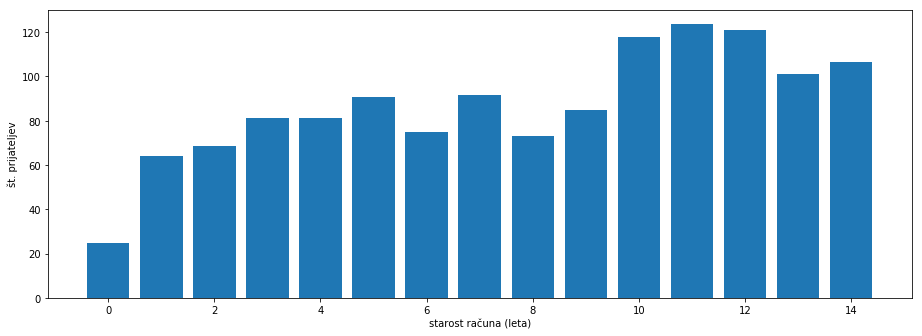

In [19]:
graph = dict()
today = datetime.datetime.now()

for player_id in global_player_ids:
    try:
        time_created = datetime.datetime.fromtimestamp(int(players_summaries[player_id]["timecreated"]))
    except KeyError:
        continue
    
    years = today.year - time_created.year
    if today.month < time_created.month or (today.month == time_created.month and today.day < time_created.day):
        years -= 1
        
    try:
        last_log = players_summaries[player_id]["lastlogoff"]
    except KeyError:
        continue
    try:
        time_last_log = datetime.datetime.fromtimestamp(int(last_log))
    except KeyError:
        continue
    #if today.month - time_last_log.month <=3 and today.year - time_last_log.year <= 1:     
    if years not in graph:
        graph[years] = [len(player_friends[player_id]), 1]
    else :
        su, cnt = graph[years]
        graph[years] = [su +len(player_friends[player_id]), cnt+1]

graph_x = []
graph_y = []
        
for dat in sorted(graph.items()):
    graph_x += [dat[0]]
    graph_y += [dat[1][0]/dat[1][1]]
    
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2, 1])
axes.bar(graph_x, graph_y)
axes.set_ylabel('št. prijateljev')
axes.set_xlabel('starost računa (leta)')
#axes.set_title('Primerjava žanrov ter njihovih ocen');

## 5. Odvisnost med težavnostjo igre in njenim uspehom